In [1]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

## Loading data

In [2]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)


Files already downloaded and verified


In [3]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

# Network Initialization

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [5]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = _netG()
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d (100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [6]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = _netD()
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d (512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Defining loss functions

In [7]:

criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [8]:
if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# Defining optimiser

In [9]:
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

# Training 

In [10]:

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

[0/25][0/782] Loss_D: 1.9319 Loss_G: 6.8388 D(x): 0.5714 D(G(z)): 0.6585 / 0.0017
[0/25][1/782] Loss_D: 1.1639 Loss_G: 4.7477 D(x): 0.5312 D(G(z)): 0.2595 / 0.0121
[0/25][2/782] Loss_D: 1.4035 Loss_G: 5.7094 D(x): 0.7775 D(G(z)): 0.6010 / 0.0057
[0/25][3/782] Loss_D: 1.0102 Loss_G: 6.6792 D(x): 0.7644 D(G(z)): 0.4161 / 0.0018
[0/25][4/782] Loss_D: 1.0500 Loss_G: 5.5019 D(x): 0.5927 D(G(z)): 0.2072 / 0.0057
[0/25][5/782] Loss_D: 1.0506 Loss_G: 6.7037 D(x): 0.7679 D(G(z)): 0.3902 / 0.0017
[0/25][6/782] Loss_D: 0.7384 Loss_G: 6.7155 D(x): 0.7384 D(G(z)): 0.2328 / 0.0016
[0/25][7/782] Loss_D: 0.7202 Loss_G: 7.6076 D(x): 0.8122 D(G(z)): 0.2940 / 0.0007
[0/25][8/782] Loss_D: 0.4637 Loss_G: 7.6970 D(x): 0.8271 D(G(z)): 0.1884 / 0.0007
[0/25][9/782] Loss_D: 0.9796 Loss_G: 8.9602 D(x): 0.7412 D(G(z)): 0.3794 / 0.0002
[0/25][10/782] Loss_D: 0.8228 Loss_G: 8.3985 D(x): 0.6930 D(G(z)): 0.2246 / 0.0004
[0/25][11/782] Loss_D: 0.8826 Loss_G: 10.6165 D(x): 0.7790 D(G(z)): 0.3630 / 0.0000
[0/25][12/782

[0/25][101/782] Loss_D: 0.7244 Loss_G: 10.4913 D(x): 0.6584 D(G(z)): 0.0009 / 0.0002
[0/25][102/782] Loss_D: 0.1754 Loss_G: 7.6911 D(x): 0.8807 D(G(z)): 0.0039 / 0.0037
[0/25][103/782] Loss_D: 0.1723 Loss_G: 4.8389 D(x): 0.9167 D(G(z)): 0.0544 / 0.0275
[0/25][104/782] Loss_D: 0.3716 Loss_G: 6.7687 D(x): 0.9872 D(G(z)): 0.2749 / 0.0033
[0/25][105/782] Loss_D: 0.1655 Loss_G: 6.3307 D(x): 0.9031 D(G(z)): 0.0403 / 0.0047
[0/25][106/782] Loss_D: 0.3705 Loss_G: 4.6517 D(x): 0.8417 D(G(z)): 0.0876 / 0.0196
[0/25][107/782] Loss_D: 0.5335 Loss_G: 7.1292 D(x): 0.8741 D(G(z)): 0.2743 / 0.0016
[0/25][108/782] Loss_D: 0.2996 Loss_G: 5.0926 D(x): 0.8017 D(G(z)): 0.0167 / 0.0097
[0/25][109/782] Loss_D: 0.2799 Loss_G: 5.3357 D(x): 0.9224 D(G(z)): 0.1516 / 0.0072
[0/25][110/782] Loss_D: 0.4429 Loss_G: 4.9186 D(x): 0.8171 D(G(z)): 0.1427 / 0.0139
[0/25][111/782] Loss_D: 0.4806 Loss_G: 6.2788 D(x): 0.8379 D(G(z)): 0.1830 / 0.0029
[0/25][112/782] Loss_D: 0.3757 Loss_G: 3.1739 D(x): 0.7943 D(G(z)): 0.0498 

[0/25][201/782] Loss_D: 0.2941 Loss_G: 8.9930 D(x): 0.9733 D(G(z)): 0.2025 / 0.0002
[0/25][202/782] Loss_D: 0.2291 Loss_G: 7.0651 D(x): 0.8485 D(G(z)): 0.0062 / 0.0020
[0/25][203/782] Loss_D: 0.1133 Loss_G: 5.5797 D(x): 0.9600 D(G(z)): 0.0628 / 0.0082
[0/25][204/782] Loss_D: 0.3600 Loss_G: 8.9657 D(x): 0.9485 D(G(z)): 0.2372 / 0.0003
[0/25][205/782] Loss_D: 0.1895 Loss_G: 7.5876 D(x): 0.8754 D(G(z)): 0.0092 / 0.0013
[0/25][206/782] Loss_D: 0.0916 Loss_G: 5.8415 D(x): 0.9643 D(G(z)): 0.0499 / 0.0051
[0/25][207/782] Loss_D: 0.1655 Loss_G: 7.6910 D(x): 0.9756 D(G(z)): 0.1199 / 0.0009
[0/25][208/782] Loss_D: 0.1552 Loss_G: 6.1688 D(x): 0.8915 D(G(z)): 0.0238 / 0.0041
[0/25][209/782] Loss_D: 0.1620 Loss_G: 6.2073 D(x): 0.9427 D(G(z)): 0.0761 / 0.0036
[0/25][210/782] Loss_D: 0.1317 Loss_G: 8.1456 D(x): 0.9790 D(G(z)): 0.0980 / 0.0005
[0/25][211/782] Loss_D: 0.1403 Loss_G: 6.7430 D(x): 0.9220 D(G(z)): 0.0116 / 0.0018
[0/25][212/782] Loss_D: 0.0834 Loss_G: 5.7014 D(x): 0.9638 D(G(z)): 0.0415 /

[0/25][301/782] Loss_D: 0.4688 Loss_G: 9.6725 D(x): 0.9337 D(G(z)): 0.2303 / 0.0001
[0/25][302/782] Loss_D: 0.2475 Loss_G: 9.1259 D(x): 0.9310 D(G(z)): 0.0085 / 0.0003
[0/25][303/782] Loss_D: 0.2050 Loss_G: 6.1646 D(x): 0.9050 D(G(z)): 0.0219 / 0.0067
[0/25][304/782] Loss_D: 0.3700 Loss_G: 7.8713 D(x): 0.9300 D(G(z)): 0.1941 / 0.0007
[0/25][305/782] Loss_D: 0.1650 Loss_G: 7.0131 D(x): 0.9013 D(G(z)): 0.0317 / 0.0020
[0/25][306/782] Loss_D: 0.1244 Loss_G: 5.7498 D(x): 0.9385 D(G(z)): 0.0450 / 0.0098
[0/25][307/782] Loss_D: 0.2568 Loss_G: 6.0964 D(x): 0.9138 D(G(z)): 0.1162 / 0.0051
[0/25][308/782] Loss_D: 0.3879 Loss_G: 4.7196 D(x): 0.8120 D(G(z)): 0.0804 / 0.0205
[0/25][309/782] Loss_D: 0.3421 Loss_G: 7.5460 D(x): 0.9174 D(G(z)): 0.1705 / 0.0011
[0/25][310/782] Loss_D: 0.3481 Loss_G: 5.3966 D(x): 0.7917 D(G(z)): 0.0119 / 0.0105
[0/25][311/782] Loss_D: 0.2873 Loss_G: 4.2576 D(x): 0.9265 D(G(z)): 0.0649 / 0.0223
[0/25][312/782] Loss_D: 0.2732 Loss_G: 9.2422 D(x): 0.9750 D(G(z)): 0.2029 /

[0/25][401/782] Loss_D: 0.1834 Loss_G: 3.7330 D(x): 0.8794 D(G(z)): 0.0331 / 0.0419
[0/25][402/782] Loss_D: 0.3261 Loss_G: 4.7759 D(x): 0.9255 D(G(z)): 0.1536 / 0.0135
[0/25][403/782] Loss_D: 0.6452 Loss_G: 0.5607 D(x): 0.6345 D(G(z)): 0.0458 / 0.6641
[0/25][404/782] Loss_D: 2.3007 Loss_G: 14.7926 D(x): 0.9933 D(G(z)): 0.8387 / 0.0000
[0/25][405/782] Loss_D: 5.2738 Loss_G: 7.5885 D(x): 0.0262 D(G(z)): 0.0000 / 0.0031
[0/25][406/782] Loss_D: 0.3997 Loss_G: 2.8160 D(x): 0.7240 D(G(z)): 0.0106 / 0.2493
[0/25][407/782] Loss_D: 0.7486 Loss_G: 4.1764 D(x): 0.9422 D(G(z)): 0.3967 / 0.0533
[0/25][408/782] Loss_D: 0.8774 Loss_G: 2.1402 D(x): 0.6579 D(G(z)): 0.1339 / 0.2199
[0/25][409/782] Loss_D: 0.6910 Loss_G: 5.4948 D(x): 0.9705 D(G(z)): 0.4170 / 0.0129
[0/25][410/782] Loss_D: 0.3990 Loss_G: 5.0763 D(x): 0.8185 D(G(z)): 0.0953 / 0.0179
[0/25][411/782] Loss_D: 0.7528 Loss_G: 1.8914 D(x): 0.6453 D(G(z)): 0.0604 / 0.2650
[0/25][412/782] Loss_D: 1.4953 Loss_G: 6.7144 D(x): 0.9878 D(G(z)): 0.6384 

[0/25][501/782] Loss_D: 0.5798 Loss_G: 3.8481 D(x): 0.8034 D(G(z)): 0.2342 / 0.0316
[0/25][502/782] Loss_D: 0.4657 Loss_G: 3.9826 D(x): 0.8208 D(G(z)): 0.1911 / 0.0254
[0/25][503/782] Loss_D: 0.2575 Loss_G: 4.2981 D(x): 0.9092 D(G(z)): 0.1367 / 0.0182
[0/25][504/782] Loss_D: 0.2143 Loss_G: 4.0914 D(x): 0.8902 D(G(z)): 0.0831 / 0.0233
[0/25][505/782] Loss_D: 0.2410 Loss_G: 4.0070 D(x): 0.8872 D(G(z)): 0.0997 / 0.0242
[0/25][506/782] Loss_D: 0.3152 Loss_G: 4.1629 D(x): 0.8666 D(G(z)): 0.1421 / 0.0195
[0/25][507/782] Loss_D: 0.5558 Loss_G: 4.5026 D(x): 0.7743 D(G(z)): 0.2074 / 0.0137
[0/25][508/782] Loss_D: 0.4596 Loss_G: 3.9059 D(x): 0.7641 D(G(z)): 0.1335 / 0.0269
[0/25][509/782] Loss_D: 0.3124 Loss_G: 6.1997 D(x): 0.9400 D(G(z)): 0.2025 / 0.0036
[0/25][510/782] Loss_D: 0.1703 Loss_G: 5.2480 D(x): 0.8952 D(G(z)): 0.0521 / 0.0080
[0/25][511/782] Loss_D: 0.5344 Loss_G: 2.7856 D(x): 0.7204 D(G(z)): 0.1042 / 0.0937
[0/25][512/782] Loss_D: 1.3156 Loss_G: 9.5336 D(x): 0.9438 D(G(z)): 0.6415 /

[0/25][601/782] Loss_D: 0.4465 Loss_G: 3.9707 D(x): 0.7627 D(G(z)): 0.0386 / 0.0290
[0/25][602/782] Loss_D: 0.4238 Loss_G: 6.9954 D(x): 0.9292 D(G(z)): 0.2639 / 0.0014
[0/25][603/782] Loss_D: 0.1950 Loss_G: 6.3373 D(x): 0.8628 D(G(z)): 0.0117 / 0.0043
[0/25][604/782] Loss_D: 0.1603 Loss_G: 6.0719 D(x): 0.9427 D(G(z)): 0.0685 / 0.0038
[0/25][605/782] Loss_D: 0.2529 Loss_G: 4.9222 D(x): 0.8542 D(G(z)): 0.0595 / 0.0143
[0/25][606/782] Loss_D: 0.4818 Loss_G: 8.8927 D(x): 0.9270 D(G(z)): 0.3083 / 0.0003
[0/25][607/782] Loss_D: 0.1983 Loss_G: 7.8433 D(x): 0.8360 D(G(z)): 0.0034 / 0.0012
[0/25][608/782] Loss_D: 0.2033 Loss_G: 4.7188 D(x): 0.8500 D(G(z)): 0.0173 / 0.0155
[0/25][609/782] Loss_D: 0.8264 Loss_G: 12.1336 D(x): 0.9869 D(G(z)): 0.4797 / 0.0000
[0/25][610/782] Loss_D: 0.7170 Loss_G: 11.2015 D(x): 0.5890 D(G(z)): 0.0001 / 0.0000
[0/25][611/782] Loss_D: 0.2139 Loss_G: 7.5745 D(x): 0.8418 D(G(z)): 0.0005 / 0.0012
[0/25][612/782] Loss_D: 0.0882 Loss_G: 4.0667 D(x): 0.9476 D(G(z)): 0.0267

[0/25][701/782] Loss_D: 0.2371 Loss_G: 3.0718 D(x): 0.8900 D(G(z)): 0.0402 / 0.0665
[0/25][702/782] Loss_D: 0.5329 Loss_G: 7.2274 D(x): 0.9923 D(G(z)): 0.3419 / 0.0015
[0/25][703/782] Loss_D: 0.6261 Loss_G: 4.0294 D(x): 0.6451 D(G(z)): 0.0299 / 0.0489
[0/25][704/782] Loss_D: 0.2288 Loss_G: 4.7564 D(x): 0.9507 D(G(z)): 0.1326 / 0.0182
[0/25][705/782] Loss_D: 0.2735 Loss_G: 5.0192 D(x): 0.8985 D(G(z)): 0.1259 / 0.0134
[0/25][706/782] Loss_D: 0.2297 Loss_G: 6.1442 D(x): 0.9617 D(G(z)): 0.1567 / 0.0033
[0/25][707/782] Loss_D: 0.1480 Loss_G: 5.3987 D(x): 0.9007 D(G(z)): 0.0277 / 0.0076
[0/25][708/782] Loss_D: 0.1442 Loss_G: 4.5101 D(x): 0.9335 D(G(z)): 0.0675 / 0.0159
[0/25][709/782] Loss_D: 0.2099 Loss_G: 3.9422 D(x): 0.8761 D(G(z)): 0.0574 / 0.0266
[0/25][710/782] Loss_D: 0.3342 Loss_G: 5.7781 D(x): 0.9289 D(G(z)): 0.2072 / 0.0049
[0/25][711/782] Loss_D: 0.0922 Loss_G: 5.9137 D(x): 0.9442 D(G(z)): 0.0316 / 0.0045
[0/25][712/782] Loss_D: 0.2791 Loss_G: 4.1511 D(x): 0.8310 D(G(z)): 0.0302 /

[1/25][17/782] Loss_D: 1.0069 Loss_G: 11.2387 D(x): 0.9933 D(G(z)): 0.5350 / 0.0000
[1/25][18/782] Loss_D: 1.2955 Loss_G: 7.3331 D(x): 0.4202 D(G(z)): 0.0002 / 0.0016
[1/25][19/782] Loss_D: 0.2516 Loss_G: 2.7805 D(x): 0.8536 D(G(z)): 0.0196 / 0.1517
[1/25][20/782] Loss_D: 1.2194 Loss_G: 9.2469 D(x): 0.9970 D(G(z)): 0.6002 / 0.0002
[1/25][21/782] Loss_D: 0.5647 Loss_G: 6.9104 D(x): 0.6721 D(G(z)): 0.0037 / 0.0030
[1/25][22/782] Loss_D: 0.3212 Loss_G: 3.0997 D(x): 0.7961 D(G(z)): 0.0289 / 0.0844
[1/25][23/782] Loss_D: 1.0879 Loss_G: 8.1609 D(x): 0.9280 D(G(z)): 0.5539 / 0.0008
[1/25][24/782] Loss_D: 0.8913 Loss_G: 4.7234 D(x): 0.5721 D(G(z)): 0.0466 / 0.0308
[1/25][25/782] Loss_D: 0.9699 Loss_G: 2.5435 D(x): 0.6318 D(G(z)): 0.1998 / 0.1165
[1/25][26/782] Loss_D: 1.2736 Loss_G: 9.2535 D(x): 0.9777 D(G(z)): 0.6087 / 0.0006
[1/25][27/782] Loss_D: 0.9744 Loss_G: 6.6178 D(x): 0.5157 D(G(z)): 0.0071 / 0.0108
[1/25][28/782] Loss_D: 0.2972 Loss_G: 3.9904 D(x): 0.8711 D(G(z)): 0.1141 / 0.0447
[1/

[1/25][117/782] Loss_D: 0.3644 Loss_G: 3.9978 D(x): 0.8695 D(G(z)): 0.1548 / 0.0362
[1/25][118/782] Loss_D: 0.3497 Loss_G: 4.8203 D(x): 0.8966 D(G(z)): 0.1860 / 0.0128
[1/25][119/782] Loss_D: 0.4498 Loss_G: 3.6106 D(x): 0.7737 D(G(z)): 0.0912 / 0.0492
[1/25][120/782] Loss_D: 0.4722 Loss_G: 5.8329 D(x): 0.9690 D(G(z)): 0.2937 / 0.0057
[1/25][121/782] Loss_D: 0.1068 Loss_G: 6.5496 D(x): 0.9206 D(G(z)): 0.0128 / 0.0035
[1/25][122/782] Loss_D: 0.5505 Loss_G: 3.0966 D(x): 0.7265 D(G(z)): 0.0374 / 0.0863
[1/25][123/782] Loss_D: 0.2944 Loss_G: 3.9314 D(x): 0.9379 D(G(z)): 0.1749 / 0.0345
[1/25][124/782] Loss_D: 0.2331 Loss_G: 5.0897 D(x): 0.9358 D(G(z)): 0.1313 / 0.0142
[1/25][125/782] Loss_D: 0.1197 Loss_G: 4.9177 D(x): 0.9253 D(G(z)): 0.0363 / 0.0122
[1/25][126/782] Loss_D: 0.2313 Loss_G: 3.7089 D(x): 0.8522 D(G(z)): 0.0468 / 0.0417
[1/25][127/782] Loss_D: 0.3336 Loss_G: 4.0861 D(x): 0.9135 D(G(z)): 0.1823 / 0.0256
[1/25][128/782] Loss_D: 0.1335 Loss_G: 4.9869 D(x): 0.9568 D(G(z)): 0.0818 /

[1/25][217/782] Loss_D: 0.3342 Loss_G: 2.9579 D(x): 0.8234 D(G(z)): 0.1090 / 0.0737
[1/25][218/782] Loss_D: 0.4479 Loss_G: 4.3809 D(x): 0.9255 D(G(z)): 0.2719 / 0.0211
[1/25][219/782] Loss_D: 0.3806 Loss_G: 3.4897 D(x): 0.7580 D(G(z)): 0.0488 / 0.0475
[1/25][220/782] Loss_D: 0.4681 Loss_G: 2.5319 D(x): 0.7567 D(G(z)): 0.1149 / 0.1273
[1/25][221/782] Loss_D: 0.4912 Loss_G: 4.2540 D(x): 0.9488 D(G(z)): 0.3058 / 0.0243
[1/25][222/782] Loss_D: 0.2080 Loss_G: 4.4169 D(x): 0.8818 D(G(z)): 0.0633 / 0.0173
[1/25][223/782] Loss_D: 0.4036 Loss_G: 2.7431 D(x): 0.7663 D(G(z)): 0.0678 / 0.0944
[1/25][224/782] Loss_D: 0.2063 Loss_G: 3.6006 D(x): 0.9266 D(G(z)): 0.1108 / 0.0402
[1/25][225/782] Loss_D: 0.4977 Loss_G: 4.4821 D(x): 0.9186 D(G(z)): 0.2745 / 0.0174
[1/25][226/782] Loss_D: 0.2734 Loss_G: 4.3171 D(x): 0.8331 D(G(z)): 0.0610 / 0.0264
[1/25][227/782] Loss_D: 0.4793 Loss_G: 2.3436 D(x): 0.7755 D(G(z)): 0.1475 / 0.1369
[1/25][228/782] Loss_D: 0.4579 Loss_G: 4.3607 D(x): 0.8768 D(G(z)): 0.2430 /

[1/25][317/782] Loss_D: 0.2985 Loss_G: 4.0310 D(x): 0.8515 D(G(z)): 0.1084 / 0.0262
[1/25][318/782] Loss_D: 0.3873 Loss_G: 2.7202 D(x): 0.8002 D(G(z)): 0.0995 / 0.0980
[1/25][319/782] Loss_D: 0.5003 Loss_G: 5.0842 D(x): 0.8939 D(G(z)): 0.2797 / 0.0116
[1/25][320/782] Loss_D: 0.4746 Loss_G: 3.5161 D(x): 0.7462 D(G(z)): 0.0919 / 0.0464
[1/25][321/782] Loss_D: 0.4301 Loss_G: 3.4695 D(x): 0.8314 D(G(z)): 0.1765 / 0.0567
[1/25][322/782] Loss_D: 0.6719 Loss_G: 5.5163 D(x): 0.8098 D(G(z)): 0.2912 / 0.0140
[1/25][323/782] Loss_D: 0.8887 Loss_G: 2.5898 D(x): 0.5980 D(G(z)): 0.0988 / 0.1150
[1/25][324/782] Loss_D: 0.6331 Loss_G: 5.1792 D(x): 0.9057 D(G(z)): 0.3544 / 0.0108
[1/25][325/782] Loss_D: 0.4441 Loss_G: 3.6764 D(x): 0.7710 D(G(z)): 0.0763 / 0.0434
[1/25][326/782] Loss_D: 0.3995 Loss_G: 4.5978 D(x): 0.9108 D(G(z)): 0.2337 / 0.0152
[1/25][327/782] Loss_D: 0.5677 Loss_G: 4.0376 D(x): 0.7709 D(G(z)): 0.2049 / 0.0303
[1/25][328/782] Loss_D: 0.7232 Loss_G: 5.8082 D(x): 0.8334 D(G(z)): 0.3506 /

[1/25][417/782] Loss_D: 0.2780 Loss_G: 3.9723 D(x): 0.8146 D(G(z)): 0.0429 / 0.0273
[1/25][418/782] Loss_D: 0.3476 Loss_G: 2.8115 D(x): 0.8231 D(G(z)): 0.1008 / 0.0867
[1/25][419/782] Loss_D: 0.6301 Loss_G: 5.5117 D(x): 0.9104 D(G(z)): 0.3654 / 0.0085
[1/25][420/782] Loss_D: 0.5614 Loss_G: 3.6106 D(x): 0.6679 D(G(z)): 0.0494 / 0.0503
[1/25][421/782] Loss_D: 0.6904 Loss_G: 3.8698 D(x): 0.8471 D(G(z)): 0.3481 / 0.0312
[1/25][422/782] Loss_D: 1.1705 Loss_G: 1.7959 D(x): 0.4933 D(G(z)): 0.2319 / 0.2503
[1/25][423/782] Loss_D: 0.9382 Loss_G: 6.2070 D(x): 0.9373 D(G(z)): 0.4950 / 0.0049
[1/25][424/782] Loss_D: 0.8658 Loss_G: 3.1845 D(x): 0.5682 D(G(z)): 0.0371 / 0.0830
[1/25][425/782] Loss_D: 0.2996 Loss_G: 2.9783 D(x): 0.9170 D(G(z)): 0.1724 / 0.0759
[1/25][426/782] Loss_D: 0.5561 Loss_G: 4.6328 D(x): 0.9253 D(G(z)): 0.3205 / 0.0169
[1/25][427/782] Loss_D: 0.3082 Loss_G: 4.4843 D(x): 0.8605 D(G(z)): 0.1108 / 0.0199
[1/25][428/782] Loss_D: 0.6489 Loss_G: 2.8249 D(x): 0.7222 D(G(z)): 0.1883 /

[1/25][517/782] Loss_D: 0.8401 Loss_G: 6.0557 D(x): 0.9508 D(G(z)): 0.4868 / 0.0039
[1/25][518/782] Loss_D: 1.0776 Loss_G: 2.5377 D(x): 0.4819 D(G(z)): 0.0980 / 0.1469
[1/25][519/782] Loss_D: 0.5057 Loss_G: 3.3068 D(x): 0.8542 D(G(z)): 0.2521 / 0.0537
[1/25][520/782] Loss_D: 0.4781 Loss_G: 4.7755 D(x): 0.9184 D(G(z)): 0.2744 / 0.0162
[1/25][521/782] Loss_D: 0.5155 Loss_G: 3.3687 D(x): 0.7471 D(G(z)): 0.1518 / 0.0602
[1/25][522/782] Loss_D: 0.5996 Loss_G: 4.0172 D(x): 0.8513 D(G(z)): 0.2927 / 0.0293
[1/25][523/782] Loss_D: 0.8795 Loss_G: 1.8557 D(x): 0.5863 D(G(z)): 0.1439 / 0.2023
[1/25][524/782] Loss_D: 1.0867 Loss_G: 5.8352 D(x): 0.9079 D(G(z)): 0.5572 / 0.0055
[1/25][525/782] Loss_D: 0.6052 Loss_G: 3.8672 D(x): 0.6257 D(G(z)): 0.0279 / 0.0421
[1/25][526/782] Loss_D: 0.9457 Loss_G: 1.4170 D(x): 0.5947 D(G(z)): 0.2166 / 0.3350
[1/25][527/782] Loss_D: 1.5793 Loss_G: 7.0257 D(x): 0.9201 D(G(z)): 0.7262 / 0.0027
[1/25][528/782] Loss_D: 1.4883 Loss_G: 1.5278 D(x): 0.3362 D(G(z)): 0.0236 /

[1/25][617/782] Loss_D: 1.1529 Loss_G: 5.7332 D(x): 0.9548 D(G(z)): 0.5884 / 0.0071
[1/25][618/782] Loss_D: 0.9541 Loss_G: 1.9357 D(x): 0.4798 D(G(z)): 0.0331 / 0.2856
[1/25][619/782] Loss_D: 0.8201 Loss_G: 4.6940 D(x): 0.9465 D(G(z)): 0.4349 / 0.0142
[1/25][620/782] Loss_D: 0.5878 Loss_G: 3.5585 D(x): 0.7159 D(G(z)): 0.1169 / 0.0482
[1/25][621/782] Loss_D: 0.5064 Loss_G: 4.6627 D(x): 0.8929 D(G(z)): 0.2675 / 0.0123
[1/25][622/782] Loss_D: 1.0465 Loss_G: 1.8407 D(x): 0.5203 D(G(z)): 0.1633 / 0.1956
[1/25][623/782] Loss_D: 0.9821 Loss_G: 5.3612 D(x): 0.8875 D(G(z)): 0.5041 / 0.0074
[1/25][624/782] Loss_D: 0.7741 Loss_G: 3.1761 D(x): 0.5561 D(G(z)): 0.0361 / 0.0756
[1/25][625/782] Loss_D: 0.5335 Loss_G: 3.5616 D(x): 0.8942 D(G(z)): 0.2941 / 0.0425
[1/25][626/782] Loss_D: 0.6050 Loss_G: 4.2913 D(x): 0.8226 D(G(z)): 0.2711 / 0.0230
[1/25][627/782] Loss_D: 0.5870 Loss_G: 2.9779 D(x): 0.7320 D(G(z)): 0.1629 / 0.0829
[1/25][628/782] Loss_D: 0.5486 Loss_G: 4.6742 D(x): 0.8651 D(G(z)): 0.2725 /

[1/25][717/782] Loss_D: 0.3414 Loss_G: 4.5622 D(x): 0.8254 D(G(z)): 0.0633 / 0.0255
[1/25][718/782] Loss_D: 0.4816 Loss_G: 2.9992 D(x): 0.7758 D(G(z)): 0.1302 / 0.0889
[1/25][719/782] Loss_D: 0.4930 Loss_G: 4.2392 D(x): 0.9078 D(G(z)): 0.2726 / 0.0262
[1/25][720/782] Loss_D: 0.4707 Loss_G: 3.4274 D(x): 0.7558 D(G(z)): 0.1171 / 0.0533
[1/25][721/782] Loss_D: 0.8324 Loss_G: 4.4106 D(x): 0.8143 D(G(z)): 0.3749 / 0.0199
[1/25][722/782] Loss_D: 0.4774 Loss_G: 3.2061 D(x): 0.7328 D(G(z)): 0.0940 / 0.0543
[1/25][723/782] Loss_D: 0.5673 Loss_G: 2.7241 D(x): 0.7371 D(G(z)): 0.1846 / 0.0965
[1/25][724/782] Loss_D: 0.6387 Loss_G: 4.8011 D(x): 0.8603 D(G(z)): 0.3393 / 0.0127
[1/25][725/782] Loss_D: 0.5780 Loss_G: 2.5682 D(x): 0.6574 D(G(z)): 0.0672 / 0.1053
[1/25][726/782] Loss_D: 0.5562 Loss_G: 4.3997 D(x): 0.9115 D(G(z)): 0.3268 / 0.0180
[1/25][727/782] Loss_D: 0.5728 Loss_G: 3.4436 D(x): 0.7190 D(G(z)): 0.1566 / 0.0481
[1/25][728/782] Loss_D: 0.3742 Loss_G: 4.2295 D(x): 0.9160 D(G(z)): 0.2193 /

[2/25][37/782] Loss_D: 0.3389 Loss_G: 2.4683 D(x): 0.8345 D(G(z)): 0.1162 / 0.1130
[2/25][38/782] Loss_D: 0.3548 Loss_G: 3.8365 D(x): 0.9395 D(G(z)): 0.1987 / 0.0354
[2/25][39/782] Loss_D: 0.3569 Loss_G: 3.9835 D(x): 0.8804 D(G(z)): 0.1722 / 0.0305
[2/25][40/782] Loss_D: 0.4133 Loss_G: 3.6277 D(x): 0.8472 D(G(z)): 0.1886 / 0.0400
[2/25][41/782] Loss_D: 0.4802 Loss_G: 1.8995 D(x): 0.7395 D(G(z)): 0.1029 / 0.2022
[2/25][42/782] Loss_D: 0.6832 Loss_G: 5.7356 D(x): 0.9433 D(G(z)): 0.4064 / 0.0060
[2/25][43/782] Loss_D: 1.2865 Loss_G: 0.4198 D(x): 0.3618 D(G(z)): 0.0131 / 0.7108
[2/25][44/782] Loss_D: 2.2413 Loss_G: 7.5030 D(x): 0.9723 D(G(z)): 0.8098 / 0.0013
[2/25][45/782] Loss_D: 1.3677 Loss_G: 2.7478 D(x): 0.3399 D(G(z)): 0.0077 / 0.1190
[2/25][46/782] Loss_D: 0.4840 Loss_G: 2.4868 D(x): 0.8883 D(G(z)): 0.2437 / 0.1326
[2/25][47/782] Loss_D: 0.5355 Loss_G: 4.5497 D(x): 0.9057 D(G(z)): 0.2901 / 0.0187
[2/25][48/782] Loss_D: 0.3896 Loss_G: 3.2483 D(x): 0.7562 D(G(z)): 0.0672 / 0.0655
[2/2

[2/25][137/782] Loss_D: 0.4496 Loss_G: 3.0427 D(x): 0.7585 D(G(z)): 0.1149 / 0.0719
[2/25][138/782] Loss_D: 0.3811 Loss_G: 4.2146 D(x): 0.9093 D(G(z)): 0.2222 / 0.0263
[2/25][139/782] Loss_D: 0.3152 Loss_G: 3.6060 D(x): 0.8108 D(G(z)): 0.0671 / 0.0470
[2/25][140/782] Loss_D: 0.2887 Loss_G: 4.4735 D(x): 0.9498 D(G(z)): 0.1903 / 0.0167
[2/25][141/782] Loss_D: 0.6744 Loss_G: 1.8787 D(x): 0.6299 D(G(z)): 0.0738 / 0.1948
[2/25][142/782] Loss_D: 0.7938 Loss_G: 6.3681 D(x): 0.9501 D(G(z)): 0.4646 / 0.0036
[2/25][143/782] Loss_D: 0.7296 Loss_G: 2.8399 D(x): 0.5642 D(G(z)): 0.0134 / 0.0927
[2/25][144/782] Loss_D: 0.4177 Loss_G: 4.9130 D(x): 0.9711 D(G(z)): 0.2891 / 0.0129
[2/25][145/782] Loss_D: 0.2795 Loss_G: 3.9066 D(x): 0.8341 D(G(z)): 0.0674 / 0.0313
[2/25][146/782] Loss_D: 0.3437 Loss_G: 4.3589 D(x): 0.8971 D(G(z)): 0.1826 / 0.0200
[2/25][147/782] Loss_D: 0.4820 Loss_G: 2.2030 D(x): 0.7263 D(G(z)): 0.1060 / 0.1498
[2/25][148/782] Loss_D: 0.7503 Loss_G: 6.4608 D(x): 0.9239 D(G(z)): 0.4095 /

[2/25][237/782] Loss_D: 0.9199 Loss_G: 1.3371 D(x): 0.4914 D(G(z)): 0.0079 / 0.3816
[2/25][238/782] Loss_D: 1.1186 Loss_G: 5.4829 D(x): 0.9180 D(G(z)): 0.5204 / 0.0094
[2/25][239/782] Loss_D: 0.5326 Loss_G: 2.6690 D(x): 0.6560 D(G(z)): 0.0281 / 0.1355
[2/25][240/782] Loss_D: 0.7066 Loss_G: 5.1388 D(x): 0.9174 D(G(z)): 0.3554 / 0.0126
[2/25][241/782] Loss_D: 0.5121 Loss_G: 3.0741 D(x): 0.7336 D(G(z)): 0.0941 / 0.0869
[2/25][242/782] Loss_D: 0.6865 Loss_G: 4.5847 D(x): 0.8418 D(G(z)): 0.3301 / 0.0240
[2/25][243/782] Loss_D: 0.7746 Loss_G: 1.4176 D(x): 0.5826 D(G(z)): 0.0544 / 0.3076
[2/25][244/782] Loss_D: 1.9021 Loss_G: 8.9302 D(x): 0.9547 D(G(z)): 0.7561 / 0.0003
[2/25][245/782] Loss_D: 2.0788 Loss_G: 1.1471 D(x): 0.1895 D(G(z)): 0.0019 / 0.4194
[2/25][246/782] Loss_D: 1.9560 Loss_G: 8.8640 D(x): 0.9658 D(G(z)): 0.7867 / 0.0003
[2/25][247/782] Loss_D: 2.3380 Loss_G: 2.0356 D(x): 0.1749 D(G(z)): 0.0020 / 0.2224
[2/25][248/782] Loss_D: 0.5943 Loss_G: 3.1899 D(x): 0.9754 D(G(z)): 0.3633 /

[2/25][337/782] Loss_D: 0.8341 Loss_G: 6.8299 D(x): 0.9445 D(G(z)): 0.4923 / 0.0019
[2/25][338/782] Loss_D: 0.7260 Loss_G: 3.5135 D(x): 0.5699 D(G(z)): 0.0102 / 0.0607
[2/25][339/782] Loss_D: 0.4934 Loss_G: 2.9504 D(x): 0.8353 D(G(z)): 0.2212 / 0.0872
[2/25][340/782] Loss_D: 0.4948 Loss_G: 5.3277 D(x): 0.8958 D(G(z)): 0.2610 / 0.0079
[2/25][341/782] Loss_D: 0.4622 Loss_G: 3.3575 D(x): 0.6879 D(G(z)): 0.0236 / 0.0553
[2/25][342/782] Loss_D: 0.5528 Loss_G: 4.3052 D(x): 0.8823 D(G(z)): 0.2887 / 0.0229
[2/25][343/782] Loss_D: 0.2791 Loss_G: 4.8315 D(x): 0.9068 D(G(z)): 0.1347 / 0.0130
[2/25][344/782] Loss_D: 0.3434 Loss_G: 3.1629 D(x): 0.7918 D(G(z)): 0.0511 / 0.0650
[2/25][345/782] Loss_D: 0.6138 Loss_G: 4.4036 D(x): 0.8371 D(G(z)): 0.2864 / 0.0192
[2/25][346/782] Loss_D: 0.2449 Loss_G: 4.8414 D(x): 0.8982 D(G(z)): 0.1167 / 0.0120
[2/25][347/782] Loss_D: 0.3399 Loss_G: 3.3364 D(x): 0.7941 D(G(z)): 0.0480 / 0.0642
[2/25][348/782] Loss_D: 0.5076 Loss_G: 5.3873 D(x): 0.9186 D(G(z)): 0.2906 /

[2/25][437/782] Loss_D: 0.4610 Loss_G: 4.5786 D(x): 0.9325 D(G(z)): 0.2908 / 0.0154
[2/25][438/782] Loss_D: 0.2497 Loss_G: 4.1339 D(x): 0.8498 D(G(z)): 0.0682 / 0.0268
[2/25][439/782] Loss_D: 0.4029 Loss_G: 2.6029 D(x): 0.7486 D(G(z)): 0.0639 / 0.1075
[2/25][440/782] Loss_D: 0.3997 Loss_G: 3.8243 D(x): 0.9470 D(G(z)): 0.2697 / 0.0283
[2/25][441/782] Loss_D: 0.3073 Loss_G: 3.5060 D(x): 0.8160 D(G(z)): 0.0561 / 0.0385
[2/25][442/782] Loss_D: 0.3171 Loss_G: 3.7506 D(x): 0.9128 D(G(z)): 0.1773 / 0.0350
[2/25][443/782] Loss_D: 0.3207 Loss_G: 3.2271 D(x): 0.8300 D(G(z)): 0.0985 / 0.0562
[2/25][444/782] Loss_D: 0.3882 Loss_G: 4.0179 D(x): 0.9232 D(G(z)): 0.2328 / 0.0245
[2/25][445/782] Loss_D: 0.5398 Loss_G: 2.4442 D(x): 0.6814 D(G(z)): 0.0911 / 0.1174
[2/25][446/782] Loss_D: 0.6913 Loss_G: 4.9675 D(x): 0.9232 D(G(z)): 0.4078 / 0.0109
[2/25][447/782] Loss_D: 0.4272 Loss_G: 3.8295 D(x): 0.7046 D(G(z)): 0.0295 / 0.0306
[2/25][448/782] Loss_D: 0.4568 Loss_G: 2.7297 D(x): 0.8072 D(G(z)): 0.1874 /

[2/25][537/782] Loss_D: 0.2408 Loss_G: 4.3410 D(x): 0.8714 D(G(z)): 0.0814 / 0.0222
[2/25][538/782] Loss_D: 0.3746 Loss_G: 2.2664 D(x): 0.7966 D(G(z)): 0.1136 / 0.1408
[2/25][539/782] Loss_D: 0.6972 Loss_G: 5.5978 D(x): 0.8994 D(G(z)): 0.4076 / 0.0050
[2/25][540/782] Loss_D: 0.7164 Loss_G: 2.7605 D(x): 0.5697 D(G(z)): 0.0533 / 0.1059
[2/25][541/782] Loss_D: 0.3989 Loss_G: 3.6537 D(x): 0.9047 D(G(z)): 0.2294 / 0.0355
[2/25][542/782] Loss_D: 0.3522 Loss_G: 4.5059 D(x): 0.9040 D(G(z)): 0.1974 / 0.0166
[2/25][543/782] Loss_D: 0.5009 Loss_G: 2.5181 D(x): 0.6821 D(G(z)): 0.0601 / 0.1171
[2/25][544/782] Loss_D: 0.3553 Loss_G: 4.1562 D(x): 0.9458 D(G(z)): 0.2360 / 0.0211
[2/25][545/782] Loss_D: 0.3152 Loss_G: 4.4365 D(x): 0.9025 D(G(z)): 0.1746 / 0.0169
[2/25][546/782] Loss_D: 0.2143 Loss_G: 4.1610 D(x): 0.8582 D(G(z)): 0.0460 / 0.0290
[2/25][547/782] Loss_D: 0.2142 Loss_G: 3.2715 D(x): 0.8752 D(G(z)): 0.0667 / 0.0565
[2/25][548/782] Loss_D: 0.3901 Loss_G: 4.9450 D(x): 0.9729 D(G(z)): 0.2827 /

[2/25][637/782] Loss_D: 0.6911 Loss_G: 2.7974 D(x): 0.7406 D(G(z)): 0.2246 / 0.0964
[2/25][638/782] Loss_D: 0.9993 Loss_G: 1.1956 D(x): 0.5792 D(G(z)): 0.2179 / 0.3629
[2/25][639/782] Loss_D: 1.5261 Loss_G: 6.6757 D(x): 0.9518 D(G(z)): 0.6872 / 0.0025
[2/25][640/782] Loss_D: 2.1680 Loss_G: 0.6603 D(x): 0.1791 D(G(z)): 0.0084 / 0.6009
[2/25][641/782] Loss_D: 1.6822 Loss_G: 7.5456 D(x): 0.9534 D(G(z)): 0.7089 / 0.0012
[2/25][642/782] Loss_D: 1.9687 Loss_G: 1.4892 D(x): 0.2278 D(G(z)): 0.0082 / 0.3077
[2/25][643/782] Loss_D: 0.7226 Loss_G: 2.0274 D(x): 0.8889 D(G(z)): 0.3597 / 0.1835
[2/25][644/782] Loss_D: 0.7389 Loss_G: 4.8049 D(x): 0.9053 D(G(z)): 0.3884 / 0.0173
[2/25][645/782] Loss_D: 0.6175 Loss_G: 3.0843 D(x): 0.6529 D(G(z)): 0.0700 / 0.0780
[2/25][646/782] Loss_D: 0.8090 Loss_G: 1.5607 D(x): 0.6832 D(G(z)): 0.2451 / 0.2872
[2/25][647/782] Loss_D: 1.6125 Loss_G: 4.6010 D(x): 0.7192 D(G(z)): 0.6255 / 0.0205
[2/25][648/782] Loss_D: 1.0732 Loss_G: 2.5061 D(x): 0.5229 D(G(z)): 0.0926 /

[2/25][737/782] Loss_D: 0.7044 Loss_G: 2.1633 D(x): 0.7042 D(G(z)): 0.2490 / 0.1481
[2/25][738/782] Loss_D: 0.6447 Loss_G: 2.2737 D(x): 0.7123 D(G(z)): 0.2037 / 0.1381
[2/25][739/782] Loss_D: 0.8159 Loss_G: 4.4211 D(x): 0.8808 D(G(z)): 0.4367 / 0.0168
[2/25][740/782] Loss_D: 0.9588 Loss_G: 1.5240 D(x): 0.4910 D(G(z)): 0.0721 / 0.2664
[2/25][741/782] Loss_D: 0.5721 Loss_G: 2.7952 D(x): 0.8792 D(G(z)): 0.3146 / 0.0891
[2/25][742/782] Loss_D: 0.7079 Loss_G: 3.6580 D(x): 0.7955 D(G(z)): 0.3032 / 0.0372
[2/25][743/782] Loss_D: 0.5883 Loss_G: 2.3888 D(x): 0.6590 D(G(z)): 0.0657 / 0.1282
[2/25][744/782] Loss_D: 0.4772 Loss_G: 2.7823 D(x): 0.8601 D(G(z)): 0.2371 / 0.0911
[2/25][745/782] Loss_D: 0.4772 Loss_G: 4.5045 D(x): 0.9353 D(G(z)): 0.3052 / 0.0161
[2/25][746/782] Loss_D: 0.7176 Loss_G: 2.4020 D(x): 0.5815 D(G(z)): 0.0543 / 0.1619
[2/25][747/782] Loss_D: 0.5070 Loss_G: 2.2636 D(x): 0.8599 D(G(z)): 0.2364 / 0.1477
[2/25][748/782] Loss_D: 0.8581 Loss_G: 3.4164 D(x): 0.8481 D(G(z)): 0.4223 /

[3/25][57/782] Loss_D: 0.4015 Loss_G: 2.8500 D(x): 0.8257 D(G(z)): 0.1635 / 0.0803
[3/25][58/782] Loss_D: 0.4542 Loss_G: 2.2666 D(x): 0.7859 D(G(z)): 0.1559 / 0.1439
[3/25][59/782] Loss_D: 0.3023 Loss_G: 3.2164 D(x): 0.9267 D(G(z)): 0.1870 / 0.0534
[3/25][60/782] Loss_D: 0.4339 Loss_G: 3.0800 D(x): 0.8281 D(G(z)): 0.1904 / 0.0624
[3/25][61/782] Loss_D: 0.5146 Loss_G: 2.0793 D(x): 0.7224 D(G(z)): 0.1254 / 0.1586
[3/25][62/782] Loss_D: 0.7354 Loss_G: 4.8595 D(x): 0.9142 D(G(z)): 0.4268 / 0.0116
[3/25][63/782] Loss_D: 1.0148 Loss_G: 1.3369 D(x): 0.4387 D(G(z)): 0.0348 / 0.3338
[3/25][64/782] Loss_D: 0.8393 Loss_G: 4.3982 D(x): 0.9377 D(G(z)): 0.4716 / 0.0180
[3/25][65/782] Loss_D: 0.4734 Loss_G: 2.8617 D(x): 0.7217 D(G(z)): 0.0795 / 0.0832
[3/25][66/782] Loss_D: 0.3211 Loss_G: 2.3948 D(x): 0.8465 D(G(z)): 0.1231 / 0.1210
[3/25][67/782] Loss_D: 0.5120 Loss_G: 3.0609 D(x): 0.8502 D(G(z)): 0.2510 / 0.0689
[3/25][68/782] Loss_D: 0.9007 Loss_G: 2.5281 D(x): 0.6358 D(G(z)): 0.2547 / 0.1120
[3/2

[3/25][157/782] Loss_D: 0.7198 Loss_G: 2.2073 D(x): 0.6447 D(G(z)): 0.1775 / 0.1423
[3/25][158/782] Loss_D: 0.5505 Loss_G: 3.9152 D(x): 0.8751 D(G(z)): 0.3001 / 0.0293
[3/25][159/782] Loss_D: 0.5526 Loss_G: 2.3085 D(x): 0.6906 D(G(z)): 0.1002 / 0.1433
[3/25][160/782] Loss_D: 0.3469 Loss_G: 3.2651 D(x): 0.9058 D(G(z)): 0.2013 / 0.0474
[3/25][161/782] Loss_D: 0.3547 Loss_G: 3.9059 D(x): 0.8816 D(G(z)): 0.1843 / 0.0282
[3/25][162/782] Loss_D: 0.4393 Loss_G: 2.2999 D(x): 0.7231 D(G(z)): 0.0723 / 0.1410
[3/25][163/782] Loss_D: 0.4925 Loss_G: 4.4251 D(x): 0.9396 D(G(z)): 0.3175 / 0.0164
[3/25][164/782] Loss_D: 0.3403 Loss_G: 3.0835 D(x): 0.7744 D(G(z)): 0.0351 / 0.0654
[3/25][165/782] Loss_D: 0.4831 Loss_G: 4.3073 D(x): 0.8763 D(G(z)): 0.2581 / 0.0192
[3/25][166/782] Loss_D: 0.5895 Loss_G: 2.1992 D(x): 0.6729 D(G(z)): 0.1073 / 0.1442
[3/25][167/782] Loss_D: 0.4433 Loss_G: 3.4516 D(x): 0.9050 D(G(z)): 0.2520 / 0.0445
[3/25][168/782] Loss_D: 0.3609 Loss_G: 3.0920 D(x): 0.8210 D(G(z)): 0.1238 /

[3/25][257/782] Loss_D: 0.5368 Loss_G: 3.8431 D(x): 0.9123 D(G(z)): 0.3047 / 0.0278
[3/25][258/782] Loss_D: 0.3414 Loss_G: 3.8203 D(x): 0.8574 D(G(z)): 0.1488 / 0.0289
[3/25][259/782] Loss_D: 0.6586 Loss_G: 1.9826 D(x): 0.6720 D(G(z)): 0.1427 / 0.2121
[3/25][260/782] Loss_D: 0.8636 Loss_G: 4.3393 D(x): 0.8289 D(G(z)): 0.4220 / 0.0184
[3/25][261/782] Loss_D: 0.9549 Loss_G: 1.0713 D(x): 0.4948 D(G(z)): 0.1032 / 0.3998
[3/25][262/782] Loss_D: 1.2490 Loss_G: 7.2122 D(x): 0.9675 D(G(z)): 0.6493 / 0.0014
[3/25][263/782] Loss_D: 1.8158 Loss_G: 1.8623 D(x): 0.2347 D(G(z)): 0.0057 / 0.2340
[3/25][264/782] Loss_D: 0.8716 Loss_G: 4.8686 D(x): 0.9422 D(G(z)): 0.5081 / 0.0119
[3/25][265/782] Loss_D: 0.8638 Loss_G: 1.6717 D(x): 0.5263 D(G(z)): 0.0833 / 0.2504
[3/25][266/782] Loss_D: 0.8667 Loss_G: 4.6512 D(x): 0.9464 D(G(z)): 0.5032 / 0.0135
[3/25][267/782] Loss_D: 0.6667 Loss_G: 2.7441 D(x): 0.6392 D(G(z)): 0.0689 / 0.1056
[3/25][268/782] Loss_D: 0.4922 Loss_G: 3.0708 D(x): 0.8775 D(G(z)): 0.2632 /

[3/25][357/782] Loss_D: 0.7283 Loss_G: 4.2721 D(x): 0.8272 D(G(z)): 0.3459 / 0.0213
[3/25][358/782] Loss_D: 0.6545 Loss_G: 2.4177 D(x): 0.6407 D(G(z)): 0.1117 / 0.1441
[3/25][359/782] Loss_D: 0.7426 Loss_G: 3.2531 D(x): 0.8102 D(G(z)): 0.3589 / 0.0479
[3/25][360/782] Loss_D: 0.5196 Loss_G: 2.4830 D(x): 0.7064 D(G(z)): 0.1082 / 0.1115
[3/25][361/782] Loss_D: 0.7561 Loss_G: 3.0446 D(x): 0.7754 D(G(z)): 0.3156 / 0.0690
[3/25][362/782] Loss_D: 0.6268 Loss_G: 3.3799 D(x): 0.7490 D(G(z)): 0.2324 / 0.0534
[3/25][363/782] Loss_D: 0.4057 Loss_G: 3.5364 D(x): 0.8469 D(G(z)): 0.1908 / 0.0391
[3/25][364/782] Loss_D: 0.3157 Loss_G: 3.4441 D(x): 0.8477 D(G(z)): 0.1214 / 0.0444
[3/25][365/782] Loss_D: 0.5894 Loss_G: 2.1455 D(x): 0.7098 D(G(z)): 0.1730 / 0.1527
[3/25][366/782] Loss_D: 0.8230 Loss_G: 5.4296 D(x): 0.9308 D(G(z)): 0.4830 / 0.0064
[3/25][367/782] Loss_D: 1.3168 Loss_G: 1.6530 D(x): 0.3547 D(G(z)): 0.0546 / 0.2628
[3/25][368/782] Loss_D: 0.7067 Loss_G: 4.7238 D(x): 0.9560 D(G(z)): 0.4322 /

[3/25][457/782] Loss_D: 0.1706 Loss_G: 3.1085 D(x): 0.9372 D(G(z)): 0.0948 / 0.0624
[3/25][458/782] Loss_D: 0.3272 Loss_G: 3.8925 D(x): 0.9233 D(G(z)): 0.1941 / 0.0297
[3/25][459/782] Loss_D: 0.4532 Loss_G: 2.7440 D(x): 0.7844 D(G(z)): 0.1595 / 0.0894
[3/25][460/782] Loss_D: 0.5399 Loss_G: 4.1831 D(x): 0.8351 D(G(z)): 0.2745 / 0.0209
[3/25][461/782] Loss_D: 0.5813 Loss_G: 1.4597 D(x): 0.6118 D(G(z)): 0.0341 / 0.2771
[3/25][462/782] Loss_D: 1.5982 Loss_G: 8.4699 D(x): 0.9656 D(G(z)): 0.7385 / 0.0004
[3/25][463/782] Loss_D: 2.9780 Loss_G: 0.4170 D(x): 0.0776 D(G(z)): 0.0014 / 0.7048
[3/25][464/782] Loss_D: 2.1970 Loss_G: 7.2169 D(x): 0.9886 D(G(z)): 0.8020 / 0.0014
[3/25][465/782] Loss_D: 1.9467 Loss_G: 0.5750 D(x): 0.2336 D(G(z)): 0.0117 / 0.6242
[3/25][466/782] Loss_D: 1.9071 Loss_G: 5.1547 D(x): 0.9848 D(G(z)): 0.7259 / 0.0115
[3/25][467/782] Loss_D: 1.4115 Loss_G: 1.5832 D(x): 0.3635 D(G(z)): 0.1033 / 0.3000
[3/25][468/782] Loss_D: 1.2041 Loss_G: 3.1475 D(x): 0.7782 D(G(z)): 0.5106 /

[3/25][557/782] Loss_D: 0.9333 Loss_G: 6.8128 D(x): 0.9260 D(G(z)): 0.5261 / 0.0018
[3/25][558/782] Loss_D: 2.0842 Loss_G: 0.8544 D(x): 0.1839 D(G(z)): 0.0084 / 0.4784
[3/25][559/782] Loss_D: 1.1396 Loss_G: 6.0906 D(x): 0.9831 D(G(z)): 0.5952 / 0.0034
[3/25][560/782] Loss_D: 1.7164 Loss_G: 0.7410 D(x): 0.2491 D(G(z)): 0.0189 / 0.5417
[3/25][561/782] Loss_D: 1.2167 Loss_G: 4.9457 D(x): 0.9796 D(G(z)): 0.6269 / 0.0106
[3/25][562/782] Loss_D: 0.5999 Loss_G: 2.6479 D(x): 0.6478 D(G(z)): 0.0914 / 0.1041
[3/25][563/782] Loss_D: 0.5367 Loss_G: 2.6041 D(x): 0.8228 D(G(z)): 0.2514 / 0.0983
[3/25][564/782] Loss_D: 0.3747 Loss_G: 2.8793 D(x): 0.8461 D(G(z)): 0.1626 / 0.0752
[3/25][565/782] Loss_D: 0.4747 Loss_G: 3.2479 D(x): 0.8703 D(G(z)): 0.2511 / 0.0520
[3/25][566/782] Loss_D: 0.4996 Loss_G: 2.2186 D(x): 0.7190 D(G(z)): 0.1056 / 0.1450
[3/25][567/782] Loss_D: 0.6104 Loss_G: 3.1597 D(x): 0.8356 D(G(z)): 0.3146 / 0.0562
[3/25][568/782] Loss_D: 0.6490 Loss_G: 2.0933 D(x): 0.6841 D(G(z)): 0.1878 /

[3/25][657/782] Loss_D: 0.2751 Loss_G: 3.3696 D(x): 0.9110 D(G(z)): 0.1501 / 0.0486
[3/25][658/782] Loss_D: 0.2426 Loss_G: 3.6594 D(x): 0.9069 D(G(z)): 0.1209 / 0.0349
[3/25][659/782] Loss_D: 0.2623 Loss_G: 2.9251 D(x): 0.8494 D(G(z)): 0.0840 / 0.0726
[3/25][660/782] Loss_D: 0.1647 Loss_G: 3.3610 D(x): 0.9364 D(G(z)): 0.0905 / 0.0449
[3/25][661/782] Loss_D: 0.3665 Loss_G: 3.8670 D(x): 0.8897 D(G(z)): 0.2049 / 0.0273
[3/25][662/782] Loss_D: 0.2801 Loss_G: 3.2038 D(x): 0.8272 D(G(z)): 0.0678 / 0.0503
[3/25][663/782] Loss_D: 0.2261 Loss_G: 3.0610 D(x): 0.8912 D(G(z)): 0.0970 / 0.0629
[3/25][664/782] Loss_D: 0.2751 Loss_G: 4.0722 D(x): 0.9423 D(G(z)): 0.1855 / 0.0206
[3/25][665/782] Loss_D: 0.2072 Loss_G: 3.5991 D(x): 0.8592 D(G(z)): 0.0409 / 0.0373
[3/25][666/782] Loss_D: 0.2000 Loss_G: 3.6902 D(x): 0.9216 D(G(z)): 0.1047 / 0.0350
[3/25][667/782] Loss_D: 0.2103 Loss_G: 3.8489 D(x): 0.9225 D(G(z)): 0.1151 / 0.0298
[3/25][668/782] Loss_D: 0.2299 Loss_G: 3.8338 D(x): 0.8894 D(G(z)): 0.0966 /

[3/25][757/782] Loss_D: 0.2923 Loss_G: 3.6839 D(x): 0.9326 D(G(z)): 0.1839 / 0.0319
[3/25][758/782] Loss_D: 0.2375 Loss_G: 3.7302 D(x): 0.9023 D(G(z)): 0.1174 / 0.0330
[3/25][759/782] Loss_D: 0.2712 Loss_G: 3.4629 D(x): 0.7983 D(G(z)): 0.0290 / 0.0481
[3/25][760/782] Loss_D: 0.1971 Loss_G: 3.1019 D(x): 0.9603 D(G(z)): 0.1391 / 0.0568
[3/25][761/782] Loss_D: 0.3444 Loss_G: 3.7449 D(x): 0.9109 D(G(z)): 0.2069 / 0.0310
[3/25][762/782] Loss_D: 0.3366 Loss_G: 2.9508 D(x): 0.8029 D(G(z)): 0.0898 / 0.0719
[3/25][763/782] Loss_D: 0.3579 Loss_G: 2.2061 D(x): 0.8151 D(G(z)): 0.1190 / 0.1395
[3/25][764/782] Loss_D: 0.3062 Loss_G: 3.6252 D(x): 0.9484 D(G(z)): 0.2133 / 0.0318
[3/25][765/782] Loss_D: 0.3107 Loss_G: 3.2287 D(x): 0.7776 D(G(z)): 0.0381 / 0.0551
[3/25][766/782] Loss_D: 0.4207 Loss_G: 4.2080 D(x): 0.9431 D(G(z)): 0.2818 / 0.0192
[3/25][767/782] Loss_D: 0.4499 Loss_G: 2.3003 D(x): 0.7041 D(G(z)): 0.0552 / 0.1380
[3/25][768/782] Loss_D: 0.4403 Loss_G: 4.0008 D(x): 0.9364 D(G(z)): 0.2844 /

[4/25][77/782] Loss_D: 0.5710 Loss_G: 2.6147 D(x): 0.6785 D(G(z)): 0.1012 / 0.1203
[4/25][78/782] Loss_D: 0.5770 Loss_G: 4.7604 D(x): 0.9242 D(G(z)): 0.3324 / 0.0146
[4/25][79/782] Loss_D: 0.3863 Loss_G: 3.2878 D(x): 0.7506 D(G(z)): 0.0590 / 0.0526
[4/25][80/782] Loss_D: 0.4228 Loss_G: 3.2777 D(x): 0.8802 D(G(z)): 0.2147 / 0.0560
[4/25][81/782] Loss_D: 0.4054 Loss_G: 2.9999 D(x): 0.7997 D(G(z)): 0.1313 / 0.0686
[4/25][82/782] Loss_D: 0.3333 Loss_G: 4.4846 D(x): 0.9490 D(G(z)): 0.2125 / 0.0172
[4/25][83/782] Loss_D: 0.3742 Loss_G: 3.3915 D(x): 0.7462 D(G(z)): 0.0352 / 0.0502
[4/25][84/782] Loss_D: 0.3473 Loss_G: 3.5843 D(x): 0.9327 D(G(z)): 0.2234 / 0.0362
[4/25][85/782] Loss_D: 0.2346 Loss_G: 3.8543 D(x): 0.9050 D(G(z)): 0.1162 / 0.0280
[4/25][86/782] Loss_D: 0.3052 Loss_G: 3.3433 D(x): 0.8337 D(G(z)): 0.0959 / 0.0493
[4/25][87/782] Loss_D: 0.2092 Loss_G: 3.5582 D(x): 0.9206 D(G(z)): 0.1099 / 0.0435
[4/25][88/782] Loss_D: 0.4421 Loss_G: 3.2712 D(x): 0.8214 D(G(z)): 0.1825 / 0.0483
[4/2

[4/25][177/782] Loss_D: 1.8058 Loss_G: 6.3223 D(x): 0.9476 D(G(z)): 0.7663 / 0.0031
[4/25][178/782] Loss_D: 1.7795 Loss_G: 2.0433 D(x): 0.2348 D(G(z)): 0.0135 / 0.1911
[4/25][179/782] Loss_D: 0.5666 Loss_G: 2.8726 D(x): 0.9164 D(G(z)): 0.3284 / 0.0854
[4/25][180/782] Loss_D: 0.3586 Loss_G: 4.1208 D(x): 0.9278 D(G(z)): 0.2275 / 0.0223
[4/25][181/782] Loss_D: 0.5084 Loss_G: 2.1529 D(x): 0.7072 D(G(z)): 0.0947 / 0.1498
[4/25][182/782] Loss_D: 0.8042 Loss_G: 4.7580 D(x): 0.9499 D(G(z)): 0.4665 / 0.0137
[4/25][183/782] Loss_D: 1.0109 Loss_G: 0.9973 D(x): 0.4698 D(G(z)): 0.1023 / 0.4206
[4/25][184/782] Loss_D: 0.8202 Loss_G: 4.8430 D(x): 0.9348 D(G(z)): 0.4761 / 0.0112
[4/25][185/782] Loss_D: 0.3719 Loss_G: 3.8822 D(x): 0.7794 D(G(z)): 0.0878 / 0.0345
[4/25][186/782] Loss_D: 0.8647 Loss_G: 1.3982 D(x): 0.5358 D(G(z)): 0.0808 / 0.3093
[4/25][187/782] Loss_D: 1.2265 Loss_G: 5.9221 D(x): 0.9775 D(G(z)): 0.6272 / 0.0045
[4/25][188/782] Loss_D: 1.6818 Loss_G: 1.7334 D(x): 0.2627 D(G(z)): 0.0142 /

[4/25][277/782] Loss_D: 0.1686 Loss_G: 3.5061 D(x): 0.9416 D(G(z)): 0.0981 / 0.0385
[4/25][278/782] Loss_D: 0.2494 Loss_G: 3.4967 D(x): 0.9018 D(G(z)): 0.1241 / 0.0388
[4/25][279/782] Loss_D: 0.1946 Loss_G: 3.7243 D(x): 0.9272 D(G(z)): 0.1075 / 0.0322
[4/25][280/782] Loss_D: 0.3638 Loss_G: 2.9236 D(x): 0.8281 D(G(z)): 0.1380 / 0.0690
[4/25][281/782] Loss_D: 0.2396 Loss_G: 3.6819 D(x): 0.9243 D(G(z)): 0.1405 / 0.0325
[4/25][282/782] Loss_D: 0.3409 Loss_G: 2.4700 D(x): 0.7873 D(G(z)): 0.0728 / 0.1100
[4/25][283/782] Loss_D: 0.2386 Loss_G: 3.5196 D(x): 0.9561 D(G(z)): 0.1675 / 0.0370
[4/25][284/782] Loss_D: 0.1813 Loss_G: 3.5366 D(x): 0.8810 D(G(z)): 0.0451 / 0.0386
[4/25][285/782] Loss_D: 0.1523 Loss_G: 3.1811 D(x): 0.8995 D(G(z)): 0.0403 / 0.0537
[4/25][286/782] Loss_D: 0.4143 Loss_G: 5.1135 D(x): 0.9762 D(G(z)): 0.2973 / 0.0087
[4/25][287/782] Loss_D: 0.8271 Loss_G: 1.9983 D(x): 0.5044 D(G(z)): 0.0246 / 0.1849
[4/25][288/782] Loss_D: 0.7213 Loss_G: 6.3492 D(x): 0.9724 D(G(z)): 0.4519 /

[4/25][377/782] Loss_D: 0.2168 Loss_G: 3.6915 D(x): 0.9402 D(G(z)): 0.1390 / 0.0299
[4/25][378/782] Loss_D: 0.1871 Loss_G: 3.5512 D(x): 0.8719 D(G(z)): 0.0417 / 0.0408
[4/25][379/782] Loss_D: 0.1492 Loss_G: 3.1940 D(x): 0.9109 D(G(z)): 0.0472 / 0.0630
[4/25][380/782] Loss_D: 0.1783 Loss_G: 3.4742 D(x): 0.9514 D(G(z)): 0.1153 / 0.0402
[4/25][381/782] Loss_D: 0.2166 Loss_G: 4.4340 D(x): 0.9694 D(G(z)): 0.1592 / 0.0173
[4/25][382/782] Loss_D: 0.2461 Loss_G: 3.4248 D(x): 0.8112 D(G(z)): 0.0227 / 0.0388
[4/25][383/782] Loss_D: 0.1465 Loss_G: 3.0962 D(x): 0.9314 D(G(z)): 0.0686 / 0.0631
[4/25][384/782] Loss_D: 0.1462 Loss_G: 3.7079 D(x): 0.9700 D(G(z)): 0.1039 / 0.0337
[4/25][385/782] Loss_D: 0.2363 Loss_G: 4.4825 D(x): 0.9478 D(G(z)): 0.1600 / 0.0144
[4/25][386/782] Loss_D: 0.2195 Loss_G: 4.1484 D(x): 0.8354 D(G(z)): 0.0208 / 0.0223
[4/25][387/782] Loss_D: 0.0663 Loss_G: 3.6667 D(x): 0.9570 D(G(z)): 0.0214 / 0.0327
[4/25][388/782] Loss_D: 0.0760 Loss_G: 3.6700 D(x): 0.9749 D(G(z)): 0.0482 /

[4/25][477/782] Loss_D: 0.4915 Loss_G: 2.2936 D(x): 0.7004 D(G(z)): 0.0787 / 0.1597
[4/25][478/782] Loss_D: 0.3393 Loss_G: 4.5592 D(x): 0.9620 D(G(z)): 0.2452 / 0.0126
[4/25][479/782] Loss_D: 0.3056 Loss_G: 3.4462 D(x): 0.8214 D(G(z)): 0.0791 / 0.0452
[4/25][480/782] Loss_D: 0.2585 Loss_G: 3.9799 D(x): 0.9376 D(G(z)): 0.1537 / 0.0243
[4/25][481/782] Loss_D: 0.4481 Loss_G: 3.7556 D(x): 0.8217 D(G(z)): 0.1990 / 0.0325
[4/25][482/782] Loss_D: 0.2937 Loss_G: 2.7813 D(x): 0.8295 D(G(z)): 0.0760 / 0.0859
[4/25][483/782] Loss_D: 0.3465 Loss_G: 3.5960 D(x): 0.8669 D(G(z)): 0.1615 / 0.0399
[4/25][484/782] Loss_D: 0.1492 Loss_G: 3.7114 D(x): 0.9077 D(G(z)): 0.0440 / 0.0324
[4/25][485/782] Loss_D: 0.4248 Loss_G: 6.4257 D(x): 0.9521 D(G(z)): 0.2861 / 0.0022
[4/25][486/782] Loss_D: 0.9578 Loss_G: 1.9661 D(x): 0.4359 D(G(z)): 0.0092 / 0.1831
[4/25][487/782] Loss_D: 0.6829 Loss_G: 6.5117 D(x): 0.9577 D(G(z)): 0.4194 / 0.0022
[4/25][488/782] Loss_D: 1.9173 Loss_G: 0.3922 D(x): 0.1966 D(G(z)): 0.0246 /

[4/25][577/782] Loss_D: 0.2199 Loss_G: 3.4151 D(x): 0.9246 D(G(z)): 0.1215 / 0.0406
[4/25][578/782] Loss_D: 0.1494 Loss_G: 3.5138 D(x): 0.9151 D(G(z)): 0.0531 / 0.0390
[4/25][579/782] Loss_D: 0.2014 Loss_G: 2.6475 D(x): 0.8688 D(G(z)): 0.0519 / 0.0842
[4/25][580/782] Loss_D: 0.3451 Loss_G: 3.7395 D(x): 0.9500 D(G(z)): 0.2368 / 0.0296
[4/25][581/782] Loss_D: 0.3310 Loss_G: 2.9130 D(x): 0.7920 D(G(z)): 0.0792 / 0.0698
[4/25][582/782] Loss_D: 0.2042 Loss_G: 2.7850 D(x): 0.8916 D(G(z)): 0.0786 / 0.0792
[4/25][583/782] Loss_D: 0.3502 Loss_G: 3.9493 D(x): 0.9262 D(G(z)): 0.2161 / 0.0259
[4/25][584/782] Loss_D: 0.1957 Loss_G: 3.5193 D(x): 0.8779 D(G(z)): 0.0567 / 0.0415
[4/25][585/782] Loss_D: 0.1133 Loss_G: 3.4376 D(x): 0.9283 D(G(z)): 0.0359 / 0.0465
[4/25][586/782] Loss_D: 0.1810 Loss_G: 2.9173 D(x): 0.9126 D(G(z)): 0.0801 / 0.0707
[4/25][587/782] Loss_D: 0.3176 Loss_G: 3.3651 D(x): 0.9023 D(G(z)): 0.1821 / 0.0423
[4/25][588/782] Loss_D: 0.1779 Loss_G: 3.8368 D(x): 0.8697 D(G(z)): 0.0283 /

[4/25][677/782] Loss_D: 0.2073 Loss_G: 4.3128 D(x): 0.9664 D(G(z)): 0.1530 / 0.0164
[4/25][678/782] Loss_D: 0.4961 Loss_G: 0.7336 D(x): 0.6630 D(G(z)): 0.0347 / 0.5145
[4/25][679/782] Loss_D: 1.4605 Loss_G: 9.9311 D(x): 0.9976 D(G(z)): 0.7242 / 0.0001
[4/25][680/782] Loss_D: 4.8219 Loss_G: 1.0684 D(x): 0.0118 D(G(z)): 0.0002 / 0.3926
[4/25][681/782] Loss_D: 1.1718 Loss_G: 3.6488 D(x): 0.9055 D(G(z)): 0.5971 / 0.0379
[4/25][682/782] Loss_D: 1.3304 Loss_G: 0.8688 D(x): 0.3658 D(G(z)): 0.1003 / 0.4979
[4/25][683/782] Loss_D: 1.6411 Loss_G: 5.6658 D(x): 0.9600 D(G(z)): 0.6854 / 0.0071
[4/25][684/782] Loss_D: 1.4638 Loss_G: 1.3110 D(x): 0.2977 D(G(z)): 0.0286 / 0.3493
[4/25][685/782] Loss_D: 0.6176 Loss_G: 2.9213 D(x): 0.9513 D(G(z)): 0.3878 / 0.0737
[4/25][686/782] Loss_D: 0.4083 Loss_G: 4.3646 D(x): 0.9466 D(G(z)): 0.2644 / 0.0207
[4/25][687/782] Loss_D: 0.4834 Loss_G: 3.1526 D(x): 0.7146 D(G(z)): 0.0543 / 0.0658
[4/25][688/782] Loss_D: 0.2499 Loss_G: 3.1356 D(x): 0.9567 D(G(z)): 0.1748 /

[4/25][777/782] Loss_D: 1.8461 Loss_G: 0.4177 D(x): 0.2225 D(G(z)): 0.1032 / 0.6945
[4/25][778/782] Loss_D: 2.3359 Loss_G: 3.7213 D(x): 0.9392 D(G(z)): 0.8471 / 0.0379
[4/25][779/782] Loss_D: 1.7730 Loss_G: 1.2497 D(x): 0.2571 D(G(z)): 0.0634 / 0.3636
[4/25][780/782] Loss_D: 1.1211 Loss_G: 2.1974 D(x): 0.8119 D(G(z)): 0.5229 / 0.1935
[4/25][781/782] Loss_D: 1.0806 Loss_G: 2.4253 D(x): 0.5837 D(G(z)): 0.2746 / 0.1223
[5/25][0/782] Loss_D: 0.8368 Loss_G: 2.0932 D(x): 0.7525 D(G(z)): 0.3052 / 0.1694
[5/25][1/782] Loss_D: 1.1159 Loss_G: 1.8099 D(x): 0.6223 D(G(z)): 0.3639 / 0.2113
[5/25][2/782] Loss_D: 1.2378 Loss_G: 1.5834 D(x): 0.5655 D(G(z)): 0.3874 / 0.2593
[5/25][3/782] Loss_D: 1.0731 Loss_G: 1.0252 D(x): 0.5642 D(G(z)): 0.2972 / 0.4092
[5/25][4/782] Loss_D: 1.2469 Loss_G: 3.7521 D(x): 0.8385 D(G(z)): 0.6002 / 0.0395
[5/25][5/782] Loss_D: 1.9750 Loss_G: 0.4702 D(x): 0.2110 D(G(z)): 0.0732 / 0.6549
[5/25][6/782] Loss_D: 1.7098 Loss_G: 2.5737 D(x): 0.8621 D(G(z)): 0.7263 / 0.1054
[5/25]

[5/25][97/782] Loss_D: 0.6148 Loss_G: 2.4374 D(x): 0.7525 D(G(z)): 0.2302 / 0.1096
[5/25][98/782] Loss_D: 0.5958 Loss_G: 3.5434 D(x): 0.8300 D(G(z)): 0.2942 / 0.0389
[5/25][99/782] Loss_D: 0.4733 Loss_G: 2.6592 D(x): 0.7605 D(G(z)): 0.1406 / 0.0968
[5/25][100/782] Loss_D: 0.6389 Loss_G: 5.0431 D(x): 0.9084 D(G(z)): 0.3801 / 0.0108
[5/25][101/782] Loss_D: 0.4875 Loss_G: 3.1802 D(x): 0.6714 D(G(z)): 0.0155 / 0.0575
[5/25][102/782] Loss_D: 0.2365 Loss_G: 3.1724 D(x): 0.9509 D(G(z)): 0.1523 / 0.0605
[5/25][103/782] Loss_D: 0.4690 Loss_G: 5.0893 D(x): 0.9176 D(G(z)): 0.2835 / 0.0091
[5/25][104/782] Loss_D: 0.5577 Loss_G: 2.4193 D(x): 0.6306 D(G(z)): 0.0238 / 0.1175
[5/25][105/782] Loss_D: 0.6310 Loss_G: 5.4046 D(x): 0.9608 D(G(z)): 0.3936 / 0.0068
[5/25][106/782] Loss_D: 1.5642 Loss_G: 1.1724 D(x): 0.2785 D(G(z)): 0.0270 / 0.3898
[5/25][107/782] Loss_D: 0.9947 Loss_G: 6.4574 D(x): 0.9908 D(G(z)): 0.5652 / 0.0025
[5/25][108/782] Loss_D: 2.1836 Loss_G: 1.4375 D(x): 0.1661 D(G(z)): 0.0078 / 0.

[5/25][197/782] Loss_D: 0.9000 Loss_G: 3.4561 D(x): 0.8495 D(G(z)): 0.4705 / 0.0419
[5/25][198/782] Loss_D: 0.6203 Loss_G: 2.3097 D(x): 0.6673 D(G(z)): 0.1341 / 0.1310
[5/25][199/782] Loss_D: 0.8520 Loss_G: 2.6876 D(x): 0.7797 D(G(z)): 0.3910 / 0.0872
[5/25][200/782] Loss_D: 0.8740 Loss_G: 1.4187 D(x): 0.5807 D(G(z)): 0.2065 / 0.2734
[5/25][201/782] Loss_D: 1.3763 Loss_G: 5.0212 D(x): 0.9131 D(G(z)): 0.6693 / 0.0088
[5/25][202/782] Loss_D: 1.9140 Loss_G: 0.8738 D(x): 0.2232 D(G(z)): 0.0248 / 0.4846
[5/25][203/782] Loss_D: 1.4786 Loss_G: 4.6340 D(x): 0.9123 D(G(z)): 0.6793 / 0.0155
[5/25][204/782] Loss_D: 1.5969 Loss_G: 0.6078 D(x): 0.2836 D(G(z)): 0.0574 / 0.6036
[5/25][205/782] Loss_D: 1.3656 Loss_G: 4.3924 D(x): 0.9274 D(G(z)): 0.6477 / 0.0193
[5/25][206/782] Loss_D: 0.9709 Loss_G: 1.8148 D(x): 0.4747 D(G(z)): 0.0904 / 0.2250
[5/25][207/782] Loss_D: 0.7113 Loss_G: 2.2523 D(x): 0.8080 D(G(z)): 0.3416 / 0.1380
[5/25][208/782] Loss_D: 0.5554 Loss_G: 2.8552 D(x): 0.8269 D(G(z)): 0.2719 /

[5/25][297/782] Loss_D: 0.7750 Loss_G: 1.5777 D(x): 0.7257 D(G(z)): 0.3044 / 0.2635
[5/25][298/782] Loss_D: 1.5762 Loss_G: 4.1515 D(x): 0.8828 D(G(z)): 0.7030 / 0.0222
[5/25][299/782] Loss_D: 1.9469 Loss_G: 1.4301 D(x): 0.2120 D(G(z)): 0.0377 / 0.3181
[5/25][300/782] Loss_D: 0.9770 Loss_G: 1.9059 D(x): 0.8242 D(G(z)): 0.4611 / 0.1884
[5/25][301/782] Loss_D: 0.6848 Loss_G: 3.0614 D(x): 0.8056 D(G(z)): 0.3233 / 0.0627
[5/25][302/782] Loss_D: 1.0042 Loss_G: 1.2444 D(x): 0.5104 D(G(z)): 0.1795 / 0.3371
[5/25][303/782] Loss_D: 0.7911 Loss_G: 4.4865 D(x): 0.9491 D(G(z)): 0.4758 / 0.0159
[5/25][304/782] Loss_D: 0.7449 Loss_G: 1.9822 D(x): 0.5846 D(G(z)): 0.1080 / 0.1744
[5/25][305/782] Loss_D: 0.5492 Loss_G: 2.3141 D(x): 0.7908 D(G(z)): 0.2311 / 0.1276
[5/25][306/782] Loss_D: 0.4653 Loss_G: 3.6391 D(x): 0.9050 D(G(z)): 0.2735 / 0.0387
[5/25][307/782] Loss_D: 0.6730 Loss_G: 1.5569 D(x): 0.6407 D(G(z)): 0.1142 / 0.2534
[5/25][308/782] Loss_D: 0.6559 Loss_G: 5.0689 D(x): 0.9580 D(G(z)): 0.4139 /

[5/25][397/782] Loss_D: 0.0309 Loss_G: 5.1552 D(x): 0.9807 D(G(z)): 0.0110 / 0.0081
[5/25][398/782] Loss_D: 0.0418 Loss_G: 4.8878 D(x): 0.9716 D(G(z)): 0.0123 / 0.0109
[5/25][399/782] Loss_D: 0.1208 Loss_G: 5.4056 D(x): 0.9852 D(G(z)): 0.0898 / 0.0066
[5/25][400/782] Loss_D: 0.1294 Loss_G: 4.1812 D(x): 0.8940 D(G(z)): 0.0105 / 0.0222
[5/25][401/782] Loss_D: 0.0172 Loss_G: 4.9859 D(x): 0.9928 D(G(z)): 0.0099 / 0.0113
[5/25][402/782] Loss_D: 0.2799 Loss_G: 8.2525 D(x): 0.9933 D(G(z)): 0.2241 / 0.0005
[5/25][403/782] Loss_D: 0.5296 Loss_G: 5.9912 D(x): 0.6243 D(G(z)): 0.0021 / 0.0044
[5/25][404/782] Loss_D: 0.7140 Loss_G: 0.0962 D(x): 0.5658 D(G(z)): 0.0467 / 0.9140
[5/25][405/782] Loss_D: 2.7501 Loss_G: 10.3249 D(x): 0.9999 D(G(z)): 0.8979 / 0.0001
[5/25][406/782] Loss_D: 6.4455 Loss_G: 1.7526 D(x): 0.0021 D(G(z)): 0.0001 / 0.2235
[5/25][407/782] Loss_D: 0.9596 Loss_G: 0.5084 D(x): 0.7096 D(G(z)): 0.3866 / 0.6354
[5/25][408/782] Loss_D: 1.5328 Loss_G: 5.1253 D(x): 0.9411 D(G(z)): 0.7243 

[5/25][497/782] Loss_D: 1.3327 Loss_G: 5.3137 D(x): 0.9453 D(G(z)): 0.6575 / 0.0079
[5/25][498/782] Loss_D: 0.9617 Loss_G: 2.0303 D(x): 0.4579 D(G(z)): 0.0298 / 0.1954
[5/25][499/782] Loss_D: 0.6786 Loss_G: 2.1259 D(x): 0.7945 D(G(z)): 0.2994 / 0.1481
[5/25][500/782] Loss_D: 0.6071 Loss_G: 4.3626 D(x): 0.8712 D(G(z)): 0.3460 / 0.0166
[5/25][501/782] Loss_D: 0.5636 Loss_G: 2.5902 D(x): 0.6589 D(G(z)): 0.0663 / 0.1129
[5/25][502/782] Loss_D: 0.4310 Loss_G: 2.2819 D(x): 0.8051 D(G(z)): 0.1525 / 0.1469
[5/25][503/782] Loss_D: 0.6913 Loss_G: 3.9337 D(x): 0.8870 D(G(z)): 0.3863 / 0.0279
[5/25][504/782] Loss_D: 0.5777 Loss_G: 2.6204 D(x): 0.6835 D(G(z)): 0.1159 / 0.1068
[5/25][505/782] Loss_D: 0.5216 Loss_G: 2.3964 D(x): 0.8023 D(G(z)): 0.2203 / 0.1122
[5/25][506/782] Loss_D: 0.5500 Loss_G: 3.4675 D(x): 0.8629 D(G(z)): 0.2885 / 0.0431
[5/25][507/782] Loss_D: 0.5100 Loss_G: 3.0985 D(x): 0.7825 D(G(z)): 0.1998 / 0.0642
[5/25][508/782] Loss_D: 0.6698 Loss_G: 1.1953 D(x): 0.6276 D(G(z)): 0.1004 /

[5/25][597/782] Loss_D: 0.6125 Loss_G: 3.5746 D(x): 0.8622 D(G(z)): 0.3313 / 0.0349
[5/25][598/782] Loss_D: 0.7203 Loss_G: 1.8639 D(x): 0.6290 D(G(z)): 0.1439 / 0.1992
[5/25][599/782] Loss_D: 0.7475 Loss_G: 4.1625 D(x): 0.8855 D(G(z)): 0.4136 / 0.0230
[5/25][600/782] Loss_D: 0.6442 Loss_G: 1.6980 D(x): 0.6194 D(G(z)): 0.0682 / 0.2392
[5/25][601/782] Loss_D: 0.6126 Loss_G: 3.9747 D(x): 0.9692 D(G(z)): 0.3990 / 0.0251
[5/25][602/782] Loss_D: 0.3657 Loss_G: 3.0481 D(x): 0.7568 D(G(z)): 0.0504 / 0.0636
[5/25][603/782] Loss_D: 0.2574 Loss_G: 2.9513 D(x): 0.9298 D(G(z)): 0.1576 / 0.0646
[5/25][604/782] Loss_D: 0.3265 Loss_G: 3.3278 D(x): 0.8954 D(G(z)): 0.1720 / 0.0507
[5/25][605/782] Loss_D: 0.3803 Loss_G: 2.2937 D(x): 0.7891 D(G(z)): 0.1052 / 0.1356
[5/25][606/782] Loss_D: 0.4147 Loss_G: 4.4369 D(x): 0.9624 D(G(z)): 0.2835 / 0.0164
[5/25][607/782] Loss_D: 0.5393 Loss_G: 2.0347 D(x): 0.6559 D(G(z)): 0.0543 / 0.1765
[5/25][608/782] Loss_D: 0.3405 Loss_G: 3.7394 D(x): 0.9764 D(G(z)): 0.2489 /

[5/25][697/782] Loss_D: 1.7934 Loss_G: 4.7433 D(x): 0.9705 D(G(z)): 0.7813 / 0.0134
[5/25][698/782] Loss_D: 1.4165 Loss_G: 1.4444 D(x): 0.2999 D(G(z)): 0.0613 / 0.3089
[5/25][699/782] Loss_D: 1.1593 Loss_G: 2.1159 D(x): 0.7764 D(G(z)): 0.5281 / 0.1510
[5/25][700/782] Loss_D: 0.4903 Loss_G: 2.6422 D(x): 0.7928 D(G(z)): 0.1735 / 0.0904
[5/25][701/782] Loss_D: 0.5980 Loss_G: 2.1217 D(x): 0.7390 D(G(z)): 0.2108 / 0.1471
[5/25][702/782] Loss_D: 0.6903 Loss_G: 3.2128 D(x): 0.8177 D(G(z)): 0.3357 / 0.0586
[5/25][703/782] Loss_D: 0.9210 Loss_G: 1.5267 D(x): 0.5481 D(G(z)): 0.1910 / 0.2542
[5/25][704/782] Loss_D: 0.8119 Loss_G: 4.9856 D(x): 0.9043 D(G(z)): 0.4553 / 0.0103
[5/25][705/782] Loss_D: 1.1201 Loss_G: 0.9621 D(x): 0.4145 D(G(z)): 0.0471 / 0.4460
[5/25][706/782] Loss_D: 1.1114 Loss_G: 5.3957 D(x): 0.9633 D(G(z)): 0.5871 / 0.0066
[5/25][707/782] Loss_D: 0.6527 Loss_G: 3.3856 D(x): 0.5894 D(G(z)): 0.0154 / 0.0499
[5/25][708/782] Loss_D: 0.4395 Loss_G: 2.8581 D(x): 0.8977 D(G(z)): 0.2458 /

[6/25][13/782] Loss_D: 0.0525 Loss_G: 4.4346 D(x): 0.9613 D(G(z)): 0.0118 / 0.0156
[6/25][14/782] Loss_D: 0.1048 Loss_G: 3.8843 D(x): 0.9855 D(G(z)): 0.0839 / 0.0274
[6/25][15/782] Loss_D: 0.3255 Loss_G: 5.5844 D(x): 0.9803 D(G(z)): 0.2475 / 0.0051
[6/25][16/782] Loss_D: 0.3056 Loss_G: 5.1456 D(x): 0.7534 D(G(z)): 0.0049 / 0.0092
[6/25][17/782] Loss_D: 0.1424 Loss_G: 2.8985 D(x): 0.9224 D(G(z)): 0.0561 / 0.0704
[6/25][18/782] Loss_D: 0.0500 Loss_G: 4.1058 D(x): 0.9729 D(G(z)): 0.0219 / 0.0221
[6/25][19/782] Loss_D: 0.3182 Loss_G: 4.6077 D(x): 0.9384 D(G(z)): 0.2135 / 0.0126
[6/25][20/782] Loss_D: 0.1707 Loss_G: 4.0396 D(x): 0.8746 D(G(z)): 0.0277 / 0.0215
[6/25][21/782] Loss_D: 0.0891 Loss_G: 3.9644 D(x): 0.9300 D(G(z)): 0.0139 / 0.0243
[6/25][22/782] Loss_D: 0.1186 Loss_G: 3.6801 D(x): 0.9523 D(G(z)): 0.0640 / 0.0325
[6/25][23/782] Loss_D: 0.0787 Loss_G: 4.2115 D(x): 0.9827 D(G(z)): 0.0579 / 0.0197
[6/25][24/782] Loss_D: 0.1172 Loss_G: 4.4815 D(x): 0.9624 D(G(z)): 0.0733 / 0.0152
[6/2

[6/25][113/782] Loss_D: 0.8241 Loss_G: 2.0638 D(x): 0.5505 D(G(z)): 0.0939 / 0.1630
[6/25][114/782] Loss_D: 0.6944 Loss_G: 2.6538 D(x): 0.8391 D(G(z)): 0.3386 / 0.1043
[6/25][115/782] Loss_D: 0.7988 Loss_G: 1.8249 D(x): 0.6244 D(G(z)): 0.2165 / 0.1977
[6/25][116/782] Loss_D: 0.8480 Loss_G: 3.1449 D(x): 0.7764 D(G(z)): 0.3949 / 0.0578
[6/25][117/782] Loss_D: 0.9118 Loss_G: 1.1607 D(x): 0.5069 D(G(z)): 0.0982 / 0.3556
[6/25][118/782] Loss_D: 0.7049 Loss_G: 3.2113 D(x): 0.9165 D(G(z)): 0.4047 / 0.0604
[6/25][119/782] Loss_D: 0.4480 Loss_G: 3.3290 D(x): 0.8040 D(G(z)): 0.1665 / 0.0531
[6/25][120/782] Loss_D: 0.6706 Loss_G: 1.6459 D(x): 0.6307 D(G(z)): 0.1236 / 0.2419
[6/25][121/782] Loss_D: 0.7197 Loss_G: 3.2056 D(x): 0.8737 D(G(z)): 0.4000 / 0.0579
[6/25][122/782] Loss_D: 0.7026 Loss_G: 3.0231 D(x): 0.7276 D(G(z)): 0.2577 / 0.0637
[6/25][123/782] Loss_D: 0.7642 Loss_G: 1.2157 D(x): 0.6073 D(G(z)): 0.1413 / 0.3324
[6/25][124/782] Loss_D: 0.9276 Loss_G: 3.3785 D(x): 0.8030 D(G(z)): 0.4497 /

[6/25][213/782] Loss_D: 0.6345 Loss_G: 6.7398 D(x): 0.9560 D(G(z)): 0.4143 / 0.0017
[6/25][214/782] Loss_D: 0.6170 Loss_G: 4.5880 D(x): 0.5901 D(G(z)): 0.0118 / 0.0155
[6/25][215/782] Loss_D: 0.8230 Loss_G: 0.1935 D(x): 0.5047 D(G(z)): 0.0471 / 0.8347
[6/25][216/782] Loss_D: 2.7119 Loss_G: 7.4662 D(x): 0.9998 D(G(z)): 0.9018 / 0.0011
[6/25][217/782] Loss_D: 4.9369 Loss_G: 3.1064 D(x): 0.0125 D(G(z)): 0.0013 / 0.0712
[6/25][218/782] Loss_D: 1.2306 Loss_G: 0.1586 D(x): 0.4064 D(G(z)): 0.1496 / 0.8639
[6/25][219/782] Loss_D: 2.3956 Loss_G: 2.2631 D(x): 0.9770 D(G(z)): 0.8633 / 0.1379
[6/25][220/782] Loss_D: 0.7283 Loss_G: 3.2467 D(x): 0.7298 D(G(z)): 0.2760 / 0.0513
[6/25][221/782] Loss_D: 0.7403 Loss_G: 1.9308 D(x): 0.5935 D(G(z)): 0.1157 / 0.1934
[6/25][222/782] Loss_D: 0.6494 Loss_G: 2.1100 D(x): 0.8268 D(G(z)): 0.3297 / 0.1524
[6/25][223/782] Loss_D: 0.7818 Loss_G: 1.8989 D(x): 0.6766 D(G(z)): 0.2551 / 0.1921
[6/25][224/782] Loss_D: 0.8511 Loss_G: 1.9035 D(x): 0.6970 D(G(z)): 0.3317 /

[6/25][313/782] Loss_D: 0.1367 Loss_G: 4.0243 D(x): 0.8983 D(G(z)): 0.0243 / 0.0256
[6/25][314/782] Loss_D: 0.1156 Loss_G: 3.5818 D(x): 0.9380 D(G(z)): 0.0475 / 0.0385
[6/25][315/782] Loss_D: 0.1457 Loss_G: 3.3924 D(x): 0.9395 D(G(z)): 0.0754 / 0.0445
[6/25][316/782] Loss_D: 0.2103 Loss_G: 4.1338 D(x): 0.9540 D(G(z)): 0.1426 / 0.0200
[6/25][317/782] Loss_D: 0.1360 Loss_G: 4.3268 D(x): 0.8883 D(G(z)): 0.0122 / 0.0187
[6/25][318/782] Loss_D: 0.1385 Loss_G: 3.3991 D(x): 0.9459 D(G(z)): 0.0773 / 0.0445
[6/25][319/782] Loss_D: 0.0670 Loss_G: 4.0771 D(x): 0.9600 D(G(z)): 0.0249 / 0.0227
[6/25][320/782] Loss_D: 0.1304 Loss_G: 3.9229 D(x): 0.9606 D(G(z)): 0.0835 / 0.0263
[6/25][321/782] Loss_D: 0.1355 Loss_G: 4.1470 D(x): 0.8885 D(G(z)): 0.0117 / 0.0222
[6/25][322/782] Loss_D: 0.3649 Loss_G: 6.2453 D(x): 0.9871 D(G(z)): 0.2715 / 0.0028
[6/25][323/782] Loss_D: 0.3228 Loss_G: 4.5723 D(x): 0.7511 D(G(z)): 0.0075 / 0.0177
[6/25][324/782] Loss_D: 0.1098 Loss_G: 3.4335 D(x): 0.9602 D(G(z)): 0.0635 /

[6/25][413/782] Loss_D: 0.3211 Loss_G: 4.5284 D(x): 0.9837 D(G(z)): 0.2352 / 0.0159
[6/25][414/782] Loss_D: 0.1646 Loss_G: 4.2225 D(x): 0.9272 D(G(z)): 0.0805 / 0.0207
[6/25][415/782] Loss_D: 0.1915 Loss_G: 3.3503 D(x): 0.8816 D(G(z)): 0.0553 / 0.0477
[6/25][416/782] Loss_D: 0.1335 Loss_G: 3.5375 D(x): 0.9271 D(G(z)): 0.0507 / 0.0459
[6/25][417/782] Loss_D: 0.2447 Loss_G: 4.3285 D(x): 0.9780 D(G(z)): 0.1869 / 0.0169
[6/25][418/782] Loss_D: 0.2135 Loss_G: 3.5095 D(x): 0.8580 D(G(z)): 0.0499 / 0.0424
[6/25][419/782] Loss_D: 0.2343 Loss_G: 3.7849 D(x): 0.9364 D(G(z)): 0.1417 / 0.0353
[6/25][420/782] Loss_D: 0.1872 Loss_G: 3.8683 D(x): 0.9098 D(G(z)): 0.0815 / 0.0313
[6/25][421/782] Loss_D: 0.0999 Loss_G: 4.1742 D(x): 0.9482 D(G(z)): 0.0413 / 0.0237
[6/25][422/782] Loss_D: 0.0630 Loss_G: 4.4717 D(x): 0.9569 D(G(z)): 0.0174 / 0.0177
[6/25][423/782] Loss_D: 0.1146 Loss_G: 4.2119 D(x): 0.9809 D(G(z)): 0.0887 / 0.0206
[6/25][424/782] Loss_D: 0.0941 Loss_G: 4.4593 D(x): 0.9590 D(G(z)): 0.0488 /

[6/25][513/782] Loss_D: 0.1110 Loss_G: 3.5613 D(x): 0.9419 D(G(z)): 0.0471 / 0.0348
[6/25][514/782] Loss_D: 0.0457 Loss_G: 4.3848 D(x): 0.9720 D(G(z)): 0.0168 / 0.0163
[6/25][515/782] Loss_D: 0.0497 Loss_G: 4.1804 D(x): 0.9889 D(G(z)): 0.0373 / 0.0191
[6/25][516/782] Loss_D: 0.0259 Loss_G: 4.8772 D(x): 0.9911 D(G(z)): 0.0166 / 0.0111
[6/25][517/782] Loss_D: 0.1059 Loss_G: 4.5975 D(x): 0.9727 D(G(z)): 0.0713 / 0.0145
[6/25][518/782] Loss_D: 0.0699 Loss_G: 4.4514 D(x): 0.9495 D(G(z)): 0.0168 / 0.0144
[6/25][519/782] Loss_D: 0.1334 Loss_G: 3.0702 D(x): 0.9164 D(G(z)): 0.0385 / 0.0608
[6/25][520/782] Loss_D: 0.0623 Loss_G: 3.9472 D(x): 0.9783 D(G(z)): 0.0387 / 0.0253
[6/25][521/782] Loss_D: 0.0391 Loss_G: 4.3532 D(x): 0.9857 D(G(z)): 0.0240 / 0.0186
[6/25][522/782] Loss_D: 0.1363 Loss_G: 5.0715 D(x): 0.9756 D(G(z)): 0.1008 / 0.0093
[6/25][523/782] Loss_D: 0.1539 Loss_G: 3.6462 D(x): 0.8832 D(G(z)): 0.0230 / 0.0351
[6/25][524/782] Loss_D: 0.0672 Loss_G: 3.9907 D(x): 0.9556 D(G(z)): 0.0199 /

[6/25][613/782] Loss_D: 0.0665 Loss_G: 4.0676 D(x): 0.9829 D(G(z)): 0.0472 / 0.0234
[6/25][614/782] Loss_D: 0.0339 Loss_G: 5.3429 D(x): 0.9740 D(G(z)): 0.0071 / 0.0075
[6/25][615/782] Loss_D: 0.1173 Loss_G: 4.5633 D(x): 0.9900 D(G(z)): 0.0959 / 0.0144
[6/25][616/782] Loss_D: 0.0839 Loss_G: 4.8890 D(x): 0.9329 D(G(z)): 0.0112 / 0.0110
[6/25][617/782] Loss_D: 0.0638 Loss_G: 4.2663 D(x): 0.9637 D(G(z)): 0.0254 / 0.0216
[6/25][618/782] Loss_D: 0.0293 Loss_G: 5.0919 D(x): 0.9808 D(G(z)): 0.0096 / 0.0099
[6/25][619/782] Loss_D: 0.2601 Loss_G: 7.4292 D(x): 0.9869 D(G(z)): 0.2077 / 0.0010
[6/25][620/782] Loss_D: 0.4512 Loss_G: 5.9195 D(x): 0.6734 D(G(z)): 0.0031 / 0.0042
[6/25][621/782] Loss_D: 1.5607 Loss_G: 0.3125 D(x): 0.2698 D(G(z)): 0.0469 / 0.7538
[6/25][622/782] Loss_D: 1.3689 Loss_G: 7.7794 D(x): 0.9752 D(G(z)): 0.6820 / 0.0007
[6/25][623/782] Loss_D: 4.1180 Loss_G: 1.5629 D(x): 0.0273 D(G(z)): 0.0023 / 0.2761
[6/25][624/782] Loss_D: 0.7288 Loss_G: 0.8033 D(x): 0.7995 D(G(z)): 0.3187 /

[6/25][713/782] Loss_D: 0.8319 Loss_G: 5.7324 D(x): 0.9004 D(G(z)): 0.4601 / 0.0054
[6/25][714/782] Loss_D: 1.3423 Loss_G: 0.8192 D(x): 0.3359 D(G(z)): 0.0238 / 0.4969
[6/25][715/782] Loss_D: 1.1221 Loss_G: 4.1723 D(x): 0.9513 D(G(z)): 0.5902 / 0.0231
[6/25][716/782] Loss_D: 0.6669 Loss_G: 1.8312 D(x): 0.5971 D(G(z)): 0.0690 / 0.2045
[6/25][717/782] Loss_D: 0.4526 Loss_G: 3.3231 D(x): 0.9249 D(G(z)): 0.2884 / 0.0469
[6/25][718/782] Loss_D: 0.6177 Loss_G: 2.2732 D(x): 0.6805 D(G(z)): 0.1506 / 0.1424
[6/25][719/782] Loss_D: 0.6485 Loss_G: 2.5605 D(x): 0.8186 D(G(z)): 0.3071 / 0.0989
[6/25][720/782] Loss_D: 0.6344 Loss_G: 2.1901 D(x): 0.7051 D(G(z)): 0.1976 / 0.1404
[6/25][721/782] Loss_D: 0.4458 Loss_G: 2.6552 D(x): 0.8280 D(G(z)): 0.2010 / 0.0944
[6/25][722/782] Loss_D: 0.5124 Loss_G: 2.8630 D(x): 0.8291 D(G(z)): 0.2445 / 0.0730
[6/25][723/782] Loss_D: 0.5631 Loss_G: 2.0869 D(x): 0.7286 D(G(z)): 0.1596 / 0.1545
[6/25][724/782] Loss_D: 0.5029 Loss_G: 3.0587 D(x): 0.8751 D(G(z)): 0.2749 /

[7/25][29/782] Loss_D: 3.8136 Loss_G: 0.6630 D(x): 0.0343 D(G(z)): 0.0015 / 0.5709
[7/25][30/782] Loss_D: 1.8034 Loss_G: 3.5764 D(x): 0.9056 D(G(z)): 0.6996 / 0.0419
[7/25][31/782] Loss_D: 1.2596 Loss_G: 1.1061 D(x): 0.4224 D(G(z)): 0.1534 / 0.3897
[7/25][32/782] Loss_D: 0.9114 Loss_G: 2.8977 D(x): 0.8698 D(G(z)): 0.4572 / 0.0723
[7/25][33/782] Loss_D: 0.7758 Loss_G: 2.2860 D(x): 0.6782 D(G(z)): 0.2169 / 0.1324
[7/25][34/782] Loss_D: 0.6448 Loss_G: 1.5570 D(x): 0.6907 D(G(z)): 0.1964 / 0.2542
[7/25][35/782] Loss_D: 0.6884 Loss_G: 2.9018 D(x): 0.8609 D(G(z)): 0.3703 / 0.0691
[7/25][36/782] Loss_D: 0.5442 Loss_G: 2.6011 D(x): 0.7347 D(G(z)): 0.1699 / 0.0967
[7/25][37/782] Loss_D: 0.7482 Loss_G: 2.4301 D(x): 0.7240 D(G(z)): 0.2944 / 0.1125
[7/25][38/782] Loss_D: 0.5525 Loss_G: 1.9666 D(x): 0.7300 D(G(z)): 0.1767 / 0.1651
[7/25][39/782] Loss_D: 0.5247 Loss_G: 2.5702 D(x): 0.8274 D(G(z)): 0.2526 / 0.0982
[7/25][40/782] Loss_D: 0.6800 Loss_G: 2.8146 D(x): 0.7735 D(G(z)): 0.2968 / 0.0770
[7/2

[7/25][129/782] Loss_D: 0.1703 Loss_G: 3.8774 D(x): 0.9563 D(G(z)): 0.1065 / 0.0336
[7/25][130/782] Loss_D: 0.0969 Loss_G: 4.2728 D(x): 0.9620 D(G(z)): 0.0491 / 0.0251
[7/25][131/782] Loss_D: 0.1992 Loss_G: 4.5264 D(x): 0.9625 D(G(z)): 0.1401 / 0.0149
[7/25][132/782] Loss_D: 0.3496 Loss_G: 2.6126 D(x): 0.7383 D(G(z)): 0.0133 / 0.1101
[7/25][133/782] Loss_D: 0.7266 Loss_G: 8.1453 D(x): 0.9986 D(G(z)): 0.4645 / 0.0004
[7/25][134/782] Loss_D: 2.0172 Loss_G: 0.3926 D(x): 0.1873 D(G(z)): 0.0024 / 0.7088
[7/25][135/782] Loss_D: 1.8654 Loss_G: 8.0692 D(x): 0.9866 D(G(z)): 0.7873 / 0.0006
[7/25][136/782] Loss_D: 4.2907 Loss_G: 1.6150 D(x): 0.0225 D(G(z)): 0.0014 / 0.2574
[7/25][137/782] Loss_D: 0.9127 Loss_G: 0.8331 D(x): 0.7615 D(G(z)): 0.3918 / 0.4809
[7/25][138/782] Loss_D: 1.3042 Loss_G: 4.2694 D(x): 0.8775 D(G(z)): 0.6337 / 0.0193
[7/25][139/782] Loss_D: 2.0977 Loss_G: 0.3991 D(x): 0.1760 D(G(z)): 0.0431 / 0.6957
[7/25][140/782] Loss_D: 1.6616 Loss_G: 2.8733 D(x): 0.9504 D(G(z)): 0.7492 /

[7/25][229/782] Loss_D: 0.1959 Loss_G: 4.1980 D(x): 0.9770 D(G(z)): 0.1463 / 0.0202
[7/25][230/782] Loss_D: 0.1276 Loss_G: 4.6584 D(x): 0.9773 D(G(z)): 0.0947 / 0.0141
[7/25][231/782] Loss_D: 0.1618 Loss_G: 4.9128 D(x): 0.8709 D(G(z)): 0.0104 / 0.0116
[7/25][232/782] Loss_D: 0.0922 Loss_G: 3.6793 D(x): 0.9464 D(G(z)): 0.0343 / 0.0399
[7/25][233/782] Loss_D: 0.2087 Loss_G: 4.5888 D(x): 0.9880 D(G(z)): 0.1618 / 0.0147
[7/25][234/782] Loss_D: 0.1787 Loss_G: 3.8374 D(x): 0.8751 D(G(z)): 0.0366 / 0.0320
[7/25][235/782] Loss_D: 0.0631 Loss_G: 4.0385 D(x): 0.9635 D(G(z)): 0.0244 / 0.0249
[7/25][236/782] Loss_D: 0.1128 Loss_G: 3.8579 D(x): 0.9842 D(G(z)): 0.0899 / 0.0270
[7/25][237/782] Loss_D: 0.0540 Loss_G: 4.7102 D(x): 0.9854 D(G(z)): 0.0374 / 0.0165
[7/25][238/782] Loss_D: 0.1145 Loss_G: 4.1599 D(x): 0.9628 D(G(z)): 0.0709 / 0.0229
[7/25][239/782] Loss_D: 0.0815 Loss_G: 4.1101 D(x): 0.9448 D(G(z)): 0.0227 / 0.0226
[7/25][240/782] Loss_D: 0.1118 Loss_G: 3.7304 D(x): 0.9618 D(G(z)): 0.0685 /

[7/25][329/782] Loss_D: 0.2750 Loss_G: 3.2030 D(x): 0.8762 D(G(z)): 0.1175 / 0.0563
[7/25][330/782] Loss_D: 0.1706 Loss_G: 3.5864 D(x): 0.9209 D(G(z)): 0.0746 / 0.0441
[7/25][331/782] Loss_D: 0.3648 Loss_G: 4.3285 D(x): 0.9617 D(G(z)): 0.2450 / 0.0191
[7/25][332/782] Loss_D: 0.3666 Loss_G: 2.9650 D(x): 0.7587 D(G(z)): 0.0578 / 0.0820
[7/25][333/782] Loss_D: 0.2817 Loss_G: 3.9092 D(x): 0.9513 D(G(z)): 0.1915 / 0.0290
[7/25][334/782] Loss_D: 0.2426 Loss_G: 3.8538 D(x): 0.8946 D(G(z)): 0.1093 / 0.0309
[7/25][335/782] Loss_D: 0.2229 Loss_G: 3.5937 D(x): 0.8956 D(G(z)): 0.0944 / 0.0395
[7/25][336/782] Loss_D: 0.1529 Loss_G: 3.6297 D(x): 0.9119 D(G(z)): 0.0535 / 0.0354
[7/25][337/782] Loss_D: 0.1521 Loss_G: 4.1441 D(x): 0.9540 D(G(z)): 0.0941 / 0.0233
[7/25][338/782] Loss_D: 0.1255 Loss_G: 4.2941 D(x): 0.9632 D(G(z)): 0.0803 / 0.0203
[7/25][339/782] Loss_D: 0.1595 Loss_G: 4.0403 D(x): 0.9372 D(G(z)): 0.0843 / 0.0256
[7/25][340/782] Loss_D: 0.1950 Loss_G: 3.2236 D(x): 0.8650 D(G(z)): 0.0353 /

[7/25][429/782] Loss_D: 0.7291 Loss_G: 2.5556 D(x): 0.8287 D(G(z)): 0.3493 / 0.1075
[7/25][430/782] Loss_D: 1.1251 Loss_G: 2.9239 D(x): 0.6829 D(G(z)): 0.4523 / 0.0746
[7/25][431/782] Loss_D: 1.1178 Loss_G: 1.0452 D(x): 0.4561 D(G(z)): 0.1359 / 0.4133
[7/25][432/782] Loss_D: 1.4249 Loss_G: 2.6902 D(x): 0.7275 D(G(z)): 0.5879 / 0.1081
[7/25][433/782] Loss_D: 1.0926 Loss_G: 1.9839 D(x): 0.5532 D(G(z)): 0.3004 / 0.1807
[7/25][434/782] Loss_D: 1.1804 Loss_G: 1.6272 D(x): 0.5792 D(G(z)): 0.3750 / 0.2514
[7/25][435/782] Loss_D: 1.0857 Loss_G: 2.4642 D(x): 0.7024 D(G(z)): 0.4325 / 0.1186
[7/25][436/782] Loss_D: 0.9837 Loss_G: 3.1044 D(x): 0.7010 D(G(z)): 0.3724 / 0.0785
[7/25][437/782] Loss_D: 1.3505 Loss_G: 0.7932 D(x): 0.4017 D(G(z)): 0.2053 / 0.5124
[7/25][438/782] Loss_D: 1.2932 Loss_G: 4.2629 D(x): 0.8999 D(G(z)): 0.6098 / 0.0217
[7/25][439/782] Loss_D: 1.0904 Loss_G: 1.9536 D(x): 0.4758 D(G(z)): 0.0825 / 0.2059
[7/25][440/782] Loss_D: 0.9584 Loss_G: 2.1470 D(x): 0.7503 D(G(z)): 0.3932 /

[7/25][529/782] Loss_D: 0.3591 Loss_G: 2.4677 D(x): 0.8370 D(G(z)): 0.1467 / 0.1062
[7/25][530/782] Loss_D: 0.4732 Loss_G: 2.6969 D(x): 0.8140 D(G(z)): 0.2024 / 0.0889
[7/25][531/782] Loss_D: 0.4472 Loss_G: 2.8760 D(x): 0.8553 D(G(z)): 0.2292 / 0.0716
[7/25][532/782] Loss_D: 0.6010 Loss_G: 1.6139 D(x): 0.6799 D(G(z)): 0.1162 / 0.2283
[7/25][533/782] Loss_D: 0.4955 Loss_G: 3.5853 D(x): 0.9397 D(G(z)): 0.3193 / 0.0391
[7/25][534/782] Loss_D: 0.4438 Loss_G: 2.8040 D(x): 0.7864 D(G(z)): 0.1520 / 0.0786
[7/25][535/782] Loss_D: 0.3165 Loss_G: 2.6470 D(x): 0.8498 D(G(z)): 0.1296 / 0.0935
[7/25][536/782] Loss_D: 0.4919 Loss_G: 2.4645 D(x): 0.8191 D(G(z)): 0.2255 / 0.1069
[7/25][537/782] Loss_D: 0.5435 Loss_G: 1.8655 D(x): 0.7374 D(G(z)): 0.1794 / 0.1847
[7/25][538/782] Loss_D: 0.6128 Loss_G: 3.8924 D(x): 0.8607 D(G(z)): 0.3492 / 0.0252
[7/25][539/782] Loss_D: 0.5311 Loss_G: 2.0985 D(x): 0.6828 D(G(z)): 0.0873 / 0.1552
[7/25][540/782] Loss_D: 0.6468 Loss_G: 1.0504 D(x): 0.6823 D(G(z)): 0.1781 /

[7/25][629/782] Loss_D: 0.2437 Loss_G: 3.8708 D(x): 0.9540 D(G(z)): 0.1647 / 0.0291
[7/25][630/782] Loss_D: 0.2206 Loss_G: 3.3014 D(x): 0.8688 D(G(z)): 0.0621 / 0.0543
[7/25][631/782] Loss_D: 0.2803 Loss_G: 4.8185 D(x): 0.9870 D(G(z)): 0.2182 / 0.0105
[7/25][632/782] Loss_D: 0.4496 Loss_G: 3.2005 D(x): 0.6834 D(G(z)): 0.0154 / 0.0623
[7/25][633/782] Loss_D: 0.2521 Loss_G: 3.8043 D(x): 0.9831 D(G(z)): 0.1936 / 0.0286
[7/25][634/782] Loss_D: 0.3008 Loss_G: 3.8559 D(x): 0.8489 D(G(z)): 0.1179 / 0.0286
[7/25][635/782] Loss_D: 0.1991 Loss_G: 4.4403 D(x): 0.9875 D(G(z)): 0.1483 / 0.0184
[7/25][636/782] Loss_D: 0.1404 Loss_G: 4.6564 D(x): 0.9582 D(G(z)): 0.0887 / 0.0133
[7/25][637/782] Loss_D: 0.2476 Loss_G: 4.2605 D(x): 0.8091 D(G(z)): 0.0085 / 0.0208
[7/25][638/782] Loss_D: 0.0966 Loss_G: 3.5848 D(x): 0.9769 D(G(z)): 0.0677 / 0.0385
[7/25][639/782] Loss_D: 0.1353 Loss_G: 4.2877 D(x): 0.9822 D(G(z)): 0.1058 / 0.0194
[7/25][640/782] Loss_D: 0.1732 Loss_G: 4.5169 D(x): 0.9533 D(G(z)): 0.1094 /

[7/25][729/782] Loss_D: 0.0668 Loss_G: 4.2054 D(x): 0.9553 D(G(z)): 0.0198 / 0.0183
[7/25][730/782] Loss_D: 0.1014 Loss_G: 3.8624 D(x): 0.9627 D(G(z)): 0.0598 / 0.0285
[7/25][731/782] Loss_D: 0.0570 Loss_G: 4.4512 D(x): 0.9656 D(G(z)): 0.0212 / 0.0164
[7/25][732/782] Loss_D: 0.1068 Loss_G: 4.0295 D(x): 0.9670 D(G(z)): 0.0681 / 0.0229
[7/25][733/782] Loss_D: 0.0626 Loss_G: 4.4638 D(x): 0.9625 D(G(z)): 0.0231 / 0.0152
[7/25][734/782] Loss_D: 0.0432 Loss_G: 4.4784 D(x): 0.9730 D(G(z)): 0.0152 / 0.0157
[7/25][735/782] Loss_D: 0.0785 Loss_G: 3.9973 D(x): 0.9571 D(G(z)): 0.0328 / 0.0258
[7/25][736/782] Loss_D: 0.0811 Loss_G: 4.1502 D(x): 0.9731 D(G(z)): 0.0508 / 0.0240
[7/25][737/782] Loss_D: 0.0451 Loss_G: 4.7289 D(x): 0.9713 D(G(z)): 0.0153 / 0.0131
[7/25][738/782] Loss_D: 0.1583 Loss_G: 4.6309 D(x): 0.9810 D(G(z)): 0.1243 / 0.0137
[7/25][739/782] Loss_D: 0.0834 Loss_G: 4.7884 D(x): 0.9375 D(G(z)): 0.0141 / 0.0120
[7/25][740/782] Loss_D: 0.0982 Loss_G: 4.7337 D(x): 0.9143 D(G(z)): 0.0052 /

[8/25][49/782] Loss_D: 0.3686 Loss_G: 2.9445 D(x): 0.8146 D(G(z)): 0.1047 / 0.0749
[8/25][50/782] Loss_D: 0.4145 Loss_G: 2.8186 D(x): 0.8771 D(G(z)): 0.2123 / 0.0789
[8/25][51/782] Loss_D: 0.6410 Loss_G: 2.1396 D(x): 0.7041 D(G(z)): 0.2001 / 0.1775
[8/25][52/782] Loss_D: 0.5476 Loss_G: 2.0799 D(x): 0.7930 D(G(z)): 0.2395 / 0.1443
[8/25][53/782] Loss_D: 0.5226 Loss_G: 3.2150 D(x): 0.8666 D(G(z)): 0.2837 / 0.0506
[8/25][54/782] Loss_D: 0.4122 Loss_G: 2.4619 D(x): 0.7617 D(G(z)): 0.1068 / 0.1057
[8/25][55/782] Loss_D: 0.5902 Loss_G: 1.9221 D(x): 0.7695 D(G(z)): 0.2430 / 0.1756
[8/25][56/782] Loss_D: 0.5971 Loss_G: 2.4289 D(x): 0.7811 D(G(z)): 0.2513 / 0.1149
[8/25][57/782] Loss_D: 0.6993 Loss_G: 2.1086 D(x): 0.7134 D(G(z)): 0.2515 / 0.1542
[8/25][58/782] Loss_D: 0.6288 Loss_G: 2.5924 D(x): 0.7799 D(G(z)): 0.2813 / 0.0913
[8/25][59/782] Loss_D: 0.7216 Loss_G: 2.0455 D(x): 0.6931 D(G(z)): 0.2457 / 0.1617
[8/25][60/782] Loss_D: 0.6110 Loss_G: 3.2690 D(x): 0.8389 D(G(z)): 0.3139 / 0.0545
[8/2

[8/25][149/782] Loss_D: 0.2344 Loss_G: 3.9237 D(x): 0.9842 D(G(z)): 0.1885 / 0.0245
[8/25][150/782] Loss_D: 0.1124 Loss_G: 4.1654 D(x): 0.9443 D(G(z)): 0.0516 / 0.0219
[8/25][151/782] Loss_D: 0.1962 Loss_G: 3.6401 D(x): 0.9240 D(G(z)): 0.1045 / 0.0352
[8/25][152/782] Loss_D: 0.1525 Loss_G: 3.5958 D(x): 0.9019 D(G(z)): 0.0424 / 0.0388
[8/25][153/782] Loss_D: 0.0935 Loss_G: 3.7475 D(x): 0.9793 D(G(z)): 0.0679 / 0.0325
[8/25][154/782] Loss_D: 0.1731 Loss_G: 3.7511 D(x): 0.9384 D(G(z)): 0.0991 / 0.0328
[8/25][155/782] Loss_D: 0.0917 Loss_G: 4.0330 D(x): 0.9665 D(G(z)): 0.0545 / 0.0224
[8/25][156/782] Loss_D: 0.0763 Loss_G: 4.1769 D(x): 0.9591 D(G(z)): 0.0328 / 0.0219
[8/25][157/782] Loss_D: 0.1238 Loss_G: 3.8820 D(x): 0.9648 D(G(z)): 0.0785 / 0.0299
[8/25][158/782] Loss_D: 0.1278 Loss_G: 3.6832 D(x): 0.9212 D(G(z)): 0.0403 / 0.0378
[8/25][159/782] Loss_D: 0.0843 Loss_G: 3.9896 D(x): 0.9560 D(G(z)): 0.0358 / 0.0266
[8/25][160/782] Loss_D: 0.1877 Loss_G: 4.4697 D(x): 0.9731 D(G(z)): 0.1377 /

[8/25][249/782] Loss_D: 1.5656 Loss_G: 0.8888 D(x): 0.2801 D(G(z)): 0.0558 / 0.4817
[8/25][250/782] Loss_D: 1.3538 Loss_G: 4.2443 D(x): 0.9070 D(G(z)): 0.6377 / 0.0223
[8/25][251/782] Loss_D: 0.8072 Loss_G: 1.8602 D(x): 0.5517 D(G(z)): 0.0770 / 0.2181
[8/25][252/782] Loss_D: 0.7040 Loss_G: 3.3702 D(x): 0.8777 D(G(z)): 0.3882 / 0.0480
[8/25][253/782] Loss_D: 0.3909 Loss_G: 3.5037 D(x): 0.8417 D(G(z)): 0.1690 / 0.0437
[8/25][254/782] Loss_D: 0.4736 Loss_G: 2.2893 D(x): 0.7016 D(G(z)): 0.0576 / 0.1311
[8/25][255/782] Loss_D: 0.7677 Loss_G: 3.5510 D(x): 0.9076 D(G(z)): 0.4380 / 0.0393
[8/25][256/782] Loss_D: 0.8438 Loss_G: 2.0655 D(x): 0.5544 D(G(z)): 0.1206 / 0.1844
[8/25][257/782] Loss_D: 0.7868 Loss_G: 2.4500 D(x): 0.7803 D(G(z)): 0.3490 / 0.1171
[8/25][258/782] Loss_D: 0.5078 Loss_G: 3.1319 D(x): 0.8140 D(G(z)): 0.2334 / 0.0649
[8/25][259/782] Loss_D: 0.4139 Loss_G: 3.4337 D(x): 0.8532 D(G(z)): 0.1950 / 0.0471
[8/25][260/782] Loss_D: 0.5235 Loss_G: 1.8881 D(x): 0.6781 D(G(z)): 0.0669 /

[8/25][349/782] Loss_D: 0.0394 Loss_G: 4.5491 D(x): 0.9899 D(G(z)): 0.0285 / 0.0142
[8/25][350/782] Loss_D: 0.0448 Loss_G: 5.2201 D(x): 0.9640 D(G(z)): 0.0071 / 0.0074
[8/25][351/782] Loss_D: 0.0698 Loss_G: 4.0678 D(x): 0.9691 D(G(z)): 0.0365 / 0.0241
[8/25][352/782] Loss_D: 0.0529 Loss_G: 4.4523 D(x): 0.9844 D(G(z)): 0.0357 / 0.0164
[8/25][353/782] Loss_D: 0.0639 Loss_G: 4.3969 D(x): 0.9754 D(G(z)): 0.0359 / 0.0171
[8/25][354/782] Loss_D: 0.0713 Loss_G: 4.4798 D(x): 0.9577 D(G(z)): 0.0247 / 0.0170
[8/25][355/782] Loss_D: 0.0166 Loss_G: 5.2886 D(x): 0.9938 D(G(z)): 0.0103 / 0.0083
[8/25][356/782] Loss_D: 0.0531 Loss_G: 4.6511 D(x): 0.9785 D(G(z)): 0.0303 / 0.0144
[8/25][357/782] Loss_D: 0.0127 Loss_G: 5.9721 D(x): 0.9930 D(G(z)): 0.0055 / 0.0048
[8/25][358/782] Loss_D: 0.1031 Loss_G: 4.9336 D(x): 0.9912 D(G(z)): 0.0882 / 0.0092
[8/25][359/782] Loss_D: 0.0637 Loss_G: 5.8823 D(x): 0.9483 D(G(z)): 0.0052 / 0.0045
[8/25][360/782] Loss_D: 0.1321 Loss_G: 3.7620 D(x): 0.8914 D(G(z)): 0.0099 /

[8/25][449/782] Loss_D: 0.3597 Loss_G: 3.1219 D(x): 0.8685 D(G(z)): 0.1702 / 0.0604
[8/25][450/782] Loss_D: 0.4813 Loss_G: 3.3195 D(x): 0.8243 D(G(z)): 0.2156 / 0.0547
[8/25][451/782] Loss_D: 0.6320 Loss_G: 2.9414 D(x): 0.7560 D(G(z)): 0.2602 / 0.0692
[8/25][452/782] Loss_D: 0.8959 Loss_G: 1.6554 D(x): 0.5934 D(G(z)): 0.2189 / 0.2394
[8/25][453/782] Loss_D: 0.8519 Loss_G: 5.2600 D(x): 0.9208 D(G(z)): 0.4954 / 0.0086
[8/25][454/782] Loss_D: 0.9876 Loss_G: 2.2929 D(x): 0.4658 D(G(z)): 0.0314 / 0.1512
[8/25][455/782] Loss_D: 0.4334 Loss_G: 2.3122 D(x): 0.8625 D(G(z)): 0.2190 / 0.1393
[8/25][456/782] Loss_D: 0.5709 Loss_G: 4.6563 D(x): 0.9203 D(G(z)): 0.3537 / 0.0141
[8/25][457/782] Loss_D: 0.4645 Loss_G: 3.2285 D(x): 0.7284 D(G(z)): 0.0928 / 0.0638
[8/25][458/782] Loss_D: 0.3780 Loss_G: 2.9169 D(x): 0.8406 D(G(z)): 0.1567 / 0.0814
[8/25][459/782] Loss_D: 0.6049 Loss_G: 3.3503 D(x): 0.8128 D(G(z)): 0.2788 / 0.0523
[8/25][460/782] Loss_D: 0.4960 Loss_G: 3.0888 D(x): 0.7818 D(G(z)): 0.1672 /

[8/25][549/782] Loss_D: 0.1679 Loss_G: 4.5276 D(x): 0.8829 D(G(z)): 0.0351 / 0.0145
[8/25][550/782] Loss_D: 0.1298 Loss_G: 3.6885 D(x): 0.9302 D(G(z)): 0.0511 / 0.0350
[8/25][551/782] Loss_D: 0.0426 Loss_G: 4.6176 D(x): 0.9952 D(G(z)): 0.0364 / 0.0144
[8/25][552/782] Loss_D: 0.0920 Loss_G: 7.1007 D(x): 0.9930 D(G(z)): 0.0789 / 0.0012
[8/25][553/782] Loss_D: 0.1841 Loss_G: 4.3440 D(x): 0.8998 D(G(z)): 0.0663 / 0.0202
[8/25][554/782] Loss_D: 0.0402 Loss_G: 5.6636 D(x): 0.9646 D(G(z)): 0.0035 / 0.0058
[8/25][555/782] Loss_D: 0.1606 Loss_G: 4.2511 D(x): 0.9382 D(G(z)): 0.0862 / 0.0215
[8/25][556/782] Loss_D: 0.0563 Loss_G: 4.5375 D(x): 0.9705 D(G(z)): 0.0250 / 0.0187
[8/25][557/782] Loss_D: 0.0383 Loss_G: 4.8744 D(x): 0.9916 D(G(z)): 0.0288 / 0.0122
[8/25][558/782] Loss_D: 0.0341 Loss_G: 5.5845 D(x): 0.9768 D(G(z)): 0.0101 / 0.0081
[8/25][559/782] Loss_D: 0.0767 Loss_G: 4.5977 D(x): 0.9713 D(G(z)): 0.0449 / 0.0162
[8/25][560/782] Loss_D: 0.0311 Loss_G: 5.5616 D(x): 0.9852 D(G(z)): 0.0157 /

[8/25][649/782] Loss_D: 0.7188 Loss_G: 4.5793 D(x): 0.9545 D(G(z)): 0.4262 / 0.0160
[8/25][650/782] Loss_D: 0.6213 Loss_G: 2.3784 D(x): 0.6225 D(G(z)): 0.0735 / 0.1248
[8/25][651/782] Loss_D: 0.4175 Loss_G: 2.7200 D(x): 0.8495 D(G(z)): 0.1818 / 0.0968
[8/25][652/782] Loss_D: 0.8184 Loss_G: 2.9848 D(x): 0.7660 D(G(z)): 0.3547 / 0.0745
[8/25][653/782] Loss_D: 0.4392 Loss_G: 3.2422 D(x): 0.8020 D(G(z)): 0.1605 / 0.0524
[8/25][654/782] Loss_D: 0.4422 Loss_G: 2.9291 D(x): 0.8371 D(G(z)): 0.2006 / 0.0745
[8/25][655/782] Loss_D: 0.6545 Loss_G: 2.3451 D(x): 0.6763 D(G(z)): 0.1667 / 0.1202
[8/25][656/782] Loss_D: 0.4682 Loss_G: 2.3725 D(x): 0.8071 D(G(z)): 0.1993 / 0.1181
[8/25][657/782] Loss_D: 1.0195 Loss_G: 4.8494 D(x): 0.8478 D(G(z)): 0.5075 / 0.0126
[8/25][658/782] Loss_D: 1.1916 Loss_G: 1.5733 D(x): 0.3833 D(G(z)): 0.0343 / 0.2744
[8/25][659/782] Loss_D: 0.8179 Loss_G: 3.5150 D(x): 0.8736 D(G(z)): 0.4260 / 0.0397
[8/25][660/782] Loss_D: 0.8172 Loss_G: 1.7824 D(x): 0.5956 D(G(z)): 0.1797 /

[8/25][749/782] Loss_D: 0.9199 Loss_G: 1.2132 D(x): 0.6346 D(G(z)): 0.2828 / 0.3596
[8/25][750/782] Loss_D: 0.9671 Loss_G: 2.7061 D(x): 0.8213 D(G(z)): 0.4468 / 0.0905
[8/25][751/782] Loss_D: 0.8959 Loss_G: 2.0198 D(x): 0.6222 D(G(z)): 0.2512 / 0.1674
[8/25][752/782] Loss_D: 0.8256 Loss_G: 1.3945 D(x): 0.6220 D(G(z)): 0.2221 / 0.3132
[8/25][753/782] Loss_D: 1.3646 Loss_G: 3.3374 D(x): 0.7939 D(G(z)): 0.6016 / 0.0515
[8/25][754/782] Loss_D: 1.3041 Loss_G: 1.1123 D(x): 0.3824 D(G(z)): 0.1330 / 0.3854
[8/25][755/782] Loss_D: 0.9959 Loss_G: 2.2254 D(x): 0.8059 D(G(z)): 0.4858 / 0.1363
[8/25][756/782] Loss_D: 0.8886 Loss_G: 2.2888 D(x): 0.6605 D(G(z)): 0.2901 / 0.1369
[8/25][757/782] Loss_D: 0.7583 Loss_G: 2.1358 D(x): 0.6884 D(G(z)): 0.2587 / 0.1485
[8/25][758/782] Loss_D: 0.8435 Loss_G: 1.4883 D(x): 0.6343 D(G(z)): 0.2592 / 0.2666
[8/25][759/782] Loss_D: 0.9599 Loss_G: 2.7837 D(x): 0.7700 D(G(z)): 0.4398 / 0.0793
[8/25][760/782] Loss_D: 1.1536 Loss_G: 0.9479 D(x): 0.4396 D(G(z)): 0.1591 /

[9/25][69/782] Loss_D: 1.1437 Loss_G: 1.1049 D(x): 0.3993 D(G(z)): 0.0945 / 0.3743
[9/25][70/782] Loss_D: 1.2642 Loss_G: 2.6215 D(x): 0.8289 D(G(z)): 0.5567 / 0.1272
[9/25][71/782] Loss_D: 1.0372 Loss_G: 1.7350 D(x): 0.5481 D(G(z)): 0.2499 / 0.2141
[9/25][72/782] Loss_D: 0.8152 Loss_G: 1.8797 D(x): 0.7028 D(G(z)): 0.3149 / 0.1932
[9/25][73/782] Loss_D: 0.9039 Loss_G: 1.1773 D(x): 0.5910 D(G(z)): 0.2408 / 0.3568
[9/25][74/782] Loss_D: 0.8824 Loss_G: 2.6795 D(x): 0.8271 D(G(z)): 0.4536 / 0.0913
[9/25][75/782] Loss_D: 0.9828 Loss_G: 1.4605 D(x): 0.5457 D(G(z)): 0.2184 / 0.2852
[9/25][76/782] Loss_D: 0.7211 Loss_G: 2.3243 D(x): 0.8017 D(G(z)): 0.3330 / 0.1230
[9/25][77/782] Loss_D: 0.7943 Loss_G: 2.5987 D(x): 0.7378 D(G(z)): 0.3408 / 0.0899
[9/25][78/782] Loss_D: 0.9047 Loss_G: 1.1702 D(x): 0.5406 D(G(z)): 0.1355 / 0.3548
[9/25][79/782] Loss_D: 0.7178 Loss_G: 2.1389 D(x): 0.8301 D(G(z)): 0.3735 / 0.1441
[9/25][80/782] Loss_D: 1.0975 Loss_G: 0.9998 D(x): 0.5170 D(G(z)): 0.2701 / 0.3930
[9/2

[9/25][169/782] Loss_D: 0.7050 Loss_G: 2.0210 D(x): 0.5792 D(G(z)): 0.0697 / 0.1799
[9/25][170/782] Loss_D: 0.7051 Loss_G: 3.6703 D(x): 0.8943 D(G(z)): 0.4036 / 0.0331
[9/25][171/782] Loss_D: 0.4219 Loss_G: 2.9164 D(x): 0.7298 D(G(z)): 0.0487 / 0.0788
[9/25][172/782] Loss_D: 0.4771 Loss_G: 3.3622 D(x): 0.9103 D(G(z)): 0.2790 / 0.0479
[9/25][173/782] Loss_D: 0.7146 Loss_G: 2.1442 D(x): 0.6978 D(G(z)): 0.2466 / 0.1437
[9/25][174/782] Loss_D: 0.5936 Loss_G: 2.6907 D(x): 0.7894 D(G(z)): 0.2650 / 0.0829
[9/25][175/782] Loss_D: 0.4698 Loss_G: 2.5735 D(x): 0.7486 D(G(z)): 0.1225 / 0.1097
[9/25][176/782] Loss_D: 0.3700 Loss_G: 1.9483 D(x): 0.8037 D(G(z)): 0.1192 / 0.1770
[9/25][177/782] Loss_D: 1.1787 Loss_G: 5.4496 D(x): 0.9526 D(G(z)): 0.6074 / 0.0067
[9/25][178/782] Loss_D: 1.2968 Loss_G: 2.9264 D(x): 0.3382 D(G(z)): 0.0095 / 0.0771
[9/25][179/782] Loss_D: 0.1843 Loss_G: 1.9791 D(x): 0.9204 D(G(z)): 0.0864 / 0.1790
[9/25][180/782] Loss_D: 1.0588 Loss_G: 5.0326 D(x): 0.9716 D(G(z)): 0.5981 /

[9/25][269/782] Loss_D: 0.0621 Loss_G: 4.2761 D(x): 0.9833 D(G(z)): 0.0427 / 0.0184
[9/25][270/782] Loss_D: 0.0682 Loss_G: 4.2442 D(x): 0.9575 D(G(z)): 0.0227 / 0.0188
[9/25][271/782] Loss_D: 0.1106 Loss_G: 3.9294 D(x): 0.9611 D(G(z)): 0.0617 / 0.0295
[9/25][272/782] Loss_D: 0.0500 Loss_G: 4.3239 D(x): 0.9724 D(G(z)): 0.0214 / 0.0172
[9/25][273/782] Loss_D: 0.0346 Loss_G: 4.7858 D(x): 0.9781 D(G(z)): 0.0122 / 0.0116
[9/25][274/782] Loss_D: 0.1906 Loss_G: 5.9093 D(x): 0.9944 D(G(z)): 0.1570 / 0.0036
[9/25][275/782] Loss_D: 0.1729 Loss_G: 5.2748 D(x): 0.8560 D(G(z)): 0.0052 / 0.0081
[9/25][276/782] Loss_D: 0.0420 Loss_G: 4.4496 D(x): 0.9750 D(G(z)): 0.0160 / 0.0185
[9/25][277/782] Loss_D: 0.1404 Loss_G: 3.2577 D(x): 0.8875 D(G(z)): 0.0129 / 0.0550
[9/25][278/782] Loss_D: 0.0829 Loss_G: 4.2988 D(x): 0.9956 D(G(z)): 0.0719 / 0.0191
[9/25][279/782] Loss_D: 0.2095 Loss_G: 6.0235 D(x): 0.9801 D(G(z)): 0.1626 / 0.0032
[9/25][280/782] Loss_D: 0.4450 Loss_G: 4.9158 D(x): 0.6633 D(G(z)): 0.0032 /

[9/25][369/782] Loss_D: 0.4433 Loss_G: 3.1167 D(x): 0.9268 D(G(z)): 0.2712 / 0.0613
[9/25][370/782] Loss_D: 0.5410 Loss_G: 2.1307 D(x): 0.6967 D(G(z)): 0.1157 / 0.1551
[9/25][371/782] Loss_D: 0.6281 Loss_G: 3.7741 D(x): 0.9213 D(G(z)): 0.3791 / 0.0299
[9/25][372/782] Loss_D: 0.4317 Loss_G: 3.1697 D(x): 0.7332 D(G(z)): 0.0670 / 0.0693
[9/25][373/782] Loss_D: 0.6840 Loss_G: 2.3878 D(x): 0.7838 D(G(z)): 0.3116 / 0.1182
[9/25][374/782] Loss_D: 0.4507 Loss_G: 2.7480 D(x): 0.8201 D(G(z)): 0.1943 / 0.0871
[9/25][375/782] Loss_D: 0.7065 Loss_G: 1.8749 D(x): 0.6654 D(G(z)): 0.2071 / 0.1817
[9/25][376/782] Loss_D: 0.6989 Loss_G: 3.8294 D(x): 0.8751 D(G(z)): 0.3755 / 0.0311
[9/25][377/782] Loss_D: 0.6267 Loss_G: 2.3383 D(x): 0.6420 D(G(z)): 0.1144 / 0.1241
[9/25][378/782] Loss_D: 0.6184 Loss_G: 3.6377 D(x): 0.9080 D(G(z)): 0.3762 / 0.0334
[9/25][379/782] Loss_D: 0.5391 Loss_G: 2.7174 D(x): 0.7117 D(G(z)): 0.1282 / 0.0970
[9/25][380/782] Loss_D: 0.2418 Loss_G: 2.5269 D(x): 0.8666 D(G(z)): 0.0784 /

[9/25][469/782] Loss_D: 0.2647 Loss_G: 4.9498 D(x): 0.9887 D(G(z)): 0.2092 / 0.0091
[9/25][470/782] Loss_D: 0.5256 Loss_G: 3.0547 D(x): 0.6543 D(G(z)): 0.0343 / 0.0639
[9/25][471/782] Loss_D: 0.1119 Loss_G: 3.2667 D(x): 0.9340 D(G(z)): 0.0378 / 0.0579
[9/25][472/782] Loss_D: 0.6499 Loss_G: 6.7613 D(x): 0.8568 D(G(z)): 0.3491 / 0.0016
[9/25][473/782] Loss_D: 2.7565 Loss_G: 0.1408 D(x): 0.1058 D(G(z)): 0.0248 / 0.8748
[9/25][474/782] Loss_D: 1.6807 Loss_G: 7.2799 D(x): 0.9992 D(G(z)): 0.7532 / 0.0011
[9/25][475/782] Loss_D: 2.7119 Loss_G: 2.2277 D(x): 0.0952 D(G(z)): 0.0075 / 0.1548
[9/25][476/782] Loss_D: 0.9218 Loss_G: 0.3439 D(x): 0.5479 D(G(z)): 0.1738 / 0.7274
[9/25][477/782] Loss_D: 2.1885 Loss_G: 3.3998 D(x): 0.9856 D(G(z)): 0.8522 / 0.0520
[9/25][478/782] Loss_D: 0.6702 Loss_G: 3.2931 D(x): 0.7032 D(G(z)): 0.2138 / 0.0619
[9/25][479/782] Loss_D: 0.7019 Loss_G: 1.4850 D(x): 0.5955 D(G(z)): 0.0993 / 0.2723
[9/25][480/782] Loss_D: 0.9113 Loss_G: 1.9796 D(x): 0.7544 D(G(z)): 0.4066 /

[9/25][569/782] Loss_D: 0.0121 Loss_G: 5.4979 D(x): 0.9923 D(G(z)): 0.0043 / 0.0061
[9/25][570/782] Loss_D: 0.2299 Loss_G: 5.5369 D(x): 0.9959 D(G(z)): 0.1894 / 0.0057
[9/25][571/782] Loss_D: 0.0568 Loss_G: 6.4447 D(x): 0.9489 D(G(z)): 0.0034 / 0.0024
[9/25][572/782] Loss_D: 0.0434 Loss_G: 4.9469 D(x): 0.9703 D(G(z)): 0.0123 / 0.0106
[9/25][573/782] Loss_D: 0.0808 Loss_G: 4.1082 D(x): 0.9424 D(G(z)): 0.0187 / 0.0241
[9/25][574/782] Loss_D: 0.0362 Loss_G: 4.6638 D(x): 0.9759 D(G(z)): 0.0115 / 0.0151
[9/25][575/782] Loss_D: 0.0261 Loss_G: 4.3582 D(x): 0.9923 D(G(z)): 0.0181 / 0.0166
[9/25][576/782] Loss_D: 0.0489 Loss_G: 4.3374 D(x): 0.9897 D(G(z)): 0.0368 / 0.0195
[9/25][577/782] Loss_D: 0.0569 Loss_G: 4.3478 D(x): 0.9749 D(G(z)): 0.0298 / 0.0184
[9/25][578/782] Loss_D: 0.0465 Loss_G: 4.8639 D(x): 0.9708 D(G(z)): 0.0158 / 0.0124
[9/25][579/782] Loss_D: 0.0477 Loss_G: 4.6837 D(x): 0.9798 D(G(z)): 0.0263 / 0.0148
[9/25][580/782] Loss_D: 0.0195 Loss_G: 6.5602 D(x): 0.9828 D(G(z)): 0.0020 /

[9/25][669/782] Loss_D: 0.7726 Loss_G: 3.2537 D(x): 0.7624 D(G(z)): 0.3253 / 0.0612
[9/25][670/782] Loss_D: 0.9090 Loss_G: 1.0378 D(x): 0.5031 D(G(z)): 0.1182 / 0.4211
[9/25][671/782] Loss_D: 1.2594 Loss_G: 3.1907 D(x): 0.8332 D(G(z)): 0.5791 / 0.0631
[9/25][672/782] Loss_D: 1.0037 Loss_G: 1.4336 D(x): 0.4831 D(G(z)): 0.1292 / 0.2941
[9/25][673/782] Loss_D: 0.6889 Loss_G: 2.0173 D(x): 0.7884 D(G(z)): 0.2997 / 0.1647
[9/25][674/782] Loss_D: 0.7765 Loss_G: 3.3704 D(x): 0.8389 D(G(z)): 0.3927 / 0.0522
[9/25][675/782] Loss_D: 1.1385 Loss_G: 1.0368 D(x): 0.4154 D(G(z)): 0.0952 / 0.4222
[9/25][676/782] Loss_D: 0.9318 Loss_G: 3.2856 D(x): 0.9139 D(G(z)): 0.5088 / 0.0541
[9/25][677/782] Loss_D: 0.4940 Loss_G: 2.7772 D(x): 0.7089 D(G(z)): 0.1073 / 0.0823
[9/25][678/782] Loss_D: 0.6055 Loss_G: 2.0587 D(x): 0.7305 D(G(z)): 0.2026 / 0.1764
[9/25][679/782] Loss_D: 0.6387 Loss_G: 2.6203 D(x): 0.8078 D(G(z)): 0.2876 / 0.1030
[9/25][680/782] Loss_D: 0.5685 Loss_G: 2.5884 D(x): 0.7454 D(G(z)): 0.1898 /

[9/25][769/782] Loss_D: 0.6660 Loss_G: 1.7731 D(x): 0.7004 D(G(z)): 0.1966 / 0.2164
[9/25][770/782] Loss_D: 1.2913 Loss_G: 4.5559 D(x): 0.8868 D(G(z)): 0.6096 / 0.0163
[9/25][771/782] Loss_D: 1.4936 Loss_G: 1.4819 D(x): 0.3102 D(G(z)): 0.0384 / 0.2810
[9/25][772/782] Loss_D: 0.6487 Loss_G: 2.1803 D(x): 0.8672 D(G(z)): 0.3510 / 0.1418
[9/25][773/782] Loss_D: 0.7426 Loss_G: 3.6715 D(x): 0.8862 D(G(z)): 0.4209 / 0.0329
[9/25][774/782] Loss_D: 0.7847 Loss_G: 2.0897 D(x): 0.5460 D(G(z)): 0.0852 / 0.1663
[9/25][775/782] Loss_D: 0.7946 Loss_G: 1.4555 D(x): 0.7086 D(G(z)): 0.2840 / 0.2690
[9/25][776/782] Loss_D: 0.6680 Loss_G: 3.0580 D(x): 0.8807 D(G(z)): 0.3681 / 0.0602
[9/25][777/782] Loss_D: 0.6375 Loss_G: 2.3384 D(x): 0.6972 D(G(z)): 0.1890 / 0.1338
[9/25][778/782] Loss_D: 0.6144 Loss_G: 2.6074 D(x): 0.8159 D(G(z)): 0.2966 / 0.0988
[9/25][779/782] Loss_D: 0.6772 Loss_G: 2.0380 D(x): 0.7019 D(G(z)): 0.2151 / 0.1681
[9/25][780/782] Loss_D: 0.7355 Loss_G: 3.1305 D(x): 0.7875 D(G(z)): 0.3326 /

[10/25][85/782] Loss_D: 0.4578 Loss_G: 1.4161 D(x): 0.8034 D(G(z)): 0.1687 / 0.2988
[10/25][86/782] Loss_D: 0.8665 Loss_G: 4.9451 D(x): 0.9198 D(G(z)): 0.4808 / 0.0103
[10/25][87/782] Loss_D: 0.8494 Loss_G: 0.8673 D(x): 0.5265 D(G(z)): 0.0772 / 0.4797
[10/25][88/782] Loss_D: 0.9420 Loss_G: 5.7554 D(x): 0.9607 D(G(z)): 0.5497 / 0.0042
[10/25][89/782] Loss_D: 1.2008 Loss_G: 0.6346 D(x): 0.3877 D(G(z)): 0.0349 / 0.6047
[10/25][90/782] Loss_D: 1.4552 Loss_G: 5.6448 D(x): 0.9920 D(G(z)): 0.7020 / 0.0058
[10/25][91/782] Loss_D: 1.0600 Loss_G: 1.9447 D(x): 0.4197 D(G(z)): 0.0416 / 0.2025
[10/25][92/782] Loss_D: 0.4692 Loss_G: 3.3078 D(x): 0.9654 D(G(z)): 0.3160 / 0.0525
[10/25][93/782] Loss_D: 0.4779 Loss_G: 4.2902 D(x): 0.9125 D(G(z)): 0.2754 / 0.0222
[10/25][94/782] Loss_D: 0.8460 Loss_G: 1.4320 D(x): 0.5258 D(G(z)): 0.0494 / 0.3027
[10/25][95/782] Loss_D: 0.8845 Loss_G: 5.1066 D(x): 0.9686 D(G(z)): 0.5146 / 0.0092
[10/25][96/782] Loss_D: 0.4557 Loss_G: 2.9391 D(x): 0.7223 D(G(z)): 0.0611 /

[10/25][185/782] Loss_D: 1.0962 Loss_G: 3.0285 D(x): 0.7579 D(G(z)): 0.4847 / 0.0649
[10/25][186/782] Loss_D: 0.8945 Loss_G: 2.0797 D(x): 0.5566 D(G(z)): 0.1588 / 0.1735
[10/25][187/782] Loss_D: 0.5946 Loss_G: 2.9149 D(x): 0.8784 D(G(z)): 0.3261 / 0.0764
[10/25][188/782] Loss_D: 0.6646 Loss_G: 2.3934 D(x): 0.6955 D(G(z)): 0.2029 / 0.1273
[10/25][189/782] Loss_D: 0.6490 Loss_G: 1.8434 D(x): 0.6798 D(G(z)): 0.1792 / 0.2045
[10/25][190/782] Loss_D: 1.3471 Loss_G: 3.7247 D(x): 0.7932 D(G(z)): 0.5869 / 0.0330
[10/25][191/782] Loss_D: 0.6528 Loss_G: 2.7174 D(x): 0.6170 D(G(z)): 0.0866 / 0.0966
[10/25][192/782] Loss_D: 0.6232 Loss_G: 2.1647 D(x): 0.7327 D(G(z)): 0.1987 / 0.1586
[10/25][193/782] Loss_D: 0.7948 Loss_G: 3.6753 D(x): 0.8690 D(G(z)): 0.4040 / 0.0399
[10/25][194/782] Loss_D: 0.4260 Loss_G: 3.1715 D(x): 0.7621 D(G(z)): 0.0986 / 0.0614
[10/25][195/782] Loss_D: 0.7291 Loss_G: 1.4434 D(x): 0.6241 D(G(z)): 0.1614 / 0.3025
[10/25][196/782] Loss_D: 1.0540 Loss_G: 4.0696 D(x): 0.8987 D(G(z

[10/25][285/782] Loss_D: 0.4819 Loss_G: 2.4887 D(x): 0.7388 D(G(z)): 0.1267 / 0.1125
[10/25][286/782] Loss_D: 0.5305 Loss_G: 2.2320 D(x): 0.7938 D(G(z)): 0.2082 / 0.1470
[10/25][287/782] Loss_D: 0.7743 Loss_G: 2.9113 D(x): 0.8209 D(G(z)): 0.3916 / 0.0696
[10/25][288/782] Loss_D: 0.8420 Loss_G: 1.5800 D(x): 0.6024 D(G(z)): 0.1889 / 0.2492
[10/25][289/782] Loss_D: 0.7034 Loss_G: 2.3278 D(x): 0.7894 D(G(z)): 0.3184 / 0.1231
[10/25][290/782] Loss_D: 0.6244 Loss_G: 2.3650 D(x): 0.7306 D(G(z)): 0.2307 / 0.1154
[10/25][291/782] Loss_D: 0.5388 Loss_G: 2.2804 D(x): 0.7766 D(G(z)): 0.2250 / 0.1275
[10/25][292/782] Loss_D: 0.7718 Loss_G: 2.2669 D(x): 0.7216 D(G(z)): 0.3099 / 0.1265
[10/25][293/782] Loss_D: 0.5613 Loss_G: 2.3738 D(x): 0.7662 D(G(z)): 0.2185 / 0.1152
[10/25][294/782] Loss_D: 0.7569 Loss_G: 1.8982 D(x): 0.7047 D(G(z)): 0.2806 / 0.1802
[10/25][295/782] Loss_D: 0.6627 Loss_G: 1.8404 D(x): 0.7163 D(G(z)): 0.2290 / 0.1866
[10/25][296/782] Loss_D: 0.7750 Loss_G: 3.7952 D(x): 0.8849 D(G(z

[10/25][385/782] Loss_D: 0.3289 Loss_G: 3.7928 D(x): 0.9370 D(G(z)): 0.2082 / 0.0328
[10/25][386/782] Loss_D: 0.4421 Loss_G: 2.0742 D(x): 0.7578 D(G(z)): 0.1086 / 0.1667
[10/25][387/782] Loss_D: 0.5752 Loss_G: 6.0090 D(x): 0.9655 D(G(z)): 0.3681 / 0.0043
[10/25][388/782] Loss_D: 1.5289 Loss_G: 1.3706 D(x): 0.2991 D(G(z)): 0.0130 / 0.3082
[10/25][389/782] Loss_D: 1.3822 Loss_G: 6.7853 D(x): 0.9982 D(G(z)): 0.6991 / 0.0018
[10/25][390/782] Loss_D: 1.7871 Loss_G: 2.8116 D(x): 0.2401 D(G(z)): 0.0058 / 0.0870
[10/25][391/782] Loss_D: 0.3471 Loss_G: 2.2742 D(x): 0.9731 D(G(z)): 0.2536 / 0.1266
[10/25][392/782] Loss_D: 0.4884 Loss_G: 3.9280 D(x): 0.9411 D(G(z)): 0.2765 / 0.0308
[10/25][393/782] Loss_D: 0.5356 Loss_G: 2.6343 D(x): 0.7503 D(G(z)): 0.1702 / 0.0920
[10/25][394/782] Loss_D: 1.0408 Loss_G: 1.3702 D(x): 0.5755 D(G(z)): 0.2499 / 0.2990
[10/25][395/782] Loss_D: 0.9465 Loss_G: 6.5793 D(x): 0.9836 D(G(z)): 0.5550 / 0.0021
[10/25][396/782] Loss_D: 1.8872 Loss_G: 1.0448 D(x): 0.2127 D(G(z

[10/25][485/782] Loss_D: 0.0769 Loss_G: 4.0135 D(x): 0.9436 D(G(z)): 0.0169 / 0.0263
[10/25][486/782] Loss_D: 0.0241 Loss_G: 5.0637 D(x): 0.9847 D(G(z)): 0.0085 / 0.0094
[10/25][487/782] Loss_D: 0.1095 Loss_G: 4.7928 D(x): 0.9944 D(G(z)): 0.0950 / 0.0118
[10/25][488/782] Loss_D: 0.0260 Loss_G: 5.7869 D(x): 0.9829 D(G(z)): 0.0085 / 0.0049
[10/25][489/782] Loss_D: 0.0894 Loss_G: 4.0483 D(x): 0.9358 D(G(z)): 0.0202 / 0.0265
[10/25][490/782] Loss_D: 0.0240 Loss_G: 6.0178 D(x): 0.9798 D(G(z)): 0.0034 / 0.0038
[10/25][491/782] Loss_D: 0.1008 Loss_G: 4.9658 D(x): 0.9950 D(G(z)): 0.0879 / 0.0102
[10/25][492/782] Loss_D: 0.0461 Loss_G: 7.5192 D(x): 0.9567 D(G(z)): 0.0009 / 0.0009
[10/25][493/782] Loss_D: 0.0267 Loss_G: 5.9944 D(x): 0.9771 D(G(z)): 0.0033 / 0.0038
[10/25][494/782] Loss_D: 0.0251 Loss_G: 5.0716 D(x): 0.9845 D(G(z)): 0.0092 / 0.0095
[10/25][495/782] Loss_D: 0.0656 Loss_G: 4.1637 D(x): 0.9656 D(G(z)): 0.0293 / 0.0232
[10/25][496/782] Loss_D: 0.1374 Loss_G: 5.3189 D(x): 0.9971 D(G(z

[10/25][585/782] Loss_D: 0.6179 Loss_G: 2.2013 D(x): 0.7607 D(G(z)): 0.2515 / 0.1357
[10/25][586/782] Loss_D: 0.5217 Loss_G: 2.2048 D(x): 0.7601 D(G(z)): 0.1828 / 0.1382
[10/25][587/782] Loss_D: 0.7929 Loss_G: 3.8182 D(x): 0.8490 D(G(z)): 0.4128 / 0.0298
[10/25][588/782] Loss_D: 0.3956 Loss_G: 3.2288 D(x): 0.7393 D(G(z)): 0.0602 / 0.0560
[10/25][589/782] Loss_D: 0.5560 Loss_G: 1.4544 D(x): 0.6840 D(G(z)): 0.1083 / 0.2818
[10/25][590/782] Loss_D: 0.8260 Loss_G: 3.5112 D(x): 0.9105 D(G(z)): 0.4702 / 0.0416
[10/25][591/782] Loss_D: 0.6089 Loss_G: 2.6388 D(x): 0.6428 D(G(z)): 0.0995 / 0.1049
[10/25][592/782] Loss_D: 0.4257 Loss_G: 2.0185 D(x): 0.7716 D(G(z)): 0.1114 / 0.1695
[10/25][593/782] Loss_D: 0.4934 Loss_G: 3.0492 D(x): 0.9213 D(G(z)): 0.2989 / 0.0634
[10/25][594/782] Loss_D: 0.6748 Loss_G: 2.8584 D(x): 0.7515 D(G(z)): 0.2631 / 0.0764
[10/25][595/782] Loss_D: 0.7967 Loss_G: 1.4003 D(x): 0.5870 D(G(z)): 0.1532 / 0.3117
[10/25][596/782] Loss_D: 0.7090 Loss_G: 3.3970 D(x): 0.9046 D(G(z

[10/25][685/782] Loss_D: 0.6200 Loss_G: 2.3820 D(x): 0.7937 D(G(z)): 0.2562 / 0.1205
[10/25][686/782] Loss_D: 0.5355 Loss_G: 2.5588 D(x): 0.7959 D(G(z)): 0.2280 / 0.0990
[10/25][687/782] Loss_D: 0.8009 Loss_G: 2.2269 D(x): 0.7083 D(G(z)): 0.3060 / 0.1358
[10/25][688/782] Loss_D: 0.8889 Loss_G: 2.5335 D(x): 0.7128 D(G(z)): 0.3396 / 0.1125
[10/25][689/782] Loss_D: 0.9159 Loss_G: 2.8786 D(x): 0.6906 D(G(z)): 0.3347 / 0.0769
[10/25][690/782] Loss_D: 1.1394 Loss_G: 0.8451 D(x): 0.4590 D(G(z)): 0.1812 / 0.4769
[10/25][691/782] Loss_D: 1.6831 Loss_G: 5.9454 D(x): 0.9573 D(G(z)): 0.7307 / 0.0059
[10/25][692/782] Loss_D: 1.1424 Loss_G: 2.6571 D(x): 0.3943 D(G(z)): 0.0188 / 0.1166
[10/25][693/782] Loss_D: 0.4790 Loss_G: 1.5835 D(x): 0.8072 D(G(z)): 0.1833 / 0.2655
[10/25][694/782] Loss_D: 0.9779 Loss_G: 4.2485 D(x): 0.8917 D(G(z)): 0.5079 / 0.0212
[10/25][695/782] Loss_D: 0.6377 Loss_G: 2.6183 D(x): 0.6353 D(G(z)): 0.0864 / 0.1050
[10/25][696/782] Loss_D: 0.9402 Loss_G: 1.2495 D(x): 0.5965 D(G(z

[11/25][0/782] Loss_D: 0.2392 Loss_G: 5.5343 D(x): 0.8028 D(G(z)): 0.0010 / 0.0056
[11/25][1/782] Loss_D: 0.1352 Loss_G: 4.6294 D(x): 0.9904 D(G(z)): 0.1128 / 0.0128
[11/25][2/782] Loss_D: 0.2104 Loss_G: 3.6577 D(x): 0.8555 D(G(z)): 0.0411 / 0.0349
[11/25][3/782] Loss_D: 0.0254 Loss_G: 4.6177 D(x): 0.9944 D(G(z)): 0.0194 / 0.0146
[11/25][4/782] Loss_D: 0.2541 Loss_G: 7.6983 D(x): 0.9831 D(G(z)): 0.1941 / 0.0007
[11/25][5/782] Loss_D: 2.7382 Loss_G: 3.1560 D(x): 0.0889 D(G(z)): 0.0024 / 0.0668
[11/25][6/782] Loss_D: 1.4599 Loss_G: 0.0270 D(x): 0.3157 D(G(z)): 0.0830 / 0.9737
[11/25][7/782] Loss_D: 4.5107 Loss_G: 3.8151 D(x): 0.9977 D(G(z)): 0.9799 / 0.0344
[11/25][8/782] Loss_D: 1.7318 Loss_G: 0.7014 D(x): 0.2484 D(G(z)): 0.1037 / 0.5357
[11/25][9/782] Loss_D: 0.8268 Loss_G: 3.0643 D(x): 0.9158 D(G(z)): 0.4826 / 0.0744
[11/25][10/782] Loss_D: 0.8148 Loss_G: 1.6811 D(x): 0.6099 D(G(z)): 0.1799 / 0.2414
[11/25][11/782] Loss_D: 0.6798 Loss_G: 2.6194 D(x): 0.8207 D(G(z)): 0.3402 / 0.1027
[1

[11/25][101/782] Loss_D: 0.6105 Loss_G: 1.2623 D(x): 0.6151 D(G(z)): 0.0678 / 0.3363
[11/25][102/782] Loss_D: 0.7568 Loss_G: 4.8741 D(x): 0.9330 D(G(z)): 0.4499 / 0.0110
[11/25][103/782] Loss_D: 0.8162 Loss_G: 1.4600 D(x): 0.5181 D(G(z)): 0.0608 / 0.3045
[11/25][104/782] Loss_D: 0.5884 Loss_G: 4.0191 D(x): 0.9478 D(G(z)): 0.3694 / 0.0262
[11/25][105/782] Loss_D: 0.3542 Loss_G: 3.3548 D(x): 0.7958 D(G(z)): 0.0819 / 0.0512
[11/25][106/782] Loss_D: 0.3938 Loss_G: 2.2322 D(x): 0.7949 D(G(z)): 0.1065 / 0.1530
[11/25][107/782] Loss_D: 0.7344 Loss_G: 4.7291 D(x): 0.9183 D(G(z)): 0.4262 / 0.0131
[11/25][108/782] Loss_D: 0.5375 Loss_G: 3.0305 D(x): 0.6442 D(G(z)): 0.0297 / 0.0748
[11/25][109/782] Loss_D: 0.2514 Loss_G: 2.6817 D(x): 0.9126 D(G(z)): 0.1360 / 0.0929
[11/25][110/782] Loss_D: 0.4053 Loss_G: 3.8282 D(x): 0.9177 D(G(z)): 0.2320 / 0.0314
[11/25][111/782] Loss_D: 0.3114 Loss_G: 2.7736 D(x): 0.7898 D(G(z)): 0.0474 / 0.0934
[11/25][112/782] Loss_D: 0.2539 Loss_G: 3.5231 D(x): 0.9526 D(G(z

[11/25][201/782] Loss_D: 0.2526 Loss_G: 2.4446 D(x): 0.8318 D(G(z)): 0.0520 / 0.1171
[11/25][202/782] Loss_D: 0.1755 Loss_G: 3.0342 D(x): 0.9667 D(G(z)): 0.1259 / 0.0611
[11/25][203/782] Loss_D: 0.2068 Loss_G: 4.5945 D(x): 0.9857 D(G(z)): 0.1629 / 0.0149
[11/25][204/782] Loss_D: 0.1001 Loss_G: 4.4593 D(x): 0.9416 D(G(z)): 0.0368 / 0.0180
[11/25][205/782] Loss_D: 0.0736 Loss_G: 4.1255 D(x): 0.9688 D(G(z)): 0.0399 / 0.0235
[11/25][206/782] Loss_D: 0.1255 Loss_G: 3.6408 D(x): 0.9352 D(G(z)): 0.0540 / 0.0368
[11/25][207/782] Loss_D: 0.1017 Loss_G: 3.8175 D(x): 0.9252 D(G(z)): 0.0212 / 0.0334
[11/25][208/782] Loss_D: 0.1110 Loss_G: 3.6521 D(x): 0.9730 D(G(z)): 0.0756 / 0.0386
[11/25][209/782] Loss_D: 0.1216 Loss_G: 4.4763 D(x): 0.9902 D(G(z)): 0.0991 / 0.0156
[11/25][210/782] Loss_D: 0.0740 Loss_G: 5.4408 D(x): 0.9368 D(G(z)): 0.0068 / 0.0066
[11/25][211/782] Loss_D: 0.1550 Loss_G: 3.5895 D(x): 0.9496 D(G(z)): 0.0915 / 0.0376
[11/25][212/782] Loss_D: 0.1326 Loss_G: 3.5908 D(x): 0.9405 D(G(z

[11/25][301/782] Loss_D: 0.7783 Loss_G: 2.1194 D(x): 0.5864 D(G(z)): 0.1461 / 0.1556
[11/25][302/782] Loss_D: 0.5655 Loss_G: 1.7429 D(x): 0.7216 D(G(z)): 0.1721 / 0.2087
[11/25][303/782] Loss_D: 0.6499 Loss_G: 3.2433 D(x): 0.8810 D(G(z)): 0.3642 / 0.0565
[11/25][304/782] Loss_D: 0.4946 Loss_G: 3.5723 D(x): 0.8328 D(G(z)): 0.2354 / 0.0371
[11/25][305/782] Loss_D: 0.8810 Loss_G: 0.9901 D(x): 0.5102 D(G(z)): 0.0697 / 0.4245
[11/25][306/782] Loss_D: 0.6079 Loss_G: 3.5909 D(x): 0.9556 D(G(z)): 0.3724 / 0.0448
[11/25][307/782] Loss_D: 0.3150 Loss_G: 3.4258 D(x): 0.8539 D(G(z)): 0.1311 / 0.0444
[11/25][308/782] Loss_D: 0.4573 Loss_G: 2.1654 D(x): 0.7426 D(G(z)): 0.1197 / 0.1504
[11/25][309/782] Loss_D: 0.4581 Loss_G: 2.0921 D(x): 0.7997 D(G(z)): 0.1764 / 0.1604
[11/25][310/782] Loss_D: 0.6049 Loss_G: 3.6298 D(x): 0.9018 D(G(z)): 0.3599 / 0.0362
[11/25][311/782] Loss_D: 0.2756 Loss_G: 3.4764 D(x): 0.8462 D(G(z)): 0.0891 / 0.0414
[11/25][312/782] Loss_D: 0.7735 Loss_G: 1.1314 D(x): 0.5770 D(G(z

[11/25][401/782] Loss_D: 1.9664 Loss_G: 1.9141 D(x): 0.1913 D(G(z)): 0.0029 / 0.2042
[11/25][402/782] Loss_D: 0.4264 Loss_G: 2.7446 D(x): 0.9622 D(G(z)): 0.2707 / 0.0870
[11/25][403/782] Loss_D: 0.4614 Loss_G: 4.6879 D(x): 0.9314 D(G(z)): 0.2952 / 0.0130
[11/25][404/782] Loss_D: 0.6097 Loss_G: 2.4379 D(x): 0.6178 D(G(z)): 0.0411 / 0.1311
[11/25][405/782] Loss_D: 0.6471 Loss_G: 3.9423 D(x): 0.9244 D(G(z)): 0.3960 / 0.0264
[11/25][406/782] Loss_D: 0.6474 Loss_G: 2.3402 D(x): 0.6079 D(G(z)): 0.0541 / 0.1403
[11/25][407/782] Loss_D: 0.4378 Loss_G: 3.6802 D(x): 0.9382 D(G(z)): 0.2875 / 0.0340
[11/25][408/782] Loss_D: 0.3513 Loss_G: 4.4703 D(x): 0.9154 D(G(z)): 0.1936 / 0.0169
[11/25][409/782] Loss_D: 0.2068 Loss_G: 4.1733 D(x): 0.9006 D(G(z)): 0.0880 / 0.0256
[11/25][410/782] Loss_D: 0.1137 Loss_G: 4.0839 D(x): 0.9160 D(G(z)): 0.0173 / 0.0303
[11/25][411/782] Loss_D: 0.3132 Loss_G: 4.9684 D(x): 0.9531 D(G(z)): 0.2140 / 0.0094
[11/25][412/782] Loss_D: 0.2804 Loss_G: 3.3534 D(x): 0.8401 D(G(z

[11/25][501/782] Loss_D: 0.0692 Loss_G: 4.4995 D(x): 0.9880 D(G(z)): 0.0538 / 0.0164
[11/25][502/782] Loss_D: 0.1256 Loss_G: 4.2333 D(x): 0.9498 D(G(z)): 0.0664 / 0.0225
[11/25][503/782] Loss_D: 0.0657 Loss_G: 4.4080 D(x): 0.9668 D(G(z)): 0.0298 / 0.0181
[11/25][504/782] Loss_D: 0.0910 Loss_G: 4.6870 D(x): 0.9277 D(G(z)): 0.0076 / 0.0144
[11/25][505/782] Loss_D: 0.1033 Loss_G: 4.1599 D(x): 0.9900 D(G(z)): 0.0867 / 0.0203
[11/25][506/782] Loss_D: 0.0719 Loss_G: 4.7059 D(x): 0.9829 D(G(z)): 0.0511 / 0.0142
[11/25][507/782] Loss_D: 0.0258 Loss_G: 5.8005 D(x): 0.9830 D(G(z)): 0.0083 / 0.0058
[11/25][508/782] Loss_D: 0.0596 Loss_G: 5.1086 D(x): 0.9510 D(G(z)): 0.0081 / 0.0089
[11/25][509/782] Loss_D: 0.0581 Loss_G: 4.1156 D(x): 0.9778 D(G(z)): 0.0341 / 0.0238
[11/25][510/782] Loss_D: 0.0766 Loss_G: 4.4489 D(x): 0.9533 D(G(z)): 0.0256 / 0.0217
[11/25][511/782] Loss_D: 0.0316 Loss_G: 4.5375 D(x): 0.9925 D(G(z)): 0.0235 / 0.0163
[11/25][512/782] Loss_D: 0.0627 Loss_G: 4.5395 D(x): 0.9915 D(G(z

[11/25][601/782] Loss_D: 0.3157 Loss_G: 3.0565 D(x): 0.8034 D(G(z)): 0.0681 / 0.0666
[11/25][602/782] Loss_D: 0.1673 Loss_G: 3.4810 D(x): 0.9560 D(G(z)): 0.1100 / 0.0421
[11/25][603/782] Loss_D: 0.1692 Loss_G: 3.9708 D(x): 0.9534 D(G(z)): 0.1055 / 0.0272
[11/25][604/782] Loss_D: 0.2723 Loss_G: 3.0489 D(x): 0.8377 D(G(z)): 0.0720 / 0.0724
[11/25][605/782] Loss_D: 0.4989 Loss_G: 2.6918 D(x): 0.8101 D(G(z)): 0.2162 / 0.0868
[11/25][606/782] Loss_D: 0.2332 Loss_G: 4.2438 D(x): 0.9542 D(G(z)): 0.1620 / 0.0196
[11/25][607/782] Loss_D: 0.4374 Loss_G: 2.3322 D(x): 0.7218 D(G(z)): 0.0793 / 0.1409
[11/25][608/782] Loss_D: 0.2753 Loss_G: 3.1173 D(x): 0.9311 D(G(z)): 0.1733 / 0.0565
[11/25][609/782] Loss_D: 0.3268 Loss_G: 4.3541 D(x): 0.9344 D(G(z)): 0.2119 / 0.0184
[11/25][610/782] Loss_D: 0.2991 Loss_G: 3.2108 D(x): 0.8064 D(G(z)): 0.0557 / 0.0589
[11/25][611/782] Loss_D: 0.2149 Loss_G: 3.2664 D(x): 0.9299 D(G(z)): 0.1242 / 0.0485
[11/25][612/782] Loss_D: 0.2313 Loss_G: 4.7039 D(x): 0.9658 D(G(z

[11/25][701/782] Loss_D: 0.4626 Loss_G: 5.8465 D(x): 0.9980 D(G(z)): 0.3220 / 0.0044
[11/25][702/782] Loss_D: 0.5457 Loss_G: 3.7247 D(x): 0.6525 D(G(z)): 0.0221 / 0.0429
[11/25][703/782] Loss_D: 0.2174 Loss_G: 3.6691 D(x): 0.9406 D(G(z)): 0.1345 / 0.0348
[11/25][704/782] Loss_D: 0.8038 Loss_G: 0.5374 D(x): 0.6167 D(G(z)): 0.1722 / 0.6255
[11/25][705/782] Loss_D: 2.3174 Loss_G: 9.7676 D(x): 0.9931 D(G(z)): 0.8595 / 0.0001
[11/25][706/782] Loss_D: 4.8573 Loss_G: 4.1790 D(x): 0.0128 D(G(z)): 0.0004 / 0.0369
[11/25][707/782] Loss_D: 0.8002 Loss_G: 0.2530 D(x): 0.5443 D(G(z)): 0.0639 / 0.8017
[11/25][708/782] Loss_D: 2.3442 Loss_G: 3.9317 D(x): 0.9766 D(G(z)): 0.8377 / 0.0431
[11/25][709/782] Loss_D: 0.6528 Loss_G: 3.3301 D(x): 0.6386 D(G(z)): 0.0906 / 0.0648
[11/25][710/782] Loss_D: 0.3680 Loss_G: 2.5136 D(x): 0.8047 D(G(z)): 0.1129 / 0.1306
[11/25][711/782] Loss_D: 0.4384 Loss_G: 2.3529 D(x): 0.8458 D(G(z)): 0.2073 / 0.1282
[11/25][712/782] Loss_D: 0.5946 Loss_G: 2.6061 D(x): 0.8227 D(G(z

[12/25][17/782] Loss_D: 1.1018 Loss_G: 3.8216 D(x): 0.8745 D(G(z)): 0.5553 / 0.0295
[12/25][18/782] Loss_D: 0.7843 Loss_G: 2.4011 D(x): 0.5562 D(G(z)): 0.0938 / 0.1295
[12/25][19/782] Loss_D: 0.5858 Loss_G: 1.4939 D(x): 0.7485 D(G(z)): 0.2097 / 0.2604
[12/25][20/782] Loss_D: 0.8099 Loss_G: 2.9205 D(x): 0.8453 D(G(z)): 0.4294 / 0.0671
[12/25][21/782] Loss_D: 0.7662 Loss_G: 2.6398 D(x): 0.6815 D(G(z)): 0.2615 / 0.0969
[12/25][22/782] Loss_D: 0.5129 Loss_G: 2.0686 D(x): 0.6788 D(G(z)): 0.0870 / 0.1625
[12/25][23/782] Loss_D: 0.7760 Loss_G: 2.9524 D(x): 0.8390 D(G(z)): 0.3958 / 0.0704
[12/25][24/782] Loss_D: 0.4751 Loss_G: 2.5470 D(x): 0.6952 D(G(z)): 0.0699 / 0.1060
[12/25][25/782] Loss_D: 0.6375 Loss_G: 3.1795 D(x): 0.8728 D(G(z)): 0.3551 / 0.0560
[12/25][26/782] Loss_D: 0.4617 Loss_G: 2.5986 D(x): 0.7675 D(G(z)): 0.1400 / 0.1002
[12/25][27/782] Loss_D: 0.5229 Loss_G: 3.0492 D(x): 0.8536 D(G(z)): 0.2834 / 0.0558
[12/25][28/782] Loss_D: 0.5729 Loss_G: 2.4748 D(x): 0.6278 D(G(z)): 0.0262 /

[12/25][117/782] Loss_D: 0.0225 Loss_G: 5.5477 D(x): 0.9845 D(G(z)): 0.0064 / 0.0067
[12/25][118/782] Loss_D: 0.0731 Loss_G: 6.1008 D(x): 0.9953 D(G(z)): 0.0635 / 0.0037
[12/25][119/782] Loss_D: 0.0222 Loss_G: 6.1675 D(x): 0.9836 D(G(z)): 0.0054 / 0.0035
[12/25][120/782] Loss_D: 0.0558 Loss_G: 4.6108 D(x): 0.9604 D(G(z)): 0.0140 / 0.0159
[12/25][121/782] Loss_D: 0.0328 Loss_G: 6.2182 D(x): 0.9715 D(G(z)): 0.0035 / 0.0035
[12/25][122/782] Loss_D: 0.1314 Loss_G: 6.0514 D(x): 0.9858 D(G(z)): 0.1070 / 0.0034
[12/25][123/782] Loss_D: 0.1606 Loss_G: 6.4959 D(x): 0.8607 D(G(z)): 0.0014 / 0.0022
[12/25][124/782] Loss_D: 0.0556 Loss_G: 4.7464 D(x): 0.9913 D(G(z)): 0.0447 / 0.0133
[12/25][125/782] Loss_D: 0.0251 Loss_G: 5.2118 D(x): 0.9859 D(G(z)): 0.0107 / 0.0094
[12/25][126/782] Loss_D: 0.0344 Loss_G: 5.0824 D(x): 0.9861 D(G(z)): 0.0198 / 0.0105
[12/25][127/782] Loss_D: 0.0407 Loss_G: 4.7789 D(x): 0.9761 D(G(z)): 0.0160 / 0.0127
[12/25][128/782] Loss_D: 0.0146 Loss_G: 5.0915 D(x): 0.9964 D(G(z

[12/25][217/782] Loss_D: 0.5043 Loss_G: 4.1155 D(x): 0.8586 D(G(z)): 0.2681 / 0.0212
[12/25][218/782] Loss_D: 1.0281 Loss_G: 0.5521 D(x): 0.4351 D(G(z)): 0.0652 / 0.6268
[12/25][219/782] Loss_D: 2.4757 Loss_G: 6.5680 D(x): 0.9702 D(G(z)): 0.8635 / 0.0029
[12/25][220/782] Loss_D: 2.5798 Loss_G: 0.4971 D(x): 0.1182 D(G(z)): 0.0102 / 0.6595
[12/25][221/782] Loss_D: 1.5879 Loss_G: 5.2816 D(x): 0.9651 D(G(z)): 0.7302 / 0.0100
[12/25][222/782] Loss_D: 1.6899 Loss_G: 1.1827 D(x): 0.2633 D(G(z)): 0.0356 / 0.4113
[12/25][223/782] Loss_D: 1.1532 Loss_G: 3.5117 D(x): 0.9148 D(G(z)): 0.5438 / 0.0591
[12/25][224/782] Loss_D: 0.6756 Loss_G: 2.8690 D(x): 0.6590 D(G(z)): 0.1342 / 0.0922
[12/25][225/782] Loss_D: 0.5352 Loss_G: 2.4466 D(x): 0.8035 D(G(z)): 0.2118 / 0.1309
[12/25][226/782] Loss_D: 0.6531 Loss_G: 3.2826 D(x): 0.8611 D(G(z)): 0.3287 / 0.0555
[12/25][227/782] Loss_D: 0.6632 Loss_G: 2.2421 D(x): 0.6763 D(G(z)): 0.1814 / 0.1386
[12/25][228/782] Loss_D: 0.7308 Loss_G: 1.6778 D(x): 0.6783 D(G(z

[12/25][317/782] Loss_D: 0.3218 Loss_G: 4.4847 D(x): 0.9759 D(G(z)): 0.2350 / 0.0182
[12/25][318/782] Loss_D: 0.1177 Loss_G: 4.1982 D(x): 0.9465 D(G(z)): 0.0566 / 0.0218
[12/25][319/782] Loss_D: 0.1321 Loss_G: 3.8992 D(x): 0.9013 D(G(z)): 0.0200 / 0.0337
[12/25][320/782] Loss_D: 0.5905 Loss_G: 7.3625 D(x): 0.9969 D(G(z)): 0.4010 / 0.0009
[12/25][321/782] Loss_D: 1.1974 Loss_G: 1.3022 D(x): 0.3735 D(G(z)): 0.0050 / 0.3209
[12/25][322/782] Loss_D: 1.2684 Loss_G: 8.2296 D(x): 0.9976 D(G(z)): 0.6428 / 0.0005
[12/25][323/782] Loss_D: 2.8887 Loss_G: 1.3953 D(x): 0.0911 D(G(z)): 0.0040 / 0.3300
[12/25][324/782] Loss_D: 1.3728 Loss_G: 6.4475 D(x): 0.9980 D(G(z)): 0.6535 / 0.0027
[12/25][325/782] Loss_D: 1.9544 Loss_G: 1.7117 D(x): 0.2041 D(G(z)): 0.0126 / 0.2580
[12/25][326/782] Loss_D: 0.5711 Loss_G: 3.2447 D(x): 0.9848 D(G(z)): 0.3600 / 0.0624
[12/25][327/782] Loss_D: 0.5632 Loss_G: 4.9165 D(x): 0.9647 D(G(z)): 0.3431 / 0.0127
[12/25][328/782] Loss_D: 0.9604 Loss_G: 1.8160 D(x): 0.5004 D(G(z

[12/25][417/782] Loss_D: 0.1733 Loss_G: 3.9085 D(x): 0.8628 D(G(z)): 0.0071 / 0.0317
[12/25][418/782] Loss_D: 0.1326 Loss_G: 5.8215 D(x): 0.9949 D(G(z)): 0.1166 / 0.0040
[12/25][419/782] Loss_D: 0.9798 Loss_G: 3.5425 D(x): 0.4267 D(G(z)): 0.0009 / 0.0434
[12/25][420/782] Loss_D: 0.3553 Loss_G: 1.0043 D(x): 0.8004 D(G(z)): 0.0984 / 0.4096
[12/25][421/782] Loss_D: 1.4510 Loss_G: 6.8654 D(x): 0.9595 D(G(z)): 0.7081 / 0.0016
[12/25][422/782] Loss_D: 3.3981 Loss_G: 1.5919 D(x): 0.0569 D(G(z)): 0.0055 / 0.2502
[12/25][423/782] Loss_D: 0.8835 Loss_G: 1.3419 D(x): 0.7668 D(G(z)): 0.4119 / 0.2947
[12/25][424/782] Loss_D: 0.8673 Loss_G: 3.4918 D(x): 0.8556 D(G(z)): 0.4422 / 0.0450
[12/25][425/782] Loss_D: 0.7445 Loss_G: 2.1000 D(x): 0.5798 D(G(z)): 0.0870 / 0.1554
[12/25][426/782] Loss_D: 0.6717 Loss_G: 2.4702 D(x): 0.8295 D(G(z)): 0.3411 / 0.1157
[12/25][427/782] Loss_D: 0.4852 Loss_G: 2.4792 D(x): 0.7552 D(G(z)): 0.1350 / 0.1160
[12/25][428/782] Loss_D: 0.5885 Loss_G: 2.2992 D(x): 0.7954 D(G(z

[12/25][517/782] Loss_D: 0.0325 Loss_G: 5.3112 D(x): 0.9815 D(G(z)): 0.0134 / 0.0085
[12/25][518/782] Loss_D: 0.0278 Loss_G: 5.3896 D(x): 0.9811 D(G(z)): 0.0085 / 0.0072
[12/25][519/782] Loss_D: 0.0766 Loss_G: 6.9976 D(x): 0.9295 D(G(z)): 0.0007 / 0.0014
[12/25][520/782] Loss_D: 0.0286 Loss_G: 4.0370 D(x): 0.9901 D(G(z)): 0.0184 / 0.0229
[12/25][521/782] Loss_D: 0.0090 Loss_G: 6.1854 D(x): 0.9939 D(G(z)): 0.0029 / 0.0033
[12/25][522/782] Loss_D: 0.0270 Loss_G: 4.6331 D(x): 0.9934 D(G(z)): 0.0198 / 0.0155
[12/25][523/782] Loss_D: 0.0166 Loss_G: 6.0165 D(x): 0.9875 D(G(z)): 0.0037 / 0.0038
[12/25][524/782] Loss_D: 0.0733 Loss_G: 4.3088 D(x): 0.9950 D(G(z)): 0.0645 / 0.0180
[12/25][525/782] Loss_D: 0.0170 Loss_G: 5.9066 D(x): 0.9889 D(G(z)): 0.0057 / 0.0042
[12/25][526/782] Loss_D: 0.0372 Loss_G: 4.7448 D(x): 0.9843 D(G(z)): 0.0209 / 0.0126
[12/25][527/782] Loss_D: 0.0240 Loss_G: 5.6883 D(x): 0.9818 D(G(z)): 0.0055 / 0.0055
[12/25][528/782] Loss_D: 0.0497 Loss_G: 4.2556 D(x): 0.9718 D(G(z

[12/25][617/782] Loss_D: 0.0154 Loss_G: 6.1102 D(x): 0.9892 D(G(z)): 0.0044 / 0.0036
[12/25][618/782] Loss_D: 0.0321 Loss_G: 5.2556 D(x): 0.9764 D(G(z)): 0.0076 / 0.0073
[12/25][619/782] Loss_D: 0.0126 Loss_G: 7.2038 D(x): 0.9886 D(G(z)): 0.0011 / 0.0012
[12/25][620/782] Loss_D: 0.0352 Loss_G: 4.8026 D(x): 0.9951 D(G(z)): 0.0292 / 0.0126
[12/25][621/782] Loss_D: 0.0110 Loss_G: 6.9161 D(x): 0.9907 D(G(z)): 0.0016 / 0.0015
[12/25][622/782] Loss_D: 0.0176 Loss_G: 5.4848 D(x): 0.9913 D(G(z)): 0.0087 / 0.0069
[12/25][623/782] Loss_D: 0.0075 Loss_G: 7.9620 D(x): 0.9930 D(G(z)): 0.0005 / 0.0005
[12/25][624/782] Loss_D: 0.0236 Loss_G: 4.7893 D(x): 0.9916 D(G(z)): 0.0150 / 0.0110
[12/25][625/782] Loss_D: 0.0052 Loss_G: 8.9428 D(x): 0.9951 D(G(z)): 0.0002 / 0.0002
[12/25][626/782] Loss_D: 0.0089 Loss_G: 8.6934 D(x): 0.9914 D(G(z)): 0.0002 / 0.0003
[12/25][627/782] Loss_D: 0.0067 Loss_G: 6.3324 D(x): 0.9960 D(G(z)): 0.0027 / 0.0028
[12/25][628/782] Loss_D: 0.0117 Loss_G: 5.4666 D(x): 0.9974 D(G(z

[12/25][717/782] Loss_D: 0.3089 Loss_G: 2.4868 D(x): 0.8832 D(G(z)): 0.1287 / 0.1328
[12/25][718/782] Loss_D: 0.4209 Loss_G: 4.2606 D(x): 0.9444 D(G(z)): 0.2609 / 0.0206
[12/25][719/782] Loss_D: 0.2727 Loss_G: 4.1240 D(x): 0.8556 D(G(z)): 0.0877 / 0.0276
[12/25][720/782] Loss_D: 0.5767 Loss_G: 1.7790 D(x): 0.6798 D(G(z)): 0.1191 / 0.2263
[12/25][721/782] Loss_D: 0.6845 Loss_G: 5.7339 D(x): 0.9268 D(G(z)): 0.4034 / 0.0049
[12/25][722/782] Loss_D: 0.6852 Loss_G: 2.9025 D(x): 0.6046 D(G(z)): 0.0679 / 0.0986
[12/25][723/782] Loss_D: 0.4285 Loss_G: 3.0838 D(x): 0.8527 D(G(z)): 0.2023 / 0.0661
[12/25][724/782] Loss_D: 0.3492 Loss_G: 2.9992 D(x): 0.8121 D(G(z)): 0.0981 / 0.0709
[12/25][725/782] Loss_D: 0.3243 Loss_G: 4.1829 D(x): 0.9220 D(G(z)): 0.1892 / 0.0237
[12/25][726/782] Loss_D: 0.2105 Loss_G: 4.0053 D(x): 0.8778 D(G(z)): 0.0619 / 0.0313
[12/25][727/782] Loss_D: 0.2201 Loss_G: 3.3342 D(x): 0.8583 D(G(z)): 0.0505 / 0.0612
[12/25][728/782] Loss_D: 0.2275 Loss_G: 3.3787 D(x): 0.9092 D(G(z

[13/25][33/782] Loss_D: 0.3216 Loss_G: 3.8561 D(x): 0.9168 D(G(z)): 0.1840 / 0.0280
[13/25][34/782] Loss_D: 0.2910 Loss_G: 3.4039 D(x): 0.8191 D(G(z)): 0.0563 / 0.0470
[13/25][35/782] Loss_D: 0.3233 Loss_G: 2.4434 D(x): 0.8338 D(G(z)): 0.1116 / 0.1136
[13/25][36/782] Loss_D: 0.6480 Loss_G: 2.9396 D(x): 0.7913 D(G(z)): 0.2801 / 0.0795
[13/25][37/782] Loss_D: 0.3524 Loss_G: 3.1107 D(x): 0.8220 D(G(z)): 0.1190 / 0.0676
[13/25][38/782] Loss_D: 0.5276 Loss_G: 3.8100 D(x): 0.8755 D(G(z)): 0.2935 / 0.0315
[13/25][39/782] Loss_D: 0.7042 Loss_G: 1.6681 D(x): 0.5727 D(G(z)): 0.0569 / 0.2381
[13/25][40/782] Loss_D: 0.5163 Loss_G: 3.4984 D(x): 0.9450 D(G(z)): 0.3315 / 0.0400
[13/25][41/782] Loss_D: 0.2454 Loss_G: 3.6899 D(x): 0.8715 D(G(z)): 0.0885 / 0.0396
[13/25][42/782] Loss_D: 0.3060 Loss_G: 3.1022 D(x): 0.8512 D(G(z)): 0.1110 / 0.0637
[13/25][43/782] Loss_D: 0.3888 Loss_G: 2.5768 D(x): 0.7978 D(G(z)): 0.1254 / 0.1070
[13/25][44/782] Loss_D: 0.4946 Loss_G: 3.7096 D(x): 0.9061 D(G(z)): 0.2860 /

[13/25][133/782] Loss_D: 0.4142 Loss_G: 6.0519 D(x): 0.9762 D(G(z)): 0.2784 / 0.0043
[13/25][134/782] Loss_D: 0.6492 Loss_G: 5.2624 D(x): 0.5918 D(G(z)): 0.0076 / 0.0179
[13/25][135/782] Loss_D: 0.5529 Loss_G: 6.3009 D(x): 0.9961 D(G(z)): 0.3774 / 0.0031
[13/25][136/782] Loss_D: 0.6255 Loss_G: 5.0149 D(x): 0.5965 D(G(z)): 0.0019 / 0.0141
[13/25][137/782] Loss_D: 0.3274 Loss_G: 5.7384 D(x): 0.9971 D(G(z)): 0.2463 / 0.0053
[13/25][138/782] Loss_D: 0.5500 Loss_G: 1.7981 D(x): 0.6423 D(G(z)): 0.0412 / 0.2420
[13/25][139/782] Loss_D: 1.3802 Loss_G: 9.7597 D(x): 0.9994 D(G(z)): 0.6740 / 0.0001
[13/25][140/782] Loss_D: 2.1288 Loss_G: 1.6308 D(x): 0.1870 D(G(z)): 0.0016 / 0.2822
[13/25][141/782] Loss_D: 0.3898 Loss_G: 4.2825 D(x): 0.9950 D(G(z)): 0.2648 / 0.0254
[13/25][142/782] Loss_D: 0.3350 Loss_G: 3.5672 D(x): 0.8555 D(G(z)): 0.1410 / 0.0446
[13/25][143/782] Loss_D: 0.3114 Loss_G: 2.6341 D(x): 0.8416 D(G(z)): 0.1003 / 0.1080
[13/25][144/782] Loss_D: 0.4318 Loss_G: 4.9766 D(x): 0.9824 D(G(z

[13/25][233/782] Loss_D: 0.0156 Loss_G: 6.6066 D(x): 0.9867 D(G(z)): 0.0021 / 0.0024
[13/25][234/782] Loss_D: 0.0183 Loss_G: 4.8009 D(x): 0.9957 D(G(z)): 0.0138 / 0.0120
[13/25][235/782] Loss_D: 0.0437 Loss_G: 4.5505 D(x): 0.9955 D(G(z)): 0.0376 / 0.0153
[13/25][236/782] Loss_D: 0.1967 Loss_G: 4.9985 D(x): 0.9847 D(G(z)): 0.1581 / 0.0092
[13/25][237/782] Loss_D: 0.1061 Loss_G: 4.9041 D(x): 0.9235 D(G(z)): 0.0206 / 0.0121
[13/25][238/782] Loss_D: 0.0353 Loss_G: 4.9685 D(x): 0.9776 D(G(z)): 0.0122 / 0.0103
[13/25][239/782] Loss_D: 0.0621 Loss_G: 4.4488 D(x): 0.9642 D(G(z)): 0.0233 / 0.0200
[13/25][240/782] Loss_D: 0.0429 Loss_G: 5.0892 D(x): 0.9661 D(G(z)): 0.0074 / 0.0093
[13/25][241/782] Loss_D: 0.0239 Loss_G: 5.2061 D(x): 0.9835 D(G(z)): 0.0070 / 0.0087
[13/25][242/782] Loss_D: 0.0384 Loss_G: 4.4318 D(x): 0.9950 D(G(z)): 0.0324 / 0.0172
[13/25][243/782] Loss_D: 0.0190 Loss_G: 5.3480 D(x): 0.9925 D(G(z)): 0.0112 / 0.0086
[13/25][244/782] Loss_D: 0.0321 Loss_G: 4.8843 D(x): 0.9908 D(G(z

[13/25][333/782] Loss_D: 0.0148 Loss_G: 6.5283 D(x): 0.9878 D(G(z)): 0.0025 / 0.0021
[13/25][334/782] Loss_D: 0.0076 Loss_G: 6.3300 D(x): 0.9951 D(G(z)): 0.0027 / 0.0026
[13/25][335/782] Loss_D: 0.0076 Loss_G: 7.0502 D(x): 0.9937 D(G(z)): 0.0013 / 0.0013
[13/25][336/782] Loss_D: 0.0159 Loss_G: 6.5517 D(x): 0.9866 D(G(z)): 0.0023 / 0.0024
[13/25][337/782] Loss_D: 0.0137 Loss_G: 6.5789 D(x): 0.9880 D(G(z)): 0.0016 / 0.0021
[13/25][338/782] Loss_D: 0.0383 Loss_G: 5.2333 D(x): 0.9977 D(G(z)): 0.0349 / 0.0067
[13/25][339/782] Loss_D: 0.0091 Loss_G: 5.9612 D(x): 0.9977 D(G(z)): 0.0068 / 0.0039
[13/25][340/782] Loss_D: 0.0368 Loss_G: 5.6706 D(x): 0.9973 D(G(z)): 0.0328 / 0.0062
[13/25][341/782] Loss_D: 0.0225 Loss_G: 6.8104 D(x): 0.9806 D(G(z)): 0.0026 / 0.0018
[13/25][342/782] Loss_D: 0.0148 Loss_G: 6.6204 D(x): 0.9876 D(G(z)): 0.0022 / 0.0022
[13/25][343/782] Loss_D: 0.0167 Loss_G: 6.4780 D(x): 0.9861 D(G(z)): 0.0026 / 0.0027
[13/25][344/782] Loss_D: 0.0162 Loss_G: 5.3986 D(x): 0.9927 D(G(z

[13/25][433/782] Loss_D: 0.3255 Loss_G: 3.3990 D(x): 0.7700 D(G(z)): 0.0317 / 0.0589
[13/25][434/782] Loss_D: 0.3022 Loss_G: 3.5234 D(x): 0.9338 D(G(z)): 0.1891 / 0.0439
[13/25][435/782] Loss_D: 0.1857 Loss_G: 3.5852 D(x): 0.9186 D(G(z)): 0.0883 / 0.0406
[13/25][436/782] Loss_D: 0.2347 Loss_G: 3.8830 D(x): 0.9339 D(G(z)): 0.1366 / 0.0281
[13/25][437/782] Loss_D: 0.2106 Loss_G: 3.5324 D(x): 0.8912 D(G(z)): 0.0715 / 0.0477
[13/25][438/782] Loss_D: 0.1386 Loss_G: 4.6155 D(x): 0.9637 D(G(z)): 0.0892 / 0.0160
[13/25][439/782] Loss_D: 0.1293 Loss_G: 4.0214 D(x): 0.9554 D(G(z)): 0.0760 / 0.0237
[13/25][440/782] Loss_D: 0.2063 Loss_G: 5.1827 D(x): 0.9682 D(G(z)): 0.1518 / 0.0081
[13/25][441/782] Loss_D: 0.3812 Loss_G: 1.7504 D(x): 0.7209 D(G(z)): 0.0105 / 0.2178
[13/25][442/782] Loss_D: 0.9341 Loss_G: 10.6545 D(x): 0.9975 D(G(z)): 0.5381 / 0.0000
[13/25][443/782] Loss_D: 4.6967 Loss_G: 2.2965 D(x): 0.0223 D(G(z)): 0.0002 / 0.1434
[13/25][444/782] Loss_D: 0.3889 Loss_G: 2.2394 D(x): 0.9135 D(G(

[13/25][533/782] Loss_D: 0.5693 Loss_G: 4.3772 D(x): 0.9844 D(G(z)): 0.3902 / 0.0162
[13/25][534/782] Loss_D: 0.3816 Loss_G: 3.2727 D(x): 0.7368 D(G(z)): 0.0404 / 0.0624
[13/25][535/782] Loss_D: 0.1643 Loss_G: 3.1753 D(x): 0.8845 D(G(z)): 0.0312 / 0.0625
[13/25][536/782] Loss_D: 0.6710 Loss_G: 5.0256 D(x): 0.9696 D(G(z)): 0.4200 / 0.0095
[13/25][537/782] Loss_D: 0.3923 Loss_G: 3.3955 D(x): 0.7413 D(G(z)): 0.0359 / 0.0509
[13/25][538/782] Loss_D: 0.2278 Loss_G: 2.4966 D(x): 0.8385 D(G(z)): 0.0280 / 0.1189
[13/25][539/782] Loss_D: 0.9138 Loss_G: 7.3563 D(x): 0.9916 D(G(z)): 0.5148 / 0.0011
[13/25][540/782] Loss_D: 1.7297 Loss_G: 1.6715 D(x): 0.2479 D(G(z)): 0.0149 / 0.2371
[13/25][541/782] Loss_D: 1.7668 Loss_G: 6.0094 D(x): 0.9834 D(G(z)): 0.7568 / 0.0041
[13/25][542/782] Loss_D: 1.6344 Loss_G: 1.6627 D(x): 0.2870 D(G(z)): 0.0189 / 0.2489
[13/25][543/782] Loss_D: 0.8300 Loss_G: 2.4339 D(x): 0.8455 D(G(z)): 0.4104 / 0.1202
[13/25][544/782] Loss_D: 0.2425 Loss_G: 4.0175 D(x): 0.9273 D(G(z

[13/25][633/782] Loss_D: 0.0314 Loss_G: 5.0971 D(x): 0.9817 D(G(z)): 0.0125 / 0.0104
[13/25][634/782] Loss_D: 0.0272 Loss_G: 5.1266 D(x): 0.9850 D(G(z)): 0.0116 / 0.0099
[13/25][635/782] Loss_D: 0.0361 Loss_G: 4.5552 D(x): 0.9949 D(G(z)): 0.0302 / 0.0149
[13/25][636/782] Loss_D: 0.0540 Loss_G: 4.8626 D(x): 0.9670 D(G(z)): 0.0193 / 0.0126
[13/25][637/782] Loss_D: 0.0142 Loss_G: 5.4389 D(x): 0.9911 D(G(z)): 0.0053 / 0.0058
[13/25][638/782] Loss_D: 0.0403 Loss_G: 4.9496 D(x): 0.9755 D(G(z)): 0.0149 / 0.0107
[13/25][639/782] Loss_D: 0.0157 Loss_G: 6.1742 D(x): 0.9869 D(G(z)): 0.0024 / 0.0030
[13/25][640/782] Loss_D: 0.2101 Loss_G: 6.7194 D(x): 0.9913 D(G(z)): 0.1715 / 0.0016
[13/25][641/782] Loss_D: 0.1823 Loss_G: 6.4206 D(x): 0.8435 D(G(z)): 0.0008 / 0.0027
[13/25][642/782] Loss_D: 0.0740 Loss_G: 3.8809 D(x): 0.9399 D(G(z)): 0.0092 / 0.0314
[13/25][643/782] Loss_D: 0.0502 Loss_G: 4.2993 D(x): 0.9934 D(G(z)): 0.0413 / 0.0207
[13/25][644/782] Loss_D: 0.0176 Loss_G: 5.0096 D(x): 0.9976 D(G(z

[13/25][733/782] Loss_D: 0.3922 Loss_G: 2.5054 D(x): 0.8308 D(G(z)): 0.1630 / 0.1039
[13/25][734/782] Loss_D: 0.1923 Loss_G: 3.4388 D(x): 0.9212 D(G(z)): 0.0945 / 0.0519
[13/25][735/782] Loss_D: 0.3675 Loss_G: 4.3980 D(x): 0.9534 D(G(z)): 0.2547 / 0.0180
[13/25][736/782] Loss_D: 0.3351 Loss_G: 3.6277 D(x): 0.7632 D(G(z)): 0.0247 / 0.0395
[13/25][737/782] Loss_D: 0.2295 Loss_G: 2.5380 D(x): 0.8963 D(G(z)): 0.0989 / 0.1066
[13/25][738/782] Loss_D: 0.2110 Loss_G: 3.1311 D(x): 0.9072 D(G(z)): 0.0964 / 0.0613
[13/25][739/782] Loss_D: 0.4740 Loss_G: 5.0400 D(x): 0.9745 D(G(z)): 0.3192 / 0.0091
[13/25][740/782] Loss_D: 0.7349 Loss_G: 2.5374 D(x): 0.5476 D(G(z)): 0.0294 / 0.1193
[13/25][741/782] Loss_D: 0.6196 Loss_G: 4.4653 D(x): 0.9515 D(G(z)): 0.3642 / 0.0184
[13/25][742/782] Loss_D: 0.2012 Loss_G: 4.0083 D(x): 0.8738 D(G(z)): 0.0468 / 0.0315
[13/25][743/782] Loss_D: 0.3592 Loss_G: 2.7551 D(x): 0.8410 D(G(z)): 0.1416 / 0.0916
[13/25][744/782] Loss_D: 0.2143 Loss_G: 3.8975 D(x): 0.9576 D(G(z

[14/25][49/782] Loss_D: 0.4973 Loss_G: 2.7723 D(x): 0.8624 D(G(z)): 0.2417 / 0.1029
[14/25][50/782] Loss_D: 0.3900 Loss_G: 2.8639 D(x): 0.8567 D(G(z)): 0.1779 / 0.0846
[14/25][51/782] Loss_D: 0.5725 Loss_G: 3.3496 D(x): 0.8217 D(G(z)): 0.2594 / 0.0474
[14/25][52/782] Loss_D: 0.2457 Loss_G: 3.3511 D(x): 0.8449 D(G(z)): 0.0640 / 0.0580
[14/25][53/782] Loss_D: 0.3827 Loss_G: 2.8092 D(x): 0.8306 D(G(z)): 0.1469 / 0.0838
[14/25][54/782] Loss_D: 0.5212 Loss_G: 5.3044 D(x): 0.9500 D(G(z)): 0.3155 / 0.0067
[14/25][55/782] Loss_D: 0.7805 Loss_G: 2.0420 D(x): 0.5347 D(G(z)): 0.0105 / 0.1864
[14/25][56/782] Loss_D: 1.0166 Loss_G: 6.2520 D(x): 0.9988 D(G(z)): 0.5701 / 0.0031
[14/25][57/782] Loss_D: 1.0273 Loss_G: 3.0546 D(x): 0.4495 D(G(z)): 0.0107 / 0.0740
[14/25][58/782] Loss_D: 0.4307 Loss_G: 4.9964 D(x): 0.9882 D(G(z)): 0.3072 / 0.0094
[14/25][59/782] Loss_D: 0.3039 Loss_G: 2.8102 D(x): 0.8109 D(G(z)): 0.0475 / 0.0850
[14/25][60/782] Loss_D: 0.1484 Loss_G: 3.5814 D(x): 0.9789 D(G(z)): 0.1111 /

[14/25][149/782] Loss_D: 0.3463 Loss_G: 1.0587 D(x): 0.8201 D(G(z)): 0.1188 / 0.4086
[14/25][150/782] Loss_D: 1.0153 Loss_G: 6.6639 D(x): 0.9844 D(G(z)): 0.5641 / 0.0022
[14/25][151/782] Loss_D: 0.4273 Loss_G: 4.2545 D(x): 0.7250 D(G(z)): 0.0376 / 0.0260
[14/25][152/782] Loss_D: 0.4976 Loss_G: 2.6622 D(x): 0.6724 D(G(z)): 0.0425 / 0.1057
[14/25][153/782] Loss_D: 0.6113 Loss_G: 4.4723 D(x): 0.9375 D(G(z)): 0.3756 / 0.0165
[14/25][154/782] Loss_D: 0.5200 Loss_G: 2.4613 D(x): 0.7146 D(G(z)): 0.1213 / 0.1191
[14/25][155/782] Loss_D: 0.4885 Loss_G: 3.3072 D(x): 0.8409 D(G(z)): 0.2081 / 0.0571
[14/25][156/782] Loss_D: 0.3558 Loss_G: 4.2443 D(x): 0.9624 D(G(z)): 0.2498 / 0.0205
[14/25][157/782] Loss_D: 0.2400 Loss_G: 3.6904 D(x): 0.8431 D(G(z)): 0.0477 / 0.0361
[14/25][158/782] Loss_D: 0.3337 Loss_G: 2.5109 D(x): 0.8136 D(G(z)): 0.0934 / 0.1096
[14/25][159/782] Loss_D: 0.3937 Loss_G: 3.5393 D(x): 0.9120 D(G(z)): 0.2333 / 0.0435
[14/25][160/782] Loss_D: 0.4372 Loss_G: 2.7500 D(x): 0.7935 D(G(z

[14/25][249/782] Loss_D: 0.7775 Loss_G: 2.2154 D(x): 0.6731 D(G(z)): 0.2452 / 0.1395
[14/25][250/782] Loss_D: 0.5334 Loss_G: 2.2860 D(x): 0.7617 D(G(z)): 0.1810 / 0.1425
[14/25][251/782] Loss_D: 0.6061 Loss_G: 2.5501 D(x): 0.8037 D(G(z)): 0.2739 / 0.0997
[14/25][252/782] Loss_D: 0.8414 Loss_G: 1.5705 D(x): 0.6179 D(G(z)): 0.2156 / 0.2481
[14/25][253/782] Loss_D: 0.9443 Loss_G: 3.4448 D(x): 0.8481 D(G(z)): 0.4716 / 0.0492
[14/25][254/782] Loss_D: 0.7004 Loss_G: 2.4093 D(x): 0.6515 D(G(z)): 0.1574 / 0.1388
[14/25][255/782] Loss_D: 0.6376 Loss_G: 1.2749 D(x): 0.6466 D(G(z)): 0.1204 / 0.3598
[14/25][256/782] Loss_D: 1.1058 Loss_G: 4.1177 D(x): 0.8956 D(G(z)): 0.5605 / 0.0269
[14/25][257/782] Loss_D: 0.6353 Loss_G: 2.3942 D(x): 0.6085 D(G(z)): 0.0837 / 0.1216
[14/25][258/782] Loss_D: 0.7810 Loss_G: 1.0853 D(x): 0.6371 D(G(z)): 0.2187 / 0.3771
[14/25][259/782] Loss_D: 1.2127 Loss_G: 4.0252 D(x): 0.8663 D(G(z)): 0.6000 / 0.0285
[14/25][260/782] Loss_D: 1.1540 Loss_G: 1.5083 D(x): 0.4233 D(G(z

[14/25][349/782] Loss_D: 0.5981 Loss_G: 4.3750 D(x): 0.9852 D(G(z)): 0.4009 / 0.0170
[14/25][350/782] Loss_D: 0.1991 Loss_G: 4.1445 D(x): 0.8850 D(G(z)): 0.0618 / 0.0244
[14/25][351/782] Loss_D: 0.6098 Loss_G: 1.5072 D(x): 0.6620 D(G(z)): 0.1141 / 0.2757
[14/25][352/782] Loss_D: 0.6458 Loss_G: 4.8582 D(x): 0.9905 D(G(z)): 0.4252 / 0.0116
[14/25][353/782] Loss_D: 0.1450 Loss_G: 4.8019 D(x): 0.9145 D(G(z)): 0.0495 / 0.0111
[14/25][354/782] Loss_D: 0.3313 Loss_G: 2.6208 D(x): 0.7651 D(G(z)): 0.0175 / 0.1049
[14/25][355/782] Loss_D: 0.2592 Loss_G: 4.5046 D(x): 0.9830 D(G(z)): 0.1878 / 0.0163
[14/25][356/782] Loss_D: 0.1381 Loss_G: 4.1655 D(x): 0.9098 D(G(z)): 0.0346 / 0.0260
[14/25][357/782] Loss_D: 0.1222 Loss_G: 3.9736 D(x): 0.9696 D(G(z)): 0.0834 / 0.0281
[14/25][358/782] Loss_D: 0.0989 Loss_G: 3.8982 D(x): 0.9381 D(G(z)): 0.0315 / 0.0279
[14/25][359/782] Loss_D: 0.2619 Loss_G: 3.9176 D(x): 0.9276 D(G(z)): 0.1481 / 0.0285
[14/25][360/782] Loss_D: 0.1244 Loss_G: 4.4685 D(x): 0.9543 D(G(z

[14/25][449/782] Loss_D: 0.0269 Loss_G: 4.9143 D(x): 0.9924 D(G(z)): 0.0188 / 0.0126
[14/25][450/782] Loss_D: 0.0091 Loss_G: 5.5929 D(x): 0.9982 D(G(z)): 0.0073 / 0.0055
[14/25][451/782] Loss_D: 0.1367 Loss_G: 5.0831 D(x): 0.9953 D(G(z)): 0.1152 / 0.0089
[14/25][452/782] Loss_D: 0.0630 Loss_G: 5.0645 D(x): 0.9498 D(G(z)): 0.0103 / 0.0118
[14/25][453/782] Loss_D: 0.0338 Loss_G: 4.9035 D(x): 0.9869 D(G(z)): 0.0202 / 0.0110
[14/25][454/782] Loss_D: 0.0179 Loss_G: 6.3663 D(x): 0.9856 D(G(z)): 0.0033 / 0.0030
[14/25][455/782] Loss_D: 0.0450 Loss_G: 4.4389 D(x): 0.9850 D(G(z)): 0.0288 / 0.0209
[14/25][456/782] Loss_D: 0.0293 Loss_G: 5.1645 D(x): 0.9825 D(G(z)): 0.0111 / 0.0104
[14/25][457/782] Loss_D: 0.0504 Loss_G: 4.7198 D(x): 0.9970 D(G(z)): 0.0442 / 0.0149
[14/25][458/782] Loss_D: 0.1055 Loss_G: 4.2799 D(x): 0.9544 D(G(z)): 0.0542 / 0.0209
[14/25][459/782] Loss_D: 0.0285 Loss_G: 5.3409 D(x): 0.9804 D(G(z)): 0.0085 / 0.0074
[14/25][460/782] Loss_D: 0.0647 Loss_G: 4.3698 D(x): 0.9828 D(G(z

[14/25][549/782] Loss_D: 0.0106 Loss_G: 5.9053 D(x): 0.9958 D(G(z)): 0.0063 / 0.0042
[14/25][550/782] Loss_D: 0.1154 Loss_G: 4.5938 D(x): 0.9476 D(G(z)): 0.0564 / 0.0149
[14/25][551/782] Loss_D: 0.0099 Loss_G: 5.7882 D(x): 0.9956 D(G(z)): 0.0054 / 0.0046
[14/25][552/782] Loss_D: 0.0166 Loss_G: 5.3394 D(x): 0.9975 D(G(z)): 0.0139 / 0.0070
[14/25][553/782] Loss_D: 0.0090 Loss_G: 5.8090 D(x): 0.9974 D(G(z)): 0.0063 / 0.0042
[14/25][554/782] Loss_D: 0.0098 Loss_G: 6.2865 D(x): 0.9929 D(G(z)): 0.0027 / 0.0025
[14/25][555/782] Loss_D: 0.0333 Loss_G: 5.2926 D(x): 0.9954 D(G(z)): 0.0279 / 0.0070
[14/25][556/782] Loss_D: 0.0080 Loss_G: 7.6068 D(x): 0.9929 D(G(z)): 0.0008 / 0.0008
[14/25][557/782] Loss_D: 0.0570 Loss_G: 5.6174 D(x): 0.9923 D(G(z)): 0.0471 / 0.0053
[14/25][558/782] Loss_D: 0.0253 Loss_G: 8.7053 D(x): 0.9755 D(G(z)): 0.0002 / 0.0003
[14/25][559/782] Loss_D: 0.0362 Loss_G: 6.0145 D(x): 0.9671 D(G(z)): 0.0023 / 0.0036
[14/25][560/782] Loss_D: 0.0073 Loss_G: 8.7808 D(x): 0.9929 D(G(z

[14/25][649/782] Loss_D: 0.5338 Loss_G: 2.1258 D(x): 0.7365 D(G(z)): 0.1724 / 0.1455
[14/25][650/782] Loss_D: 0.5228 Loss_G: 3.2419 D(x): 0.8721 D(G(z)): 0.2880 / 0.0538
[14/25][651/782] Loss_D: 0.3813 Loss_G: 2.8072 D(x): 0.7825 D(G(z)): 0.1052 / 0.0852
[14/25][652/782] Loss_D: 0.5653 Loss_G: 1.8513 D(x): 0.7453 D(G(z)): 0.1784 / 0.1889
[14/25][653/782] Loss_D: 0.5610 Loss_G: 3.8350 D(x): 0.9123 D(G(z)): 0.3369 / 0.0309
[14/25][654/782] Loss_D: 0.5541 Loss_G: 2.1549 D(x): 0.6530 D(G(z)): 0.0657 / 0.1594
[14/25][655/782] Loss_D: 0.6020 Loss_G: 3.3232 D(x): 0.8946 D(G(z)): 0.3425 / 0.0446
[14/25][656/782] Loss_D: 0.3603 Loss_G: 3.4027 D(x): 0.8414 D(G(z)): 0.1443 / 0.0521
[14/25][657/782] Loss_D: 0.6805 Loss_G: 1.1646 D(x): 0.6323 D(G(z)): 0.1160 / 0.3646
[14/25][658/782] Loss_D: 0.5149 Loss_G: 3.5803 D(x): 0.9502 D(G(z)): 0.3218 / 0.0373
[14/25][659/782] Loss_D: 0.7203 Loss_G: 1.9796 D(x): 0.6471 D(G(z)): 0.1891 / 0.1761
[14/25][660/782] Loss_D: 0.3692 Loss_G: 3.0333 D(x): 0.8918 D(G(z

[14/25][749/782] Loss_D: 1.3108 Loss_G: 3.8265 D(x): 0.7857 D(G(z)): 0.5701 / 0.0343
[14/25][750/782] Loss_D: 1.1024 Loss_G: 1.0458 D(x): 0.4862 D(G(z)): 0.1701 / 0.4037
[14/25][751/782] Loss_D: 1.1823 Loss_G: 3.7483 D(x): 0.8579 D(G(z)): 0.5705 / 0.0379
[14/25][752/782] Loss_D: 1.6175 Loss_G: 0.3787 D(x): 0.2705 D(G(z)): 0.0593 / 0.7214
[14/25][753/782] Loss_D: 2.4603 Loss_G: 4.4637 D(x): 0.9830 D(G(z)): 0.8717 / 0.0230
[14/25][754/782] Loss_D: 1.4449 Loss_G: 1.7731 D(x): 0.3334 D(G(z)): 0.0592 / 0.2311
[14/25][755/782] Loss_D: 1.0763 Loss_G: 2.6385 D(x): 0.8334 D(G(z)): 0.4870 / 0.1169
[14/25][756/782] Loss_D: 0.7132 Loss_G: 2.8829 D(x): 0.7099 D(G(z)): 0.2542 / 0.0787
[14/25][757/782] Loss_D: 0.9187 Loss_G: 2.3297 D(x): 0.6905 D(G(z)): 0.3258 / 0.1386
[14/25][758/782] Loss_D: 0.6057 Loss_G: 2.6179 D(x): 0.7876 D(G(z)): 0.2618 / 0.0948
[14/25][759/782] Loss_D: 0.6313 Loss_G: 2.1641 D(x): 0.7285 D(G(z)): 0.2025 / 0.1450
[14/25][760/782] Loss_D: 0.6399 Loss_G: 3.9479 D(x): 0.9053 D(G(z

[15/25][65/782] Loss_D: 0.7616 Loss_G: 2.4473 D(x): 0.5646 D(G(z)): 0.0851 / 0.1310
[15/25][66/782] Loss_D: 0.6851 Loss_G: 0.9638 D(x): 0.6270 D(G(z)): 0.0971 / 0.4433
[15/25][67/782] Loss_D: 0.9242 Loss_G: 4.8137 D(x): 0.9750 D(G(z)): 0.5337 / 0.0142
[15/25][68/782] Loss_D: 0.2478 Loss_G: 4.8500 D(x): 0.9214 D(G(z)): 0.1428 / 0.0109
[15/25][69/782] Loss_D: 1.1296 Loss_G: 1.1365 D(x): 0.4014 D(G(z)): 0.0500 / 0.4230
[15/25][70/782] Loss_D: 1.0069 Loss_G: 4.5296 D(x): 0.9853 D(G(z)): 0.5574 / 0.0164
[15/25][71/782] Loss_D: 0.6609 Loss_G: 4.1018 D(x): 0.7823 D(G(z)): 0.2918 / 0.0248
[15/25][72/782] Loss_D: 1.3273 Loss_G: 1.0879 D(x): 0.3680 D(G(z)): 0.1355 / 0.4201
[15/25][73/782] Loss_D: 0.5106 Loss_G: 2.2171 D(x): 0.8945 D(G(z)): 0.2853 / 0.1470
[15/25][74/782] Loss_D: 0.8758 Loss_G: 4.8523 D(x): 0.9454 D(G(z)): 0.4835 / 0.0139
[15/25][75/782] Loss_D: 0.8540 Loss_G: 2.5636 D(x): 0.5314 D(G(z)): 0.0652 / 0.1104
[15/25][76/782] Loss_D: 0.4986 Loss_G: 1.3403 D(x): 0.7446 D(G(z)): 0.1460 /

[15/25][165/782] Loss_D: 0.0161 Loss_G: 5.3816 D(x): 0.9924 D(G(z)): 0.0083 / 0.0069
[15/25][166/782] Loss_D: 0.0164 Loss_G: 5.4740 D(x): 0.9953 D(G(z)): 0.0115 / 0.0069
[15/25][167/782] Loss_D: 0.0119 Loss_G: 5.5390 D(x): 0.9968 D(G(z)): 0.0086 / 0.0064
[15/25][168/782] Loss_D: 0.1181 Loss_G: 5.7152 D(x): 0.9967 D(G(z)): 0.1005 / 0.0046
[15/25][169/782] Loss_D: 0.1344 Loss_G: 5.1237 D(x): 0.8919 D(G(z)): 0.0108 / 0.0099
[15/25][170/782] Loss_D: 0.0244 Loss_G: 5.3509 D(x): 0.9802 D(G(z)): 0.0042 / 0.0077
[15/25][171/782] Loss_D: 0.0203 Loss_G: 5.1064 D(x): 0.9923 D(G(z)): 0.0123 / 0.0094
[15/25][172/782] Loss_D: 0.1225 Loss_G: 6.0699 D(x): 0.9897 D(G(z)): 0.1027 / 0.0034
[15/25][173/782] Loss_D: 0.1895 Loss_G: 5.1994 D(x): 0.8617 D(G(z)): 0.0053 / 0.0083
[15/25][174/782] Loss_D: 0.0124 Loss_G: 5.2097 D(x): 0.9957 D(G(z)): 0.0080 / 0.0091
[15/25][175/782] Loss_D: 0.1401 Loss_G: 2.9110 D(x): 0.8815 D(G(z)): 0.0005 / 0.0804
[15/25][176/782] Loss_D: 0.6074 Loss_G: 13.3854 D(x): 1.0000 D(G(

[15/25][265/782] Loss_D: 0.0230 Loss_G: 5.1020 D(x): 0.9859 D(G(z)): 0.0086 / 0.0104
[15/25][266/782] Loss_D: 0.0980 Loss_G: 4.7922 D(x): 0.9912 D(G(z)): 0.0815 / 0.0119
[15/25][267/782] Loss_D: 0.0349 Loss_G: 5.6279 D(x): 0.9741 D(G(z)): 0.0082 / 0.0059
[15/25][268/782] Loss_D: 0.0200 Loss_G: 5.2540 D(x): 0.9922 D(G(z)): 0.0119 / 0.0081
[15/25][269/782] Loss_D: 0.0279 Loss_G: 6.2171 D(x): 0.9762 D(G(z)): 0.0034 / 0.0036
[15/25][270/782] Loss_D: 0.0202 Loss_G: 5.0053 D(x): 0.9936 D(G(z)): 0.0135 / 0.0116
[15/25][271/782] Loss_D: 0.0382 Loss_G: 4.8392 D(x): 0.9774 D(G(z)): 0.0146 / 0.0131
[15/25][272/782] Loss_D: 0.0327 Loss_G: 4.6242 D(x): 0.9830 D(G(z)): 0.0151 / 0.0133
[15/25][273/782] Loss_D: 0.0219 Loss_G: 5.4296 D(x): 0.9866 D(G(z)): 0.0082 / 0.0075
[15/25][274/782] Loss_D: 0.0354 Loss_G: 4.9597 D(x): 0.9918 D(G(z)): 0.0254 / 0.0112
[15/25][275/782] Loss_D: 0.0127 Loss_G: 5.7196 D(x): 0.9933 D(G(z)): 0.0058 / 0.0050
[15/25][276/782] Loss_D: 0.2540 Loss_G: 7.2482 D(x): 0.9925 D(G(z

[15/25][365/782] Loss_D: 1.1210 Loss_G: 1.0661 D(x): 0.4767 D(G(z)): 0.2051 / 0.4122
[15/25][366/782] Loss_D: 0.8454 Loss_G: 2.9551 D(x): 0.8839 D(G(z)): 0.4710 / 0.0678
[15/25][367/782] Loss_D: 0.6715 Loss_G: 2.9160 D(x): 0.7253 D(G(z)): 0.2400 / 0.0767
[15/25][368/782] Loss_D: 0.7301 Loss_G: 1.7518 D(x): 0.6134 D(G(z)): 0.1392 / 0.2205
[15/25][369/782] Loss_D: 0.4971 Loss_G: 2.1819 D(x): 0.8524 D(G(z)): 0.2471 / 0.1505
[15/25][370/782] Loss_D: 0.5782 Loss_G: 2.8917 D(x): 0.8304 D(G(z)): 0.2731 / 0.0749
[15/25][371/782] Loss_D: 0.8807 Loss_G: 2.0008 D(x): 0.6392 D(G(z)): 0.2737 / 0.1699
[15/25][372/782] Loss_D: 0.5274 Loss_G: 2.5519 D(x): 0.8344 D(G(z)): 0.2584 / 0.0973
[15/25][373/782] Loss_D: 0.5005 Loss_G: 2.4820 D(x): 0.7495 D(G(z)): 0.1536 / 0.1125
[15/25][374/782] Loss_D: 0.7150 Loss_G: 1.6082 D(x): 0.6815 D(G(z)): 0.2211 / 0.2473
[15/25][375/782] Loss_D: 0.6461 Loss_G: 3.4857 D(x): 0.9213 D(G(z)): 0.3913 / 0.0428
[15/25][376/782] Loss_D: 0.4573 Loss_G: 2.9941 D(x): 0.7463 D(G(z

[15/25][465/782] Loss_D: 0.4710 Loss_G: 1.2710 D(x): 0.7875 D(G(z)): 0.1705 / 0.3248
[15/25][466/782] Loss_D: 1.1441 Loss_G: 8.8157 D(x): 0.9921 D(G(z)): 0.6164 / 0.0002
[15/25][467/782] Loss_D: 4.9098 Loss_G: 2.3918 D(x): 0.0158 D(G(z)): 0.0017 / 0.1418
[15/25][468/782] Loss_D: 0.7255 Loss_G: 1.1371 D(x): 0.7767 D(G(z)): 0.2758 / 0.3687
[15/25][469/782] Loss_D: 0.9178 Loss_G: 4.7179 D(x): 0.9208 D(G(z)): 0.5087 / 0.0122
[15/25][470/782] Loss_D: 0.8963 Loss_G: 2.1549 D(x): 0.4992 D(G(z)): 0.0536 / 0.1548
[15/25][471/782] Loss_D: 0.7111 Loss_G: 3.7297 D(x): 0.9419 D(G(z)): 0.4168 / 0.0353
[15/25][472/782] Loss_D: 0.3329 Loss_G: 3.5821 D(x): 0.8103 D(G(z)): 0.0938 / 0.0441
[15/25][473/782] Loss_D: 0.2844 Loss_G: 2.7392 D(x): 0.8230 D(G(z)): 0.0640 / 0.0940
[15/25][474/782] Loss_D: 0.3074 Loss_G: 3.2464 D(x): 0.9660 D(G(z)): 0.2201 / 0.0504
[15/25][475/782] Loss_D: 0.2098 Loss_G: 4.3901 D(x): 0.9766 D(G(z)): 0.1582 / 0.0174
[15/25][476/782] Loss_D: 0.2691 Loss_G: 3.5814 D(x): 0.7998 D(G(z

[15/25][565/782] Loss_D: 0.0496 Loss_G: 5.4386 D(x): 0.9589 D(G(z)): 0.0057 / 0.0068
[15/25][566/782] Loss_D: 0.0714 Loss_G: 4.3371 D(x): 0.9939 D(G(z)): 0.0613 / 0.0172
[15/25][567/782] Loss_D: 0.0231 Loss_G: 5.7704 D(x): 0.9833 D(G(z)): 0.0060 / 0.0051
[15/25][568/782] Loss_D: 0.0370 Loss_G: 4.6982 D(x): 0.9848 D(G(z)): 0.0211 / 0.0147
[15/25][569/782] Loss_D: 0.0350 Loss_G: 5.5601 D(x): 0.9720 D(G(z)): 0.0054 / 0.0068
[15/25][570/782] Loss_D: 0.0275 Loss_G: 4.5727 D(x): 0.9886 D(G(z)): 0.0157 / 0.0142
[15/25][571/782] Loss_D: 0.0369 Loss_G: 4.6413 D(x): 0.9787 D(G(z)): 0.0148 / 0.0142
[15/25][572/782] Loss_D: 0.0786 Loss_G: 4.7227 D(x): 0.9879 D(G(z)): 0.0610 / 0.0120
[15/25][573/782] Loss_D: 0.0156 Loss_G: 6.2967 D(x): 0.9877 D(G(z)): 0.0031 / 0.0027
[15/25][574/782] Loss_D: 0.0585 Loss_G: 4.3080 D(x): 0.9835 D(G(z)): 0.0405 / 0.0174
[15/25][575/782] Loss_D: 0.0809 Loss_G: 4.2888 D(x): 0.9372 D(G(z)): 0.0132 / 0.0203
[15/25][576/782] Loss_D: 0.0323 Loss_G: 4.4935 D(x): 0.9895 D(G(z

[15/25][665/782] Loss_D: 0.3301 Loss_G: 2.7779 D(x): 0.7892 D(G(z)): 0.0623 / 0.0833
[15/25][666/782] Loss_D: 0.2444 Loss_G: 3.3537 D(x): 0.9510 D(G(z)): 0.1588 / 0.0488
[15/25][667/782] Loss_D: 0.0778 Loss_G: 4.3194 D(x): 0.9912 D(G(z)): 0.0639 / 0.0187
[15/25][668/782] Loss_D: 0.0923 Loss_G: 4.2381 D(x): 0.9922 D(G(z)): 0.0774 / 0.0218
[15/25][669/782] Loss_D: 0.0841 Loss_G: 4.4677 D(x): 0.9395 D(G(z)): 0.0180 / 0.0186
[15/25][670/782] Loss_D: 0.0325 Loss_G: 4.3390 D(x): 0.9912 D(G(z)): 0.0230 / 0.0194
[15/25][671/782] Loss_D: 0.1190 Loss_G: 4.3829 D(x): 0.9957 D(G(z)): 0.1024 / 0.0185
[15/25][672/782] Loss_D: 0.0415 Loss_G: 5.6994 D(x): 0.9693 D(G(z)): 0.0096 / 0.0071
[15/25][673/782] Loss_D: 0.0554 Loss_G: 4.3556 D(x): 0.9705 D(G(z)): 0.0237 / 0.0212
[15/25][674/782] Loss_D: 0.0536 Loss_G: 4.3411 D(x): 0.9713 D(G(z)): 0.0235 / 0.0196
[15/25][675/782] Loss_D: 0.0315 Loss_G: 4.3917 D(x): 0.9951 D(G(z)): 0.0256 / 0.0190
[15/25][676/782] Loss_D: 0.0695 Loss_G: 4.5318 D(x): 0.9876 D(G(z

[15/25][765/782] Loss_D: 0.0149 Loss_G: 5.2404 D(x): 0.9978 D(G(z)): 0.0124 / 0.0080
[15/25][766/782] Loss_D: 0.0085 Loss_G: 7.4674 D(x): 0.9923 D(G(z)): 0.0008 / 0.0008
[15/25][767/782] Loss_D: 0.0112 Loss_G: 5.9657 D(x): 0.9934 D(G(z)): 0.0045 / 0.0039
[15/25][768/782] Loss_D: 0.0082 Loss_G: 5.7951 D(x): 0.9972 D(G(z)): 0.0053 / 0.0046
[15/25][769/782] Loss_D: 0.0149 Loss_G: 5.4824 D(x): 0.9939 D(G(z)): 0.0087 / 0.0064
[15/25][770/782] Loss_D: 0.0086 Loss_G: 5.6351 D(x): 0.9978 D(G(z)): 0.0064 / 0.0049
[15/25][771/782] Loss_D: 0.0175 Loss_G: 5.5467 D(x): 0.9938 D(G(z)): 0.0111 / 0.0071
[15/25][772/782] Loss_D: 0.0286 Loss_G: 5.3651 D(x): 0.9971 D(G(z)): 0.0250 / 0.0075
[15/25][773/782] Loss_D: 0.0154 Loss_G: 6.2578 D(x): 0.9880 D(G(z)): 0.0033 / 0.0027
[15/25][774/782] Loss_D: 0.0931 Loss_G: 6.1435 D(x): 0.9831 D(G(z)): 0.0700 / 0.0031
[15/25][775/782] Loss_D: 0.0585 Loss_G: 6.7448 D(x): 0.9466 D(G(z)): 0.0018 / 0.0017
[15/25][776/782] Loss_D: 0.0281 Loss_G: 4.8349 D(x): 0.9958 D(G(z

[16/25][81/782] Loss_D: 0.0028 Loss_G: 7.7055 D(x): 0.9979 D(G(z)): 0.0007 / 0.0007
[16/25][82/782] Loss_D: 0.0163 Loss_G: 5.7173 D(x): 0.9897 D(G(z)): 0.0058 / 0.0050
[16/25][83/782] Loss_D: 0.0013 Loss_G: 8.7481 D(x): 0.9989 D(G(z)): 0.0003 / 0.0003
[16/25][84/782] Loss_D: 0.0031 Loss_G: 7.4660 D(x): 0.9978 D(G(z)): 0.0008 / 0.0008
[16/25][85/782] Loss_D: 0.0017 Loss_G: 7.4201 D(x): 0.9992 D(G(z)): 0.0009 / 0.0009
[16/25][86/782] Loss_D: 0.0331 Loss_G: 5.1279 D(x): 0.9985 D(G(z)): 0.0308 / 0.0082
[16/25][87/782] Loss_D: 0.0094 Loss_G: 7.4739 D(x): 0.9920 D(G(z)): 0.0012 / 0.0009
[16/25][88/782] Loss_D: 0.0130 Loss_G: 5.5140 D(x): 0.9994 D(G(z)): 0.0122 / 0.0057
[16/25][89/782] Loss_D: 0.0034 Loss_G: 8.4446 D(x): 0.9970 D(G(z)): 0.0004 / 0.0003
[16/25][90/782] Loss_D: 0.0133 Loss_G: 5.4808 D(x): 0.9936 D(G(z)): 0.0069 / 0.0058
[16/25][91/782] Loss_D: 0.0076 Loss_G: 6.0562 D(x): 0.9965 D(G(z)): 0.0041 / 0.0034
[16/25][92/782] Loss_D: 0.0520 Loss_G: 4.8858 D(x): 0.9810 D(G(z)): 0.0317 /

[16/25][181/782] Loss_D: 0.0017 Loss_G: 7.3644 D(x): 0.9996 D(G(z)): 0.0013 / 0.0012
[16/25][182/782] Loss_D: 0.0052 Loss_G: 6.4733 D(x): 0.9987 D(G(z)): 0.0039 / 0.0028
[16/25][183/782] Loss_D: 0.0039 Loss_G: 7.0120 D(x): 0.9978 D(G(z)): 0.0017 / 0.0015
[16/25][184/782] Loss_D: 0.0030 Loss_G: 6.7590 D(x): 0.9996 D(G(z)): 0.0026 / 0.0020
[16/25][185/782] Loss_D: 0.0012 Loss_G: 7.7494 D(x): 0.9994 D(G(z)): 0.0007 / 0.0007
[16/25][186/782] Loss_D: 0.0096 Loss_G: 6.3181 D(x): 0.9994 D(G(z)): 0.0089 / 0.0039
[16/25][187/782] Loss_D: 0.0018 Loss_G: 7.6479 D(x): 0.9993 D(G(z)): 0.0011 / 0.0010
[16/25][188/782] Loss_D: 0.0022 Loss_G: 8.4218 D(x): 0.9981 D(G(z)): 0.0004 / 0.0003
[16/25][189/782] Loss_D: 0.0826 Loss_G: 7.3793 D(x): 0.9941 D(G(z)): 0.0710 / 0.0011
[16/25][190/782] Loss_D: 0.0640 Loss_G: 10.6774 D(x): 0.9399 D(G(z)): 0.0000 / 0.0000
[16/25][191/782] Loss_D: 0.0212 Loss_G: 6.5841 D(x): 0.9809 D(G(z)): 0.0016 / 0.0022
[16/25][192/782] Loss_D: 0.0210 Loss_G: 7.2844 D(x): 0.9802 D(G(

[16/25][281/782] Loss_D: 0.1936 Loss_G: 3.6168 D(x): 0.8816 D(G(z)): 0.0535 / 0.0341
[16/25][282/782] Loss_D: 0.1454 Loss_G: 3.5442 D(x): 0.9291 D(G(z)): 0.0632 / 0.0423
[16/25][283/782] Loss_D: 0.2302 Loss_G: 4.0547 D(x): 0.9313 D(G(z)): 0.1217 / 0.0269
[16/25][284/782] Loss_D: 0.2119 Loss_G: 3.6415 D(x): 0.8790 D(G(z)): 0.0507 / 0.0356
[16/25][285/782] Loss_D: 0.2486 Loss_G: 3.8039 D(x): 0.9129 D(G(z)): 0.1365 / 0.0302
[16/25][286/782] Loss_D: 0.3294 Loss_G: 3.5581 D(x): 0.8448 D(G(z)): 0.1298 / 0.0385
[16/25][287/782] Loss_D: 0.2826 Loss_G: 2.7394 D(x): 0.8157 D(G(z)): 0.0563 / 0.0888
[16/25][288/782] Loss_D: 0.3518 Loss_G: 5.3307 D(x): 0.9662 D(G(z)): 0.2474 / 0.0069
[16/25][289/782] Loss_D: 0.2321 Loss_G: 4.5772 D(x): 0.8219 D(G(z)): 0.0192 / 0.0185
[16/25][290/782] Loss_D: 0.1971 Loss_G: 3.2700 D(x): 0.9007 D(G(z)): 0.0784 / 0.0554
[16/25][291/782] Loss_D: 0.1187 Loss_G: 4.0163 D(x): 0.9623 D(G(z)): 0.0737 / 0.0255
[16/25][292/782] Loss_D: 0.1527 Loss_G: 4.9775 D(x): 0.9835 D(G(z

[16/25][381/782] Loss_D: 0.3381 Loss_G: 2.4938 D(x): 0.7579 D(G(z)): 0.0209 / 0.1206
[16/25][382/782] Loss_D: 0.4850 Loss_G: 5.4861 D(x): 0.9594 D(G(z)): 0.2982 / 0.0067
[16/25][383/782] Loss_D: 0.3036 Loss_G: 3.1433 D(x): 0.8022 D(G(z)): 0.0529 / 0.0755
[16/25][384/782] Loss_D: 0.2616 Loss_G: 1.8513 D(x): 0.8484 D(G(z)): 0.0712 / 0.1967
[16/25][385/782] Loss_D: 0.4869 Loss_G: 6.7541 D(x): 0.9581 D(G(z)): 0.3203 / 0.0022
[16/25][386/782] Loss_D: 0.3487 Loss_G: 2.9093 D(x): 0.7449 D(G(z)): 0.0102 / 0.0855
[16/25][387/782] Loss_D: 0.1760 Loss_G: 2.9279 D(x): 0.9427 D(G(z)): 0.1037 / 0.0765
[16/25][388/782] Loss_D: 0.2555 Loss_G: 5.3580 D(x): 0.9539 D(G(z)): 0.1680 / 0.0076
[16/25][389/782] Loss_D: 0.3065 Loss_G: 2.9170 D(x): 0.7908 D(G(z)): 0.0414 / 0.0831
[16/25][390/782] Loss_D: 0.3335 Loss_G: 4.4223 D(x): 0.9362 D(G(z)): 0.2121 / 0.0172
[16/25][391/782] Loss_D: 0.6255 Loss_G: 1.1816 D(x): 0.6043 D(G(z)): 0.0453 / 0.3768
[16/25][392/782] Loss_D: 0.8244 Loss_G: 6.4249 D(x): 0.9743 D(G(z

[16/25][481/782] Loss_D: 0.3478 Loss_G: 2.4734 D(x): 0.8058 D(G(z)): 0.0931 / 0.1127
[16/25][482/782] Loss_D: 0.8257 Loss_G: 7.5567 D(x): 0.9517 D(G(z)): 0.4761 / 0.0008
[16/25][483/782] Loss_D: 1.3875 Loss_G: 1.4445 D(x): 0.3364 D(G(z)): 0.0033 / 0.3441
[16/25][484/782] Loss_D: 0.9552 Loss_G: 6.3480 D(x): 0.9950 D(G(z)): 0.5324 / 0.0028
[16/25][485/782] Loss_D: 0.1807 Loss_G: 5.5278 D(x): 0.8637 D(G(z)): 0.0127 / 0.0065
[16/25][486/782] Loss_D: 0.3329 Loss_G: 2.2680 D(x): 0.7524 D(G(z)): 0.0085 / 0.1484
[16/25][487/782] Loss_D: 0.6177 Loss_G: 6.2979 D(x): 0.9936 D(G(z)): 0.3840 / 0.0035
[16/25][488/782] Loss_D: 0.3659 Loss_G: 3.6441 D(x): 0.7357 D(G(z)): 0.0188 / 0.0495
[16/25][489/782] Loss_D: 0.0909 Loss_G: 3.3464 D(x): 0.9672 D(G(z)): 0.0533 / 0.0564
[16/25][490/782] Loss_D: 0.2445 Loss_G: 5.6178 D(x): 0.9898 D(G(z)): 0.1636 / 0.0071
[16/25][491/782] Loss_D: 0.1078 Loss_G: 4.9101 D(x): 0.9442 D(G(z)): 0.0434 / 0.0130
[16/25][492/782] Loss_D: 0.3241 Loss_G: 1.7938 D(x): 0.7906 D(G(z

[16/25][581/782] Loss_D: 0.7257 Loss_G: 4.0818 D(x): 0.9186 D(G(z)): 0.4047 / 0.0289
[16/25][582/782] Loss_D: 0.8576 Loss_G: 2.0388 D(x): 0.6016 D(G(z)): 0.1796 / 0.1824
[16/25][583/782] Loss_D: 0.6822 Loss_G: 2.2556 D(x): 0.7766 D(G(z)): 0.2771 / 0.1442
[16/25][584/782] Loss_D: 1.0260 Loss_G: 2.7035 D(x): 0.6983 D(G(z)): 0.3564 / 0.0956
[16/25][585/782] Loss_D: 0.7985 Loss_G: 3.8108 D(x): 0.7683 D(G(z)): 0.3480 / 0.0385
[16/25][586/782] Loss_D: 0.9001 Loss_G: 1.0397 D(x): 0.5111 D(G(z)): 0.0794 / 0.4483
[16/25][587/782] Loss_D: 0.9491 Loss_G: 3.8313 D(x): 0.9008 D(G(z)): 0.4835 / 0.0325
[16/25][588/782] Loss_D: 0.5605 Loss_G: 2.6495 D(x): 0.6926 D(G(z)): 0.1128 / 0.1071
[16/25][589/782] Loss_D: 0.8578 Loss_G: 3.2198 D(x): 0.7324 D(G(z)): 0.3381 / 0.0640
[16/25][590/782] Loss_D: 0.5403 Loss_G: 3.8011 D(x): 0.8354 D(G(z)): 0.2477 / 0.0349
[16/25][591/782] Loss_D: 0.5252 Loss_G: 2.4005 D(x): 0.7020 D(G(z)): 0.0998 / 0.1424
[16/25][592/782] Loss_D: 0.4288 Loss_G: 3.4180 D(x): 0.9260 D(G(z

[16/25][681/782] Loss_D: 1.1470 Loss_G: 1.6122 D(x): 0.4180 D(G(z)): 0.0237 / 0.2607
[16/25][682/782] Loss_D: 1.0680 Loss_G: 3.5992 D(x): 0.9219 D(G(z)): 0.5474 / 0.0445
[16/25][683/782] Loss_D: 0.3551 Loss_G: 3.6343 D(x): 0.8243 D(G(z)): 0.1259 / 0.0420
[16/25][684/782] Loss_D: 1.0373 Loss_G: 0.8064 D(x): 0.4703 D(G(z)): 0.0816 / 0.5234
[16/25][685/782] Loss_D: 0.7617 Loss_G: 3.2410 D(x): 0.9471 D(G(z)): 0.4526 / 0.0548
[16/25][686/782] Loss_D: 0.5882 Loss_G: 3.5959 D(x): 0.8095 D(G(z)): 0.2605 / 0.0392
[16/25][687/782] Loss_D: 0.6322 Loss_G: 2.0464 D(x): 0.6296 D(G(z)): 0.0899 / 0.1755
[16/25][688/782] Loss_D: 0.5603 Loss_G: 2.8116 D(x): 0.8853 D(G(z)): 0.2998 / 0.0894
[16/25][689/782] Loss_D: 0.6117 Loss_G: 3.1917 D(x): 0.7935 D(G(z)): 0.2768 / 0.0535
[16/25][690/782] Loss_D: 0.7888 Loss_G: 1.2341 D(x): 0.5472 D(G(z)): 0.0896 / 0.3502
[16/25][691/782] Loss_D: 0.8402 Loss_G: 2.9362 D(x): 0.8477 D(G(z)): 0.4388 / 0.0674
[16/25][692/782] Loss_D: 0.6975 Loss_G: 3.4365 D(x): 0.7639 D(G(z

[17/25][0/782] Loss_D: 0.0144 Loss_G: 5.4486 D(x): 0.9965 D(G(z)): 0.0108 / 0.0062
[17/25][1/782] Loss_D: 0.0108 Loss_G: 6.5110 D(x): 0.9921 D(G(z)): 0.0027 / 0.0024
[17/25][2/782] Loss_D: 0.0174 Loss_G: 5.4268 D(x): 0.9935 D(G(z)): 0.0108 / 0.0075
[17/25][3/782] Loss_D: 0.0219 Loss_G: 8.4278 D(x): 0.9790 D(G(z)): 0.0003 / 0.0003
[17/25][4/782] Loss_D: 0.0102 Loss_G: 5.7465 D(x): 0.9978 D(G(z)): 0.0079 / 0.0061
[17/25][5/782] Loss_D: 0.0127 Loss_G: 7.6019 D(x): 0.9882 D(G(z)): 0.0006 / 0.0007
[17/25][6/782] Loss_D: 0.0150 Loss_G: 5.6513 D(x): 0.9965 D(G(z)): 0.0114 / 0.0066
[17/25][7/782] Loss_D: 0.0014 Loss_G: 8.1564 D(x): 0.9991 D(G(z)): 0.0005 / 0.0005
[17/25][8/782] Loss_D: 0.0073 Loss_G: 7.4312 D(x): 0.9937 D(G(z)): 0.0010 / 0.0010
[17/25][9/782] Loss_D: 0.2315 Loss_G: 10.0072 D(x): 0.9967 D(G(z)): 0.1871 / 0.0001
[17/25][10/782] Loss_D: 2.3591 Loss_G: 6.5486 D(x): 0.1463 D(G(z)): 0.0002 / 0.0023
[17/25][11/782] Loss_D: 4.8483 Loss_G: 0.0423 D(x): 0.0198 D(G(z)): 0.0055 / 0.9598
[

[17/25][101/782] Loss_D: 0.9811 Loss_G: 3.4284 D(x): 0.8119 D(G(z)): 0.4754 / 0.0479
[17/25][102/782] Loss_D: 1.1286 Loss_G: 1.1448 D(x): 0.4358 D(G(z)): 0.1277 / 0.3888
[17/25][103/782] Loss_D: 0.9030 Loss_G: 3.5431 D(x): 0.9074 D(G(z)): 0.4974 / 0.0411
[17/25][104/782] Loss_D: 0.4680 Loss_G: 3.4232 D(x): 0.7873 D(G(z)): 0.1624 / 0.0472
[17/25][105/782] Loss_D: 0.8591 Loss_G: 1.3044 D(x): 0.5766 D(G(z)): 0.1086 / 0.3280
[17/25][106/782] Loss_D: 0.6914 Loss_G: 3.6429 D(x): 0.9476 D(G(z)): 0.4120 / 0.0363
[17/25][107/782] Loss_D: 0.6368 Loss_G: 2.2340 D(x): 0.6746 D(G(z)): 0.1363 / 0.1396
[17/25][108/782] Loss_D: 0.5484 Loss_G: 2.3779 D(x): 0.7840 D(G(z)): 0.2260 / 0.1275
[17/25][109/782] Loss_D: 0.4295 Loss_G: 2.9035 D(x): 0.8522 D(G(z)): 0.2014 / 0.0766
[17/25][110/782] Loss_D: 0.6374 Loss_G: 3.3147 D(x): 0.8042 D(G(z)): 0.2938 / 0.0502
[17/25][111/782] Loss_D: 0.5250 Loss_G: 2.0770 D(x): 0.7044 D(G(z)): 0.1187 / 0.1771
[17/25][112/782] Loss_D: 0.8034 Loss_G: 2.3847 D(x): 0.7522 D(G(z

[17/25][201/782] Loss_D: 0.2268 Loss_G: 4.1333 D(x): 0.8981 D(G(z)): 0.1032 / 0.0238
[17/25][202/782] Loss_D: 0.5989 Loss_G: 1.3489 D(x): 0.6146 D(G(z)): 0.0471 / 0.3137
[17/25][203/782] Loss_D: 0.6465 Loss_G: 4.1353 D(x): 0.9462 D(G(z)): 0.4036 / 0.0204
[17/25][204/782] Loss_D: 0.6344 Loss_G: 1.7976 D(x): 0.6530 D(G(z)): 0.1435 / 0.2121
[17/25][205/782] Loss_D: 0.3010 Loss_G: 2.8685 D(x): 0.9014 D(G(z)): 0.1634 / 0.0765
[17/25][206/782] Loss_D: 0.4225 Loss_G: 2.7900 D(x): 0.8344 D(G(z)): 0.1897 / 0.0780
[17/25][207/782] Loss_D: 0.6515 Loss_G: 1.9936 D(x): 0.7173 D(G(z)): 0.2227 / 0.1691
[17/25][208/782] Loss_D: 0.6729 Loss_G: 4.5569 D(x): 0.8717 D(G(z)): 0.3654 / 0.0162
[17/25][209/782] Loss_D: 0.9497 Loss_G: 1.1661 D(x): 0.4657 D(G(z)): 0.0368 / 0.3858
[17/25][210/782] Loss_D: 0.6855 Loss_G: 4.0060 D(x): 0.9620 D(G(z)): 0.4327 / 0.0248
[17/25][211/782] Loss_D: 0.5086 Loss_G: 1.8798 D(x): 0.7018 D(G(z)): 0.0873 / 0.2178
[17/25][212/782] Loss_D: 0.4455 Loss_G: 3.3068 D(x): 0.8938 D(G(z

[17/25][301/782] Loss_D: 0.3304 Loss_G: 3.3402 D(x): 0.8971 D(G(z)): 0.1682 / 0.0500
[17/25][302/782] Loss_D: 0.2351 Loss_G: 3.0378 D(x): 0.8412 D(G(z)): 0.0424 / 0.0713
[17/25][303/782] Loss_D: 0.2686 Loss_G: 3.5579 D(x): 0.9636 D(G(z)): 0.1915 / 0.0402
[17/25][304/782] Loss_D: 0.1622 Loss_G: 3.8400 D(x): 0.8916 D(G(z)): 0.0367 / 0.0321
[17/25][305/782] Loss_D: 0.4262 Loss_G: 3.4576 D(x): 0.8817 D(G(z)): 0.2357 / 0.0414
[17/25][306/782] Loss_D: 0.6855 Loss_G: 1.1284 D(x): 0.6141 D(G(z)): 0.0851 / 0.3820
[17/25][307/782] Loss_D: 0.9036 Loss_G: 6.6547 D(x): 0.9877 D(G(z)): 0.5383 / 0.0019
[17/25][308/782] Loss_D: 1.3021 Loss_G: 2.1550 D(x): 0.3356 D(G(z)): 0.0104 / 0.1652
[17/25][309/782] Loss_D: 0.6957 Loss_G: 3.4635 D(x): 0.8895 D(G(z)): 0.3826 / 0.0430
[17/25][310/782] Loss_D: 0.6401 Loss_G: 1.0580 D(x): 0.6273 D(G(z)): 0.1010 / 0.4097
[17/25][311/782] Loss_D: 0.9900 Loss_G: 6.7277 D(x): 0.9803 D(G(z)): 0.5621 / 0.0018
[17/25][312/782] Loss_D: 1.3356 Loss_G: 0.8635 D(x): 0.3423 D(G(z

[17/25][401/782] Loss_D: 0.1105 Loss_G: 4.4890 D(x): 0.9702 D(G(z)): 0.0721 / 0.0185
[17/25][402/782] Loss_D: 0.3761 Loss_G: 1.9367 D(x): 0.7593 D(G(z)): 0.0643 / 0.1951
[17/25][403/782] Loss_D: 0.4969 Loss_G: 5.6158 D(x): 0.9976 D(G(z)): 0.3529 / 0.0051
[17/25][404/782] Loss_D: 0.2639 Loss_G: 4.0090 D(x): 0.8051 D(G(z)): 0.0252 / 0.0274
[17/25][405/782] Loss_D: 0.1262 Loss_G: 3.6462 D(x): 0.9394 D(G(z)): 0.0555 / 0.0407
[17/25][406/782] Loss_D: 0.1404 Loss_G: 3.9210 D(x): 0.9682 D(G(z)): 0.0964 / 0.0276
[17/25][407/782] Loss_D: 0.0983 Loss_G: 4.2287 D(x): 0.9539 D(G(z)): 0.0468 / 0.0225
[17/25][408/782] Loss_D: 0.1107 Loss_G: 4.0839 D(x): 0.9688 D(G(z)): 0.0741 / 0.0224
[17/25][409/782] Loss_D: 0.2258 Loss_G: 4.3762 D(x): 0.9529 D(G(z)): 0.1485 / 0.0170
[17/25][410/782] Loss_D: 0.1490 Loss_G: 4.3839 D(x): 0.8824 D(G(z)): 0.0118 / 0.0214
[17/25][411/782] Loss_D: 0.0578 Loss_G: 3.9493 D(x): 0.9809 D(G(z)): 0.0365 / 0.0285
[17/25][412/782] Loss_D: 0.0905 Loss_G: 4.0696 D(x): 0.9766 D(G(z

[17/25][501/782] Loss_D: 0.1678 Loss_G: 5.1750 D(x): 0.9791 D(G(z)): 0.1255 / 0.0084
[17/25][502/782] Loss_D: 0.0322 Loss_G: 6.0690 D(x): 0.9752 D(G(z)): 0.0062 / 0.0039
[17/25][503/782] Loss_D: 0.1269 Loss_G: 3.3885 D(x): 0.9051 D(G(z)): 0.0214 / 0.0597
[17/25][504/782] Loss_D: 0.0398 Loss_G: 3.8215 D(x): 0.9934 D(G(z)): 0.0319 / 0.0323
[17/25][505/782] Loss_D: 0.0621 Loss_G: 5.2492 D(x): 0.9978 D(G(z)): 0.0531 / 0.0093
[17/25][506/782] Loss_D: 0.0948 Loss_G: 4.6154 D(x): 0.9537 D(G(z)): 0.0394 / 0.0147
[17/25][507/782] Loss_D: 0.0768 Loss_G: 4.7953 D(x): 0.9910 D(G(z)): 0.0629 / 0.0125
[17/25][508/782] Loss_D: 0.0298 Loss_G: 5.5758 D(x): 0.9785 D(G(z)): 0.0076 / 0.0056
[17/25][509/782] Loss_D: 0.0341 Loss_G: 4.8511 D(x): 0.9884 D(G(z)): 0.0218 / 0.0117
[17/25][510/782] Loss_D: 0.0455 Loss_G: 4.6915 D(x): 0.9663 D(G(z)): 0.0099 / 0.0136
[17/25][511/782] Loss_D: 0.0679 Loss_G: 5.0491 D(x): 0.9940 D(G(z)): 0.0580 / 0.0101
[17/25][512/782] Loss_D: 0.0871 Loss_G: 4.9307 D(x): 0.9285 D(G(z

[17/25][601/782] Loss_D: 0.6420 Loss_G: 1.4166 D(x): 0.6837 D(G(z)): 0.1788 / 0.2849
[17/25][602/782] Loss_D: 0.6740 Loss_G: 3.3303 D(x): 0.8736 D(G(z)): 0.3741 / 0.0485
[17/25][603/782] Loss_D: 0.4953 Loss_G: 2.7250 D(x): 0.7487 D(G(z)): 0.1466 / 0.0910
[17/25][604/782] Loss_D: 0.8504 Loss_G: 1.1402 D(x): 0.6044 D(G(z)): 0.2044 / 0.3687
[17/25][605/782] Loss_D: 0.9599 Loss_G: 4.5774 D(x): 0.9599 D(G(z)): 0.5387 / 0.0177
[17/25][606/782] Loss_D: 1.0021 Loss_G: 1.9012 D(x): 0.4559 D(G(z)): 0.0583 / 0.2239
[17/25][607/782] Loss_D: 0.6283 Loss_G: 2.4076 D(x): 0.8486 D(G(z)): 0.3149 / 0.1188
[17/25][608/782] Loss_D: 0.4606 Loss_G: 3.1324 D(x): 0.8755 D(G(z)): 0.2501 / 0.0569
[17/25][609/782] Loss_D: 0.5818 Loss_G: 2.1057 D(x): 0.7057 D(G(z)): 0.1637 / 0.1639
[17/25][610/782] Loss_D: 0.4974 Loss_G: 2.8906 D(x): 0.8521 D(G(z)): 0.2532 / 0.0740
[17/25][611/782] Loss_D: 0.4512 Loss_G: 2.4127 D(x): 0.7411 D(G(z)): 0.1075 / 0.1227
[17/25][612/782] Loss_D: 0.6483 Loss_G: 1.8444 D(x): 0.7343 D(G(z

[17/25][701/782] Loss_D: 0.8349 Loss_G: 5.9404 D(x): 0.9908 D(G(z)): 0.4980 / 0.0044
[17/25][702/782] Loss_D: 0.7120 Loss_G: 2.2937 D(x): 0.5561 D(G(z)): 0.0310 / 0.1326
[17/25][703/782] Loss_D: 0.3202 Loss_G: 2.5379 D(x): 0.9034 D(G(z)): 0.1674 / 0.0952
[17/25][704/782] Loss_D: 0.1644 Loss_G: 3.1852 D(x): 0.9482 D(G(z)): 0.0981 / 0.0544
[17/25][705/782] Loss_D: 0.6653 Loss_G: 4.4426 D(x): 0.9225 D(G(z)): 0.3924 / 0.0183
[17/25][706/782] Loss_D: 0.7231 Loss_G: 3.5475 D(x): 0.5597 D(G(z)): 0.0096 / 0.0447
[17/25][707/782] Loss_D: 0.3208 Loss_G: 2.5769 D(x): 0.9435 D(G(z)): 0.2164 / 0.0973
[17/25][708/782] Loss_D: 0.3831 Loss_G: 4.0277 D(x): 0.9484 D(G(z)): 0.2490 / 0.0273
[17/25][709/782] Loss_D: 0.5382 Loss_G: 2.0698 D(x): 0.6694 D(G(z)): 0.0559 / 0.1675
[17/25][710/782] Loss_D: 0.8241 Loss_G: 5.3934 D(x): 0.9899 D(G(z)): 0.4984 / 0.0066
[17/25][711/782] Loss_D: 0.7881 Loss_G: 2.6762 D(x): 0.5147 D(G(z)): 0.0281 / 0.1168
[17/25][712/782] Loss_D: 0.1291 Loss_G: 2.2937 D(x): 0.9392 D(G(z

[18/25][17/782] Loss_D: 0.9836 Loss_G: 4.5817 D(x): 0.9563 D(G(z)): 0.5709 / 0.0139
[18/25][18/782] Loss_D: 0.5782 Loss_G: 2.5548 D(x): 0.6457 D(G(z)): 0.0698 / 0.1155
[18/25][19/782] Loss_D: 0.4360 Loss_G: 2.8791 D(x): 0.9093 D(G(z)): 0.2597 / 0.0784
[18/25][20/782] Loss_D: 0.6699 Loss_G: 2.3479 D(x): 0.7287 D(G(z)): 0.2207 / 0.1187
[18/25][21/782] Loss_D: 0.5301 Loss_G: 2.7940 D(x): 0.8111 D(G(z)): 0.2383 / 0.0835
[18/25][22/782] Loss_D: 0.5449 Loss_G: 2.2114 D(x): 0.6920 D(G(z)): 0.1188 / 0.1412
[18/25][23/782] Loss_D: 0.4289 Loss_G: 3.3092 D(x): 0.9629 D(G(z)): 0.3030 / 0.0488
[18/25][24/782] Loss_D: 0.3953 Loss_G: 3.0824 D(x): 0.7989 D(G(z)): 0.1340 / 0.0613
[18/25][25/782] Loss_D: 0.4423 Loss_G: 2.2998 D(x): 0.7366 D(G(z)): 0.0953 / 0.1383
[18/25][26/782] Loss_D: 0.4692 Loss_G: 2.7865 D(x): 0.8663 D(G(z)): 0.2557 / 0.0828
[18/25][27/782] Loss_D: 0.4436 Loss_G: 3.5275 D(x): 0.8865 D(G(z)): 0.2464 / 0.0402
[18/25][28/782] Loss_D: 0.5874 Loss_G: 2.2969 D(x): 0.6417 D(G(z)): 0.0596 /

[18/25][117/782] Loss_D: 0.0431 Loss_G: 6.2975 D(x): 0.9619 D(G(z)): 0.0027 / 0.0037
[18/25][118/782] Loss_D: 0.0313 Loss_G: 4.5843 D(x): 0.9901 D(G(z)): 0.0206 / 0.0172
[18/25][119/782] Loss_D: 0.0094 Loss_G: 5.8099 D(x): 0.9953 D(G(z)): 0.0046 / 0.0045
[18/25][120/782] Loss_D: 0.0725 Loss_G: 4.4819 D(x): 0.9814 D(G(z)): 0.0498 / 0.0186
[18/25][121/782] Loss_D: 0.0798 Loss_G: 4.2143 D(x): 0.9421 D(G(z)): 0.0165 / 0.0217
[18/25][122/782] Loss_D: 0.0247 Loss_G: 4.5253 D(x): 0.9970 D(G(z)): 0.0212 / 0.0175
[18/25][123/782] Loss_D: 0.0672 Loss_G: 5.2930 D(x): 0.9977 D(G(z)): 0.0607 / 0.0076
[18/25][124/782] Loss_D: 0.0209 Loss_G: 6.3899 D(x): 0.9837 D(G(z)): 0.0042 / 0.0032
[18/25][125/782] Loss_D: 0.0289 Loss_G: 5.8422 D(x): 0.9775 D(G(z)): 0.0051 / 0.0047
[18/25][126/782] Loss_D: 0.0203 Loss_G: 5.0921 D(x): 0.9879 D(G(z)): 0.0080 / 0.0092
[18/25][127/782] Loss_D: 0.0456 Loss_G: 4.4203 D(x): 0.9909 D(G(z)): 0.0351 / 0.0174
[18/25][128/782] Loss_D: 0.0143 Loss_G: 5.3690 D(x): 0.9951 D(G(z

[18/25][217/782] Loss_D: 0.2780 Loss_G: 4.4223 D(x): 0.9816 D(G(z)): 0.2144 / 0.0158
[18/25][218/782] Loss_D: 0.2647 Loss_G: 4.5413 D(x): 0.8788 D(G(z)): 0.1146 / 0.0147
[18/25][219/782] Loss_D: 0.2158 Loss_G: 3.7543 D(x): 0.8404 D(G(z)): 0.0281 / 0.0389
[18/25][220/782] Loss_D: 0.1519 Loss_G: 3.4203 D(x): 0.9693 D(G(z)): 0.1082 / 0.0482
[18/25][221/782] Loss_D: 0.2219 Loss_G: 3.9810 D(x): 0.9418 D(G(z)): 0.1413 / 0.0249
[18/25][222/782] Loss_D: 0.1832 Loss_G: 4.0622 D(x): 0.8838 D(G(z)): 0.0460 / 0.0241
[18/25][223/782] Loss_D: 0.1224 Loss_G: 3.9159 D(x): 0.9816 D(G(z)): 0.0953 / 0.0251
[18/25][224/782] Loss_D: 0.1629 Loss_G: 5.3460 D(x): 0.9917 D(G(z)): 0.1331 / 0.0067
[18/25][225/782] Loss_D: 0.1289 Loss_G: 5.8224 D(x): 0.8913 D(G(z)): 0.0046 / 0.0046
[18/25][226/782] Loss_D: 0.0756 Loss_G: 3.8462 D(x): 0.9814 D(G(z)): 0.0526 / 0.0352
[18/25][227/782] Loss_D: 0.0890 Loss_G: 4.4453 D(x): 0.9803 D(G(z)): 0.0638 / 0.0163
[18/25][228/782] Loss_D: 0.0370 Loss_G: 4.9029 D(x): 0.9833 D(G(z

[18/25][317/782] Loss_D: 0.0233 Loss_G: 5.5687 D(x): 0.9855 D(G(z)): 0.0082 / 0.0075
[18/25][318/782] Loss_D: 0.1758 Loss_G: 5.8921 D(x): 0.9935 D(G(z)): 0.1439 / 0.0043
[18/25][319/782] Loss_D: 0.3741 Loss_G: 3.8925 D(x): 0.7376 D(G(z)): 0.0055 / 0.0284
[18/25][320/782] Loss_D: 0.0812 Loss_G: 4.7777 D(x): 0.9794 D(G(z)): 0.0574 / 0.0113
[18/25][321/782] Loss_D: 1.1381 Loss_G: 0.0405 D(x): 0.4164 D(G(z)): 0.0838 / 0.9609
[18/25][322/782] Loss_D: 3.3224 Loss_G: 9.8012 D(x): 1.0000 D(G(z)): 0.9475 / 0.0001
[18/25][323/782] Loss_D: 5.7180 Loss_G: 2.0415 D(x): 0.0052 D(G(z)): 0.0006 / 0.1704
[18/25][324/782] Loss_D: 0.6108 Loss_G: 0.2702 D(x): 0.6824 D(G(z)): 0.1332 / 0.7844
[18/25][325/782] Loss_D: 2.8217 Loss_G: 5.3559 D(x): 0.9909 D(G(z)): 0.8833 / 0.0151
[18/25][326/782] Loss_D: 2.1881 Loss_G: 1.4560 D(x): 0.1944 D(G(z)): 0.0415 / 0.3483
[18/25][327/782] Loss_D: 0.8990 Loss_G: 1.5799 D(x): 0.7972 D(G(z)): 0.3967 / 0.2735
[18/25][328/782] Loss_D: 0.9893 Loss_G: 3.8644 D(x): 0.9131 D(G(z

[18/25][417/782] Loss_D: 0.0324 Loss_G: 4.8564 D(x): 0.9795 D(G(z)): 0.0111 / 0.0122
[18/25][418/782] Loss_D: 0.0183 Loss_G: 5.3403 D(x): 0.9885 D(G(z)): 0.0066 / 0.0075
[18/25][419/782] Loss_D: 0.0344 Loss_G: 4.6131 D(x): 0.9882 D(G(z)): 0.0219 / 0.0174
[18/25][420/782] Loss_D: 0.0157 Loss_G: 5.0159 D(x): 0.9981 D(G(z)): 0.0136 / 0.0105
[18/25][421/782] Loss_D: 0.0188 Loss_G: 5.0457 D(x): 0.9943 D(G(z)): 0.0129 / 0.0101
[18/25][422/782] Loss_D: 0.0722 Loss_G: 4.4750 D(x): 0.9935 D(G(z)): 0.0616 / 0.0167
[18/25][423/782] Loss_D: 0.0217 Loss_G: 5.9369 D(x): 0.9848 D(G(z)): 0.0061 / 0.0046
[18/25][424/782] Loss_D: 0.0349 Loss_G: 4.9159 D(x): 0.9820 D(G(z)): 0.0157 / 0.0128
[18/25][425/782] Loss_D: 0.0342 Loss_G: 4.7593 D(x): 0.9813 D(G(z)): 0.0149 / 0.0131
[18/25][426/782] Loss_D: 0.0502 Loss_G: 5.2267 D(x): 0.9590 D(G(z)): 0.0067 / 0.0098
[18/25][427/782] Loss_D: 0.0519 Loss_G: 4.2920 D(x): 0.9916 D(G(z)): 0.0404 / 0.0215
[18/25][428/782] Loss_D: 0.0248 Loss_G: 5.0457 D(x): 0.9871 D(G(z

[18/25][517/782] Loss_D: 0.0053 Loss_G: 7.1846 D(x): 0.9960 D(G(z)): 0.0013 / 0.0012
[18/25][518/782] Loss_D: 0.0131 Loss_G: 5.3045 D(x): 0.9982 D(G(z)): 0.0112 / 0.0075
[18/25][519/782] Loss_D: 0.0064 Loss_G: 6.4030 D(x): 0.9959 D(G(z)): 0.0023 / 0.0021
[18/25][520/782] Loss_D: 0.0088 Loss_G: 5.7946 D(x): 0.9971 D(G(z)): 0.0058 / 0.0045
[18/25][521/782] Loss_D: 0.0050 Loss_G: 6.9346 D(x): 0.9968 D(G(z)): 0.0018 / 0.0017
[18/25][522/782] Loss_D: 0.0569 Loss_G: 5.6121 D(x): 0.9914 D(G(z)): 0.0463 / 0.0054
[18/25][523/782] Loss_D: 0.0207 Loss_G: 7.6547 D(x): 0.9807 D(G(z)): 0.0009 / 0.0008
[18/25][524/782] Loss_D: 0.0591 Loss_G: 4.2708 D(x): 0.9596 D(G(z)): 0.0165 / 0.0242
[18/25][525/782] Loss_D: 0.0178 Loss_G: 5.5300 D(x): 0.9861 D(G(z)): 0.0036 / 0.0056
[18/25][526/782] Loss_D: 0.0051 Loss_G: 7.0254 D(x): 0.9965 D(G(z)): 0.0016 / 0.0019
[18/25][527/782] Loss_D: 0.1531 Loss_G: 8.0409 D(x): 0.9982 D(G(z)): 0.1346 / 0.0004
[18/25][528/782] Loss_D: 0.2724 Loss_G: 9.0950 D(x): 0.7793 D(G(z

[18/25][617/782] Loss_D: 0.5497 Loss_G: 3.7307 D(x): 0.9859 D(G(z)): 0.3607 / 0.0381
[18/25][618/782] Loss_D: 0.2384 Loss_G: 4.1867 D(x): 0.9260 D(G(z)): 0.1375 / 0.0224
[18/25][619/782] Loss_D: 0.4144 Loss_G: 2.3571 D(x): 0.7444 D(G(z)): 0.0742 / 0.1297
[18/25][620/782] Loss_D: 0.3694 Loss_G: 2.1125 D(x): 0.8374 D(G(z)): 0.1251 / 0.1602
[18/25][621/782] Loss_D: 0.4870 Loss_G: 4.3902 D(x): 0.9425 D(G(z)): 0.3174 / 0.0175
[18/25][622/782] Loss_D: 0.7934 Loss_G: 0.9892 D(x): 0.5457 D(G(z)): 0.0624 / 0.4231
[18/25][623/782] Loss_D: 0.9450 Loss_G: 5.3700 D(x): 0.9297 D(G(z)): 0.5350 / 0.0073
[18/25][624/782] Loss_D: 0.5242 Loss_G: 3.1382 D(x): 0.6491 D(G(z)): 0.0212 / 0.0679
[18/25][625/782] Loss_D: 0.4180 Loss_G: 1.7627 D(x): 0.7982 D(G(z)): 0.1371 / 0.2310
[18/25][626/782] Loss_D: 0.4951 Loss_G: 4.3695 D(x): 0.9759 D(G(z)): 0.3314 / 0.0187
[18/25][627/782] Loss_D: 0.4126 Loss_G: 3.0120 D(x): 0.7463 D(G(z)): 0.0676 / 0.0767
[18/25][628/782] Loss_D: 0.3720 Loss_G: 2.3337 D(x): 0.8217 D(G(z

[18/25][717/782] Loss_D: 0.0286 Loss_G: 5.4652 D(x): 0.9773 D(G(z)): 0.0052 / 0.0066
[18/25][718/782] Loss_D: 0.0452 Loss_G: 4.9975 D(x): 0.9977 D(G(z)): 0.0410 / 0.0097
[18/25][719/782] Loss_D: 0.0108 Loss_G: 6.6771 D(x): 0.9914 D(G(z)): 0.0021 / 0.0018
[18/25][720/782] Loss_D: 0.0570 Loss_G: 4.3168 D(x): 0.9807 D(G(z)): 0.0357 / 0.0174
[18/25][721/782] Loss_D: 0.0119 Loss_G: 5.8182 D(x): 0.9958 D(G(z)): 0.0076 / 0.0051
[18/25][722/782] Loss_D: 0.0181 Loss_G: 6.7360 D(x): 0.9845 D(G(z)): 0.0019 / 0.0019
[18/25][723/782] Loss_D: 0.0192 Loss_G: 5.3234 D(x): 0.9890 D(G(z)): 0.0078 / 0.0082
[18/25][724/782] Loss_D: 0.0158 Loss_G: 5.6074 D(x): 0.9910 D(G(z)): 0.0064 / 0.0062
[18/25][725/782] Loss_D: 0.0143 Loss_G: 5.2743 D(x): 0.9957 D(G(z)): 0.0100 / 0.0083
[18/25][726/782] Loss_D: 0.0164 Loss_G: 5.4104 D(x): 0.9981 D(G(z)): 0.0142 / 0.0075
[18/25][727/782] Loss_D: 0.0165 Loss_G: 5.1970 D(x): 0.9979 D(G(z)): 0.0142 / 0.0085
[18/25][728/782] Loss_D: 0.0267 Loss_G: 5.0178 D(x): 0.9962 D(G(z

[19/25][33/782] Loss_D: 0.0102 Loss_G: 6.2583 D(x): 0.9937 D(G(z)): 0.0038 / 0.0031
[19/25][34/782] Loss_D: 0.0050 Loss_G: 6.8135 D(x): 0.9967 D(G(z)): 0.0017 / 0.0015
[19/25][35/782] Loss_D: 0.0076 Loss_G: 5.8297 D(x): 0.9982 D(G(z)): 0.0057 / 0.0045
[19/25][36/782] Loss_D: 0.0079 Loss_G: 5.6987 D(x): 0.9981 D(G(z)): 0.0060 / 0.0046
[19/25][37/782] Loss_D: 0.0122 Loss_G: 5.5696 D(x): 0.9943 D(G(z)): 0.0064 / 0.0050
[19/25][38/782] Loss_D: 0.0096 Loss_G: 5.7458 D(x): 0.9967 D(G(z)): 0.0062 / 0.0049
[19/25][39/782] Loss_D: 0.0174 Loss_G: 6.0418 D(x): 0.9861 D(G(z)): 0.0033 / 0.0032
[19/25][40/782] Loss_D: 0.0282 Loss_G: 4.7436 D(x): 0.9944 D(G(z)): 0.0220 / 0.0123
[19/25][41/782] Loss_D: 0.0204 Loss_G: 5.0795 D(x): 0.9985 D(G(z)): 0.0186 / 0.0090
[19/25][42/782] Loss_D: 0.0160 Loss_G: 5.3836 D(x): 0.9962 D(G(z)): 0.0120 / 0.0065
[19/25][43/782] Loss_D: 0.0159 Loss_G: 5.5042 D(x): 0.9957 D(G(z)): 0.0114 / 0.0063
[19/25][44/782] Loss_D: 0.0139 Loss_G: 6.0520 D(x): 0.9908 D(G(z)): 0.0045 /

[19/25][133/782] Loss_D: 0.0066 Loss_G: 6.2860 D(x): 0.9992 D(G(z)): 0.0058 / 0.0030
[19/25][134/782] Loss_D: 0.0122 Loss_G: 5.9116 D(x): 0.9962 D(G(z)): 0.0083 / 0.0038
[19/25][135/782] Loss_D: 0.0323 Loss_G: 6.0622 D(x): 0.9951 D(G(z)): 0.0266 / 0.0035
[19/25][136/782] Loss_D: 0.0090 Loss_G: 7.1643 D(x): 0.9941 D(G(z)): 0.0029 / 0.0012
[19/25][137/782] Loss_D: 0.0055 Loss_G: 7.4592 D(x): 0.9960 D(G(z)): 0.0014 / 0.0008
[19/25][138/782] Loss_D: 0.0096 Loss_G: 6.7148 D(x): 0.9930 D(G(z)): 0.0025 / 0.0018
[19/25][139/782] Loss_D: 0.0157 Loss_G: 5.6667 D(x): 0.9935 D(G(z)): 0.0091 / 0.0048
[19/25][140/782] Loss_D: 0.0214 Loss_G: 5.7310 D(x): 0.9952 D(G(z)): 0.0164 / 0.0043
[19/25][141/782] Loss_D: 0.0089 Loss_G: 7.1746 D(x): 0.9932 D(G(z)): 0.0020 / 0.0011
[19/25][142/782] Loss_D: 0.0057 Loss_G: 6.3533 D(x): 0.9991 D(G(z)): 0.0048 / 0.0025
[19/25][143/782] Loss_D: 0.0107 Loss_G: 5.9793 D(x): 0.9985 D(G(z)): 0.0091 / 0.0035
[19/25][144/782] Loss_D: 0.0190 Loss_G: 7.4215 D(x): 0.9828 D(G(z

[19/25][233/782] Loss_D: 0.0164 Loss_G: 7.8257 D(x): 0.9855 D(G(z)): 0.0015 / 0.0007
[19/25][234/782] Loss_D: 0.0103 Loss_G: 6.4131 D(x): 0.9989 D(G(z)): 0.0092 / 0.0022
[19/25][235/782] Loss_D: 0.0024 Loss_G: 9.0969 D(x): 0.9980 D(G(z)): 0.0004 / 0.0002
[19/25][236/782] Loss_D: 0.0054 Loss_G: 6.8351 D(x): 0.9975 D(G(z)): 0.0029 / 0.0015
[19/25][237/782] Loss_D: 0.0098 Loss_G: 6.4352 D(x): 0.9988 D(G(z)): 0.0086 / 0.0021
[19/25][238/782] Loss_D: 0.0059 Loss_G: 6.8677 D(x): 0.9994 D(G(z)): 0.0052 / 0.0015
[19/25][239/782] Loss_D: 0.0069 Loss_G: 6.8072 D(x): 0.9996 D(G(z)): 0.0064 / 0.0016
[19/25][240/782] Loss_D: 0.0078 Loss_G: 7.7444 D(x): 0.9941 D(G(z)): 0.0017 / 0.0008
[19/25][241/782] Loss_D: 0.0130 Loss_G: 7.0168 D(x): 0.9983 D(G(z)): 0.0111 / 0.0014
[19/25][242/782] Loss_D: 0.0006 Loss_G: 9.6134 D(x): 0.9996 D(G(z)): 0.0003 / 0.0001
[19/25][243/782] Loss_D: 0.0096 Loss_G: 6.7800 D(x): 0.9980 D(G(z)): 0.0074 / 0.0019
[19/25][244/782] Loss_D: 0.0012 Loss_G: 9.6736 D(x): 0.9990 D(G(z

[19/25][333/782] Loss_D: 0.0064 Loss_G: 6.4283 D(x): 0.9999 D(G(z)): 0.0063 / 0.0020
[19/25][334/782] Loss_D: 0.0072 Loss_G: 6.4389 D(x): 0.9995 D(G(z)): 0.0067 / 0.0019
[19/25][335/782] Loss_D: 0.0065 Loss_G: 6.4859 D(x): 0.9992 D(G(z)): 0.0056 / 0.0017
[19/25][336/782] Loss_D: 0.0060 Loss_G: 6.5708 D(x): 0.9988 D(G(z)): 0.0047 / 0.0017
[19/25][337/782] Loss_D: 0.0048 Loss_G: 6.5554 D(x): 0.9996 D(G(z)): 0.0044 / 0.0017
[19/25][338/782] Loss_D: 0.0057 Loss_G: 6.4173 D(x): 0.9993 D(G(z)): 0.0050 / 0.0019
[19/25][339/782] Loss_D: 0.0045 Loss_G: 6.6029 D(x): 0.9996 D(G(z)): 0.0041 / 0.0017
[19/25][340/782] Loss_D: 0.0086 Loss_G: 6.2676 D(x): 0.9979 D(G(z)): 0.0065 / 0.0024
[19/25][341/782] Loss_D: 0.0083 Loss_G: 6.2824 D(x): 0.9994 D(G(z)): 0.0076 / 0.0022
[19/25][342/782] Loss_D: 0.0073 Loss_G: 6.7452 D(x): 0.9966 D(G(z)): 0.0038 / 0.0015
[19/25][343/782] Loss_D: 0.0045 Loss_G: 6.6306 D(x): 0.9993 D(G(z)): 0.0038 / 0.0016
[19/25][344/782] Loss_D: 0.0047 Loss_G: 6.4029 D(x): 0.9998 D(G(z

[19/25][433/782] Loss_D: 0.0075 Loss_G: 6.3454 D(x): 0.9976 D(G(z)): 0.0050 / 0.0020
[19/25][434/782] Loss_D: 0.0217 Loss_G: 7.4507 D(x): 0.9975 D(G(z)): 0.0190 / 0.0006
[19/25][435/782] Loss_D: 0.0029 Loss_G: 8.2607 D(x): 0.9990 D(G(z)): 0.0019 / 0.0003
[19/25][436/782] Loss_D: 0.0029 Loss_G: 8.8265 D(x): 0.9975 D(G(z)): 0.0004 / 0.0002
[19/25][437/782] Loss_D: 0.0061 Loss_G: 6.9660 D(x): 0.9964 D(G(z)): 0.0025 / 0.0011
[19/25][438/782] Loss_D: 0.0018 Loss_G: 7.2507 D(x): 0.9998 D(G(z)): 0.0016 / 0.0008
[19/25][439/782] Loss_D: 0.0012 Loss_G: 7.6629 D(x): 0.9997 D(G(z)): 0.0009 / 0.0006
[19/25][440/782] Loss_D: 0.0120 Loss_G: 6.4519 D(x): 0.9972 D(G(z)): 0.0092 / 0.0018
[19/25][441/782] Loss_D: 0.0131 Loss_G: 7.4498 D(x): 0.9996 D(G(z)): 0.0126 / 0.0006
[19/25][442/782] Loss_D: 0.0014 Loss_G: 8.4112 D(x): 0.9999 D(G(z)): 0.0013 / 0.0003
[19/25][443/782] Loss_D: 0.0063 Loss_G: 8.9333 D(x): 0.9945 D(G(z)): 0.0003 / 0.0002
[19/25][444/782] Loss_D: 0.0027 Loss_G: 7.1549 D(x): 0.9992 D(G(z

[19/25][533/782] Loss_D: 0.0021 Loss_G: 7.5318 D(x): 0.9994 D(G(z)): 0.0015 / 0.0006
[19/25][534/782] Loss_D: 0.0017 Loss_G: 7.3252 D(x): 0.9998 D(G(z)): 0.0016 / 0.0008
[19/25][535/782] Loss_D: 0.0026 Loss_G: 6.9440 D(x): 0.9997 D(G(z)): 0.0024 / 0.0011
[19/25][536/782] Loss_D: 0.0026 Loss_G: 7.1224 D(x): 0.9995 D(G(z)): 0.0020 / 0.0009
[19/25][537/782] Loss_D: 0.0022 Loss_G: 7.0593 D(x): 0.9999 D(G(z)): 0.0021 / 0.0010
[19/25][538/782] Loss_D: 0.0023 Loss_G: 7.1990 D(x): 0.9995 D(G(z)): 0.0018 / 0.0009
[19/25][539/782] Loss_D: 0.0022 Loss_G: 7.1090 D(x): 0.9997 D(G(z)): 0.0020 / 0.0009
[19/25][540/782] Loss_D: 0.0028 Loss_G: 7.1758 D(x): 0.9990 D(G(z)): 0.0018 / 0.0009
[19/25][541/782] Loss_D: 0.0059 Loss_G: 7.1679 D(x): 0.9961 D(G(z)): 0.0017 / 0.0009
[19/25][542/782] Loss_D: 0.0035 Loss_G: 6.8264 D(x): 0.9998 D(G(z)): 0.0032 / 0.0013
[19/25][543/782] Loss_D: 0.0073 Loss_G: 6.8942 D(x): 0.9999 D(G(z)): 0.0071 / 0.0012
[19/25][544/782] Loss_D: 0.0060 Loss_G: 7.6857 D(x): 0.9961 D(G(z

[19/25][633/782] Loss_D: 0.0006 Loss_G: 10.0733 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[19/25][634/782] Loss_D: 0.0004 Loss_G: 10.4820 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[19/25][635/782] Loss_D: 0.0011 Loss_G: 8.2293 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[19/25][636/782] Loss_D: 0.0036 Loss_G: 7.4442 D(x): 0.9983 D(G(z)): 0.0019 / 0.0011
[19/25][637/782] Loss_D: 0.0010 Loss_G: 8.4410 D(x): 0.9997 D(G(z)): 0.0007 / 0.0004
[19/25][638/782] Loss_D: 0.0010 Loss_G: 8.8481 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[19/25][639/782] Loss_D: 0.0030 Loss_G: 7.4203 D(x): 0.9995 D(G(z)): 0.0025 / 0.0012
[19/25][640/782] Loss_D: 0.0115 Loss_G: 8.1145 D(x): 0.9996 D(G(z)): 0.0110 / 0.0006
[19/25][641/782] Loss_D: 0.0017 Loss_G: 8.9237 D(x): 0.9999 D(G(z)): 0.0015 / 0.0002
[19/25][642/782] Loss_D: 0.0009 Loss_G: 9.4360 D(x): 0.9996 D(G(z)): 0.0004 / 0.0002
[19/25][643/782] Loss_D: 0.0006 Loss_G: 10.4168 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[19/25][644/782] Loss_D: 0.0006 Loss_G: 10.2167 D(x): 0.9995 D

[19/25][733/782] Loss_D: 0.0003 Loss_G: 15.6244 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[19/25][734/782] Loss_D: 0.0001 Loss_G: 10.8853 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[19/25][735/782] Loss_D: 0.0014 Loss_G: 10.7183 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[19/25][736/782] Loss_D: 0.0009 Loss_G: 8.8267 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[19/25][737/782] Loss_D: 0.0006 Loss_G: 8.1079 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[19/25][738/782] Loss_D: 0.0012 Loss_G: 7.5328 D(x): 0.9996 D(G(z)): 0.0008 / 0.0006
[19/25][739/782] Loss_D: 0.0012 Loss_G: 9.3472 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[19/25][740/782] Loss_D: 0.0001 Loss_G: 9.7743 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[19/25][741/782] Loss_D: 0.0014 Loss_G: 7.5707 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[19/25][742/782] Loss_D: 0.0003 Loss_G: 9.1324 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[19/25][743/782] Loss_D: 0.0012 Loss_G: 10.7891 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[19/25][744/782] Loss_D: 0.0104 Loss_G: 6.7544 D(x): 0.9944 D

[20/25][49/782] Loss_D: 0.0002 Loss_G: 14.7772 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[20/25][50/782] Loss_D: 0.0002 Loss_G: 8.6375 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[20/25][51/782] Loss_D: 0.0006 Loss_G: 7.9633 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[20/25][52/782] Loss_D: 0.0007 Loss_G: 9.6866 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[20/25][53/782] Loss_D: 0.0002 Loss_G: 10.0394 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[20/25][54/782] Loss_D: 0.0000 Loss_G: 13.2350 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[20/25][55/782] Loss_D: 0.0027 Loss_G: 6.9944 D(x): 0.9988 D(G(z)): 0.0016 / 0.0011
[20/25][56/782] Loss_D: 0.0026 Loss_G: 11.5575 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[20/25][57/782] Loss_D: 0.0009 Loss_G: 9.4903 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[20/25][58/782] Loss_D: 0.0005 Loss_G: 8.0466 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[20/25][59/782] Loss_D: 0.0004 Loss_G: 8.3106 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[20/25][60/782] Loss_D: 0.0005 Loss_G: 8.2903 D(x): 0.9999 D(G(z)): 0.00

[20/25][149/782] Loss_D: 0.0024 Loss_G: 7.1519 D(x): 0.9994 D(G(z)): 0.0018 / 0.0009
[20/25][150/782] Loss_D: 0.0010 Loss_G: 8.2206 D(x): 0.9994 D(G(z)): 0.0004 / 0.0003
[20/25][151/782] Loss_D: 0.0008 Loss_G: 10.8146 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[20/25][152/782] Loss_D: 0.0003 Loss_G: 8.7880 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[20/25][153/782] Loss_D: 0.0144 Loss_G: 9.9751 D(x): 0.9996 D(G(z)): 0.0138 / 0.0001
[20/25][154/782] Loss_D: 0.0011 Loss_G: 13.0995 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[20/25][155/782] Loss_D: 0.0003 Loss_G: 16.3104 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[20/25][156/782] Loss_D: 0.0005 Loss_G: 11.3764 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[20/25][157/782] Loss_D: 0.0004 Loss_G: 11.6360 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[20/25][158/782] Loss_D: 0.0082 Loss_G: 14.4367 D(x): 0.9930 D(G(z)): 0.0000 / 0.0000
[20/25][159/782] Loss_D: 0.0024 Loss_G: 8.7099 D(x): 0.9978 D(G(z)): 0.0001 / 0.0002
[20/25][160/782] Loss_D: 0.0010 Loss_G: 8.8324 D(x): 0.9992

[20/25][245/782] Loss_D: 0.0043 Loss_G: 7.7319 D(x): 0.9994 D(G(z)): 0.0037 / 0.0007
[20/25][246/782] Loss_D: 0.0046 Loss_G: 8.1091 D(x): 0.9961 D(G(z)): 0.0006 / 0.0004
[20/25][247/782] Loss_D: 0.0145 Loss_G: 11.9814 D(x): 0.9999 D(G(z)): 0.0142 / 0.0000
[20/25][248/782] Loss_D: 0.0123 Loss_G: 10.5195 D(x): 0.9920 D(G(z)): 0.0042 / 0.0000
[20/25][249/782] Loss_D: 0.0091 Loss_G: 12.4945 D(x): 0.9915 D(G(z)): 0.0000 / 0.0000
[20/25][250/782] Loss_D: 0.0040 Loss_G: 7.8858 D(x): 0.9964 D(G(z)): 0.0004 / 0.0004
[20/25][251/782] Loss_D: 0.0020 Loss_G: 9.4653 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[20/25][252/782] Loss_D: 0.0031 Loss_G: 7.1344 D(x): 0.9977 D(G(z)): 0.0008 / 0.0009
[20/25][253/782] Loss_D: 0.0706 Loss_G: 27.3949 D(x): 0.9996 D(G(z)): 0.0672 / 0.0000
[20/25][254/782] Loss_D: 0.9023 Loss_G: 25.2064 D(x): 0.5519 D(G(z)): 0.0000 / 0.0000
[20/25][255/782] Loss_D: 15.0336 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 / 1.0000
[20/25][256/782] Loss_D: 14.7671 Loss_G: 27.6310 D(x): 1.00

[20/25][341/782] Loss_D: 0.0457 Loss_G: 6.7383 D(x): 0.9740 D(G(z)): 0.0167 / 0.0022
[20/25][342/782] Loss_D: 0.0512 Loss_G: 5.7877 D(x): 0.9705 D(G(z)): 0.0173 / 0.0048
[20/25][343/782] Loss_D: 0.1863 Loss_G: 4.9169 D(x): 0.9433 D(G(z)): 0.0365 / 0.0128
[20/25][344/782] Loss_D: 0.4468 Loss_G: 16.4362 D(x): 0.9898 D(G(z)): 0.2910 / 0.0000
[20/25][345/782] Loss_D: 2.1727 Loss_G: 6.9770 D(x): 0.4463 D(G(z)): 0.0001 / 0.0182
[20/25][346/782] Loss_D: 0.0519 Loss_G: 4.0827 D(x): 0.9989 D(G(z)): 0.0393 / 0.0485
[20/25][347/782] Loss_D: 0.5610 Loss_G: 13.7637 D(x): 0.9996 D(G(z)): 0.3084 / 0.0000
[20/25][348/782] Loss_D: 0.0127 Loss_G: 14.3002 D(x): 0.9886 D(G(z)): 0.0003 / 0.0000
[20/25][349/782] Loss_D: 0.0493 Loss_G: 12.4947 D(x): 0.9627 D(G(z)): 0.0004 / 0.0005
[20/25][350/782] Loss_D: 0.2018 Loss_G: 8.7522 D(x): 0.9031 D(G(z)): 0.0031 / 0.0020
[20/25][351/782] Loss_D: 0.0515 Loss_G: 5.9863 D(x): 0.9770 D(G(z)): 0.0248 / 0.0098
[20/25][352/782] Loss_D: 0.2183 Loss_G: 8.1526 D(x): 0.9711 D

[20/25][441/782] Loss_D: 0.0818 Loss_G: 5.7110 D(x): 0.9500 D(G(z)): 0.0076 / 0.0258
[20/25][442/782] Loss_D: 0.1739 Loss_G: 8.4178 D(x): 0.9969 D(G(z)): 0.1237 / 0.0005
[20/25][443/782] Loss_D: 0.0632 Loss_G: 7.9909 D(x): 0.9484 D(G(z)): 0.0016 / 0.0007
[20/25][444/782] Loss_D: 0.0495 Loss_G: 7.2768 D(x): 0.9563 D(G(z)): 0.0020 / 0.0030
[20/25][445/782] Loss_D: 0.0336 Loss_G: 5.7668 D(x): 0.9897 D(G(z)): 0.0215 / 0.0074
[20/25][446/782] Loss_D: 0.0732 Loss_G: 5.6143 D(x): 0.9785 D(G(z)): 0.0485 / 0.0059
[20/25][447/782] Loss_D: 0.1222 Loss_G: 5.9609 D(x): 0.9534 D(G(z)): 0.0566 / 0.0045
[20/25][448/782] Loss_D: 0.0898 Loss_G: 5.9028 D(x): 0.9621 D(G(z)): 0.0370 / 0.0052
[20/25][449/782] Loss_D: 0.0931 Loss_G: 5.0154 D(x): 0.9327 D(G(z)): 0.0118 / 0.0111
[20/25][450/782] Loss_D: 0.0943 Loss_G: 5.7572 D(x): 0.9769 D(G(z)): 0.0647 / 0.0054
[20/25][451/782] Loss_D: 0.0746 Loss_G: 6.7144 D(x): 0.9866 D(G(z)): 0.0569 / 0.0019
[20/25][452/782] Loss_D: 0.0762 Loss_G: 6.2230 D(x): 0.9497 D(G(z

[20/25][541/782] Loss_D: 0.1370 Loss_G: 5.3167 D(x): 0.9238 D(G(z)): 0.0420 / 0.0084
[20/25][542/782] Loss_D: 0.1245 Loss_G: 5.0570 D(x): 0.9438 D(G(z)): 0.0578 / 0.0117
[20/25][543/782] Loss_D: 0.2191 Loss_G: 4.0242 D(x): 0.8893 D(G(z)): 0.0480 / 0.0276
[20/25][544/782] Loss_D: 0.1162 Loss_G: 5.2971 D(x): 0.9729 D(G(z)): 0.0791 / 0.0075
[20/25][545/782] Loss_D: 0.0885 Loss_G: 5.7956 D(x): 0.9598 D(G(z)): 0.0394 / 0.0066
[20/25][546/782] Loss_D: 0.0671 Loss_G: 5.2403 D(x): 0.9692 D(G(z)): 0.0331 / 0.0085
[20/25][547/782] Loss_D: 0.1751 Loss_G: 5.9025 D(x): 0.9568 D(G(z)): 0.0992 / 0.0045
[20/25][548/782] Loss_D: 0.1549 Loss_G: 4.8144 D(x): 0.8944 D(G(z)): 0.0238 / 0.0151
[20/25][549/782] Loss_D: 0.2492 Loss_G: 5.7521 D(x): 0.9236 D(G(z)): 0.1254 / 0.0062
[20/25][550/782] Loss_D: 0.1481 Loss_G: 5.3877 D(x): 0.8964 D(G(z)): 0.0094 / 0.0101
[20/25][551/782] Loss_D: 0.1204 Loss_G: 4.8281 D(x): 0.9610 D(G(z)): 0.0694 / 0.0142
[20/25][552/782] Loss_D: 0.1065 Loss_G: 6.4702 D(x): 0.9853 D(G(z

[20/25][641/782] Loss_D: 0.1239 Loss_G: 6.3121 D(x): 0.9549 D(G(z)): 0.0619 / 0.0048
[20/25][642/782] Loss_D: 0.1710 Loss_G: 6.1416 D(x): 0.9186 D(G(z)): 0.0620 / 0.0067
[20/25][643/782] Loss_D: 0.1464 Loss_G: 5.3883 D(x): 0.9115 D(G(z)): 0.0317 / 0.0121
[20/25][644/782] Loss_D: 0.2444 Loss_G: 8.1942 D(x): 0.9656 D(G(z)): 0.1479 / 0.0010
[20/25][645/782] Loss_D: 0.0593 Loss_G: 8.3165 D(x): 0.9517 D(G(z)): 0.0056 / 0.0007
[20/25][646/782] Loss_D: 0.1642 Loss_G: 5.3956 D(x): 0.8767 D(G(z)): 0.0038 / 0.0111
[20/25][647/782] Loss_D: 0.1549 Loss_G: 5.3143 D(x): 0.9661 D(G(z)): 0.0904 / 0.0118
[20/25][648/782] Loss_D: 0.1073 Loss_G: 6.9789 D(x): 0.9900 D(G(z)): 0.0824 / 0.0025
[20/25][649/782] Loss_D: 0.0610 Loss_G: 6.4153 D(x): 0.9634 D(G(z)): 0.0157 / 0.0033
[20/25][650/782] Loss_D: 0.1708 Loss_G: 4.0351 D(x): 0.8788 D(G(z)): 0.0202 / 0.0359
[20/25][651/782] Loss_D: 0.1752 Loss_G: 6.0934 D(x): 0.9725 D(G(z)): 0.1282 / 0.0045
[20/25][652/782] Loss_D: 0.1584 Loss_G: 5.3558 D(x): 0.9077 D(G(z

[20/25][741/782] Loss_D: 0.1001 Loss_G: 6.0137 D(x): 0.9892 D(G(z)): 0.0792 / 0.0040
[20/25][742/782] Loss_D: 0.0844 Loss_G: 5.5137 D(x): 0.9535 D(G(z)): 0.0313 / 0.0062
[20/25][743/782] Loss_D: 0.1836 Loss_G: 3.3425 D(x): 0.8718 D(G(z)): 0.0277 / 0.0596
[20/25][744/782] Loss_D: 0.4871 Loss_G: 12.2706 D(x): 0.9861 D(G(z)): 0.3350 / 0.0000
[20/25][745/782] Loss_D: 1.5601 Loss_G: 4.5667 D(x): 0.3223 D(G(z)): 0.0001 / 0.0455
[20/25][746/782] Loss_D: 0.3460 Loss_G: 6.4385 D(x): 0.9952 D(G(z)): 0.2347 / 0.0068
[20/25][747/782] Loss_D: 0.0549 Loss_G: 6.9048 D(x): 0.9700 D(G(z)): 0.0209 / 0.0056
[20/25][748/782] Loss_D: 0.0538 Loss_G: 6.2840 D(x): 0.9855 D(G(z)): 0.0348 / 0.0066
[20/25][749/782] Loss_D: 0.0546 Loss_G: 6.8248 D(x): 0.9941 D(G(z)): 0.0437 / 0.0037
[20/25][750/782] Loss_D: 0.1351 Loss_G: 5.7400 D(x): 0.9509 D(G(z)): 0.0636 / 0.0079
[20/25][751/782] Loss_D: 0.1218 Loss_G: 5.5657 D(x): 0.9453 D(G(z)): 0.0541 / 0.0084
[20/25][752/782] Loss_D: 0.0823 Loss_G: 5.9087 D(x): 0.9635 D(G(

[21/25][57/782] Loss_D: 0.0731 Loss_G: 5.2890 D(x): 0.9903 D(G(z)): 0.0582 / 0.0079
[21/25][58/782] Loss_D: 0.0605 Loss_G: 5.7646 D(x): 0.9810 D(G(z)): 0.0388 / 0.0050
[21/25][59/782] Loss_D: 0.0969 Loss_G: 5.3051 D(x): 0.9353 D(G(z)): 0.0137 / 0.0110
[21/25][60/782] Loss_D: 0.0603 Loss_G: 4.7200 D(x): 0.9798 D(G(z)): 0.0376 / 0.0154
[21/25][61/782] Loss_D: 0.0713 Loss_G: 5.0070 D(x): 0.9721 D(G(z)): 0.0403 / 0.0096
[21/25][62/782] Loss_D: 0.0928 Loss_G: 4.9026 D(x): 0.9511 D(G(z)): 0.0349 / 0.0129
[21/25][63/782] Loss_D: 0.0687 Loss_G: 5.1103 D(x): 0.9739 D(G(z)): 0.0394 / 0.0100
[21/25][64/782] Loss_D: 0.0836 Loss_G: 5.3607 D(x): 0.9702 D(G(z)): 0.0501 / 0.0076
[21/25][65/782] Loss_D: 0.1097 Loss_G: 5.9301 D(x): 0.9666 D(G(z)): 0.0643 / 0.0052
[21/25][66/782] Loss_D: 0.1123 Loss_G: 5.0700 D(x): 0.9076 D(G(z)): 0.0096 / 0.0128
[21/25][67/782] Loss_D: 0.0659 Loss_G: 4.6017 D(x): 0.9733 D(G(z)): 0.0361 / 0.0179
[21/25][68/782] Loss_D: 0.0459 Loss_G: 5.2291 D(x): 0.9834 D(G(z)): 0.0271 /

[21/25][157/782] Loss_D: 0.3961 Loss_G: 4.7122 D(x): 0.9192 D(G(z)): 0.2061 / 0.0202
[21/25][158/782] Loss_D: 0.4067 Loss_G: 3.7070 D(x): 0.7935 D(G(z)): 0.0976 / 0.0569
[21/25][159/782] Loss_D: 0.3416 Loss_G: 4.9886 D(x): 0.9352 D(G(z)): 0.1969 / 0.0171
[21/25][160/782] Loss_D: 0.4810 Loss_G: 3.3406 D(x): 0.7624 D(G(z)): 0.1194 / 0.0692
[21/25][161/782] Loss_D: 0.4668 Loss_G: 4.7264 D(x): 0.8738 D(G(z)): 0.2373 / 0.0172
[21/25][162/782] Loss_D: 0.3538 Loss_G: 3.7133 D(x): 0.8035 D(G(z)): 0.0932 / 0.0403
[21/25][163/782] Loss_D: 0.4000 Loss_G: 2.9371 D(x): 0.8177 D(G(z)): 0.1245 / 0.0859
[21/25][164/782] Loss_D: 0.4830 Loss_G: 7.2510 D(x): 0.9443 D(G(z)): 0.2995 / 0.0013
[21/25][165/782] Loss_D: 0.4046 Loss_G: 4.6524 D(x): 0.7306 D(G(z)): 0.0136 / 0.0208
[21/25][166/782] Loss_D: 0.1606 Loss_G: 3.9817 D(x): 0.9515 D(G(z)): 0.0904 / 0.0357
[21/25][167/782] Loss_D: 0.1692 Loss_G: 4.3421 D(x): 0.9387 D(G(z)): 0.0855 / 0.0245
[21/25][168/782] Loss_D: 0.1287 Loss_G: 5.0783 D(x): 0.9771 D(G(z

[21/25][257/782] Loss_D: 0.2254 Loss_G: 3.8886 D(x): 0.8992 D(G(z)): 0.0857 / 0.0330
[21/25][258/782] Loss_D: 0.1203 Loss_G: 4.5810 D(x): 0.9573 D(G(z)): 0.0671 / 0.0202
[21/25][259/782] Loss_D: 0.2468 Loss_G: 4.3628 D(x): 0.9134 D(G(z)): 0.1148 / 0.0255
[21/25][260/782] Loss_D: 0.1697 Loss_G: 4.9093 D(x): 0.9458 D(G(z)): 0.0986 / 0.0122
[21/25][261/782] Loss_D: 0.4590 Loss_G: 1.6187 D(x): 0.7223 D(G(z)): 0.0272 / 0.2787
[21/25][262/782] Loss_D: 0.6554 Loss_G: 7.6403 D(x): 0.9897 D(G(z)): 0.4022 / 0.0012
[21/25][263/782] Loss_D: 0.3755 Loss_G: 4.9157 D(x): 0.7447 D(G(z)): 0.0054 / 0.0198
[21/25][264/782] Loss_D: 0.1190 Loss_G: 3.3660 D(x): 0.9402 D(G(z)): 0.0437 / 0.0712
[21/25][265/782] Loss_D: 0.1999 Loss_G: 4.8592 D(x): 0.9628 D(G(z)): 0.1316 / 0.0136
[21/25][266/782] Loss_D: 0.1332 Loss_G: 5.5570 D(x): 0.9559 D(G(z)): 0.0709 / 0.0086
[21/25][267/782] Loss_D: 0.2362 Loss_G: 3.1238 D(x): 0.8442 D(G(z)): 0.0235 / 0.0765
[21/25][268/782] Loss_D: 0.3678 Loss_G: 7.1330 D(x): 0.9857 D(G(z

[21/25][357/782] Loss_D: 0.0607 Loss_G: 5.6859 D(x): 0.9915 D(G(z)): 0.0476 / 0.0074
[21/25][358/782] Loss_D: 0.0740 Loss_G: 5.0215 D(x): 0.9474 D(G(z)): 0.0168 / 0.0130
[21/25][359/782] Loss_D: 0.0416 Loss_G: 4.8978 D(x): 0.9756 D(G(z)): 0.0155 / 0.0134
[21/25][360/782] Loss_D: 0.0630 Loss_G: 5.3088 D(x): 0.9875 D(G(z)): 0.0467 / 0.0096
[21/25][361/782] Loss_D: 0.0680 Loss_G: 5.4629 D(x): 0.9808 D(G(z)): 0.0443 / 0.0088
[21/25][362/782] Loss_D: 0.0533 Loss_G: 5.4395 D(x): 0.9834 D(G(z)): 0.0349 / 0.0084
[21/25][363/782] Loss_D: 0.0670 Loss_G: 4.9544 D(x): 0.9623 D(G(z)): 0.0266 / 0.0136
[21/25][364/782] Loss_D: 0.0788 Loss_G: 5.3284 D(x): 0.9619 D(G(z)): 0.0325 / 0.0142
[21/25][365/782] Loss_D: 0.0426 Loss_G: 5.1265 D(x): 0.9745 D(G(z)): 0.0160 / 0.0129
[21/25][366/782] Loss_D: 0.0427 Loss_G: 4.7211 D(x): 0.9825 D(G(z)): 0.0242 / 0.0157
[21/25][367/782] Loss_D: 0.0785 Loss_G: 5.5182 D(x): 0.9903 D(G(z)): 0.0639 / 0.0072
[21/25][368/782] Loss_D: 0.0683 Loss_G: 5.9353 D(x): 0.9508 D(G(z

[21/25][457/782] Loss_D: 0.0795 Loss_G: 4.6137 D(x): 0.9713 D(G(z)): 0.0473 / 0.0145
[21/25][458/782] Loss_D: 0.0536 Loss_G: 4.9344 D(x): 0.9764 D(G(z)): 0.0281 / 0.0137
[21/25][459/782] Loss_D: 0.0993 Loss_G: 4.3109 D(x): 0.9322 D(G(z)): 0.0208 / 0.0222
[21/25][460/782] Loss_D: 0.0482 Loss_G: 4.5008 D(x): 0.9880 D(G(z)): 0.0342 / 0.0184
[21/25][461/782] Loss_D: 0.1431 Loss_G: 5.6269 D(x): 0.9641 D(G(z)): 0.0858 / 0.0063
[21/25][462/782] Loss_D: 0.1945 Loss_G: 5.2454 D(x): 0.8519 D(G(z)): 0.0055 / 0.0078
[21/25][463/782] Loss_D: 0.0865 Loss_G: 4.2042 D(x): 0.9766 D(G(z)): 0.0580 / 0.0241
[21/25][464/782] Loss_D: 0.4135 Loss_G: 3.5561 D(x): 0.8048 D(G(z)): 0.1430 / 0.0402
[21/25][465/782] Loss_D: 0.2571 Loss_G: 8.1769 D(x): 0.9938 D(G(z)): 0.2010 / 0.0005
[21/25][466/782] Loss_D: 0.4814 Loss_G: 4.0113 D(x): 0.6693 D(G(z)): 0.0017 / 0.0421
[21/25][467/782] Loss_D: 0.0543 Loss_G: 5.2562 D(x): 0.9936 D(G(z)): 0.0443 / 0.0109
[21/25][468/782] Loss_D: 0.2086 Loss_G: 2.3023 D(x): 0.8716 D(G(z

[21/25][557/782] Loss_D: 0.4844 Loss_G: 5.3401 D(x): 0.9813 D(G(z)): 0.3242 / 0.0079
[21/25][558/782] Loss_D: 0.3631 Loss_G: 3.6492 D(x): 0.7472 D(G(z)): 0.0205 / 0.0543
[21/25][559/782] Loss_D: 0.2000 Loss_G: 3.2630 D(x): 0.9485 D(G(z)): 0.1207 / 0.0611
[21/25][560/782] Loss_D: 0.2399 Loss_G: 4.6411 D(x): 0.9698 D(G(z)): 0.1710 / 0.0144
[21/25][561/782] Loss_D: 0.1014 Loss_G: 5.0666 D(x): 0.9426 D(G(z)): 0.0364 / 0.0121
[21/25][562/782] Loss_D: 0.2540 Loss_G: 2.4156 D(x): 0.8256 D(G(z)): 0.0240 / 0.1356
[21/25][563/782] Loss_D: 0.4281 Loss_G: 5.5308 D(x): 0.9659 D(G(z)): 0.2730 / 0.0069
[21/25][564/782] Loss_D: 0.2040 Loss_G: 4.1382 D(x): 0.8553 D(G(z)): 0.0313 / 0.0302
[21/25][565/782] Loss_D: 0.0785 Loss_G: 4.2304 D(x): 0.9699 D(G(z)): 0.0440 / 0.0286
[21/25][566/782] Loss_D: 0.0990 Loss_G: 4.6415 D(x): 0.9858 D(G(z)): 0.0784 / 0.0139
[21/25][567/782] Loss_D: 0.1491 Loss_G: 4.1694 D(x): 0.9268 D(G(z)): 0.0628 / 0.0243
[21/25][568/782] Loss_D: 0.1678 Loss_G: 3.7472 D(x): 0.9082 D(G(z

[21/25][657/782] Loss_D: 0.3701 Loss_G: 4.2168 D(x): 0.9078 D(G(z)): 0.2138 / 0.0214
[21/25][658/782] Loss_D: 0.3337 Loss_G: 3.5045 D(x): 0.7712 D(G(z)): 0.0142 / 0.0463
[21/25][659/782] Loss_D: 0.3141 Loss_G: 2.4941 D(x): 0.8850 D(G(z)): 0.1312 / 0.1200
[21/25][660/782] Loss_D: 0.4729 Loss_G: 4.5678 D(x): 0.9292 D(G(z)): 0.2830 / 0.0163
[21/25][661/782] Loss_D: 0.1938 Loss_G: 4.3064 D(x): 0.8453 D(G(z)): 0.0168 / 0.0261
[21/25][662/782] Loss_D: 0.2712 Loss_G: 3.2661 D(x): 0.8779 D(G(z)): 0.0994 / 0.0704
[21/25][663/782] Loss_D: 0.1390 Loss_G: 3.6769 D(x): 0.9199 D(G(z)): 0.0465 / 0.0447
[21/25][664/782] Loss_D: 0.0862 Loss_G: 3.8270 D(x): 0.9703 D(G(z)): 0.0519 / 0.0321
[21/25][665/782] Loss_D: 0.1602 Loss_G: 3.8730 D(x): 0.9563 D(G(z)): 0.0999 / 0.0310
[21/25][666/782] Loss_D: 0.3039 Loss_G: 2.6599 D(x): 0.8240 D(G(z)): 0.0807 / 0.0943
[21/25][667/782] Loss_D: 0.3772 Loss_G: 4.6555 D(x): 0.9717 D(G(z)): 0.2660 / 0.0149
[21/25][668/782] Loss_D: 0.4047 Loss_G: 2.9182 D(x): 0.7011 D(G(z

[21/25][757/782] Loss_D: 0.9529 Loss_G: 2.3247 D(x): 0.4553 D(G(z)): 0.0146 / 0.1527
[21/25][758/782] Loss_D: 0.3379 Loss_G: 3.2217 D(x): 0.9806 D(G(z)): 0.2429 / 0.0533
[21/25][759/782] Loss_D: 0.3687 Loss_G: 5.1348 D(x): 0.9518 D(G(z)): 0.2486 / 0.0092
[21/25][760/782] Loss_D: 0.4859 Loss_G: 2.8802 D(x): 0.7230 D(G(z)): 0.0532 / 0.0805
[21/25][761/782] Loss_D: 0.2109 Loss_G: 3.1012 D(x): 0.9079 D(G(z)): 0.0875 / 0.0701
[21/25][762/782] Loss_D: 0.2530 Loss_G: 3.1670 D(x): 0.9045 D(G(z)): 0.1257 / 0.0627
[21/25][763/782] Loss_D: 0.4472 Loss_G: 3.7741 D(x): 0.8681 D(G(z)): 0.2256 / 0.0344
[21/25][764/782] Loss_D: 0.3160 Loss_G: 3.0304 D(x): 0.8083 D(G(z)): 0.0524 / 0.0675
[21/25][765/782] Loss_D: 0.4817 Loss_G: 3.7115 D(x): 0.9104 D(G(z)): 0.2833 / 0.0335
[21/25][766/782] Loss_D: 0.3272 Loss_G: 3.3898 D(x): 0.7848 D(G(z)): 0.0463 / 0.0593
[21/25][767/782] Loss_D: 0.2024 Loss_G: 3.7549 D(x): 0.9658 D(G(z)): 0.1435 / 0.0362
[21/25][768/782] Loss_D: 0.3082 Loss_G: 3.3956 D(x): 0.8573 D(G(z

[22/25][73/782] Loss_D: 0.3430 Loss_G: 2.8931 D(x): 0.7780 D(G(z)): 0.0505 / 0.0991
[22/25][74/782] Loss_D: 0.2960 Loss_G: 3.3026 D(x): 0.9546 D(G(z)): 0.1879 / 0.0546
[22/25][75/782] Loss_D: 0.2127 Loss_G: 3.6358 D(x): 0.8900 D(G(z)): 0.0780 / 0.0455
[22/25][76/782] Loss_D: 0.6275 Loss_G: 1.3535 D(x): 0.6908 D(G(z)): 0.1350 / 0.2957
[22/25][77/782] Loss_D: 0.6946 Loss_G: 5.3169 D(x): 0.9929 D(G(z)): 0.4233 / 0.0098
[22/25][78/782] Loss_D: 0.3097 Loss_G: 4.3754 D(x): 0.8028 D(G(z)): 0.0651 / 0.0238
[22/25][79/782] Loss_D: 0.3945 Loss_G: 2.2909 D(x): 0.7475 D(G(z)): 0.0625 / 0.1445
[22/25][80/782] Loss_D: 0.2354 Loss_G: 3.1882 D(x): 0.9482 D(G(z)): 0.1475 / 0.0674
[22/25][81/782] Loss_D: 0.3644 Loss_G: 3.8749 D(x): 0.9092 D(G(z)): 0.2051 / 0.0319
[22/25][82/782] Loss_D: 0.3880 Loss_G: 2.9660 D(x): 0.7776 D(G(z)): 0.0850 / 0.0815
[22/25][83/782] Loss_D: 0.3031 Loss_G: 3.4187 D(x): 0.9177 D(G(z)): 0.1785 / 0.0488
[22/25][84/782] Loss_D: 0.3270 Loss_G: 2.9645 D(x): 0.8100 D(G(z)): 0.0806 /

[22/25][173/782] Loss_D: 0.1999 Loss_G: 3.6190 D(x): 0.9361 D(G(z)): 0.1101 / 0.0367
[22/25][174/782] Loss_D: 0.3202 Loss_G: 2.1966 D(x): 0.8077 D(G(z)): 0.0773 / 0.1565
[22/25][175/782] Loss_D: 0.2264 Loss_G: 4.0057 D(x): 0.9693 D(G(z)): 0.1613 / 0.0275
[22/25][176/782] Loss_D: 0.2706 Loss_G: 3.2938 D(x): 0.8571 D(G(z)): 0.0914 / 0.0571
[22/25][177/782] Loss_D: 0.2835 Loss_G: 2.5212 D(x): 0.8557 D(G(z)): 0.1044 / 0.1183
[22/25][178/782] Loss_D: 0.2852 Loss_G: 4.8844 D(x): 0.9699 D(G(z)): 0.2045 / 0.0108
[22/25][179/782] Loss_D: 0.2823 Loss_G: 2.9441 D(x): 0.8024 D(G(z)): 0.0377 / 0.0792
[22/25][180/782] Loss_D: 0.4067 Loss_G: 1.1543 D(x): 0.7709 D(G(z)): 0.1030 / 0.3642
[22/25][181/782] Loss_D: 1.0877 Loss_G: 8.9501 D(x): 0.9891 D(G(z)): 0.5990 / 0.0002
[22/25][182/782] Loss_D: 2.7416 Loss_G: 1.4665 D(x): 0.1167 D(G(z)): 0.0006 / 0.3101
[22/25][183/782] Loss_D: 0.5719 Loss_G: 4.4815 D(x): 0.9813 D(G(z)): 0.3762 / 0.0177
[22/25][184/782] Loss_D: 0.3465 Loss_G: 3.2572 D(x): 0.7853 D(G(z

[22/25][273/782] Loss_D: 0.3551 Loss_G: 4.6183 D(x): 0.9714 D(G(z)): 0.2414 / 0.0155
[22/25][274/782] Loss_D: 0.4549 Loss_G: 2.9427 D(x): 0.7381 D(G(z)): 0.0900 / 0.0931
[22/25][275/782] Loss_D: 0.4126 Loss_G: 3.4880 D(x): 0.8852 D(G(z)): 0.2196 / 0.0497
[22/25][276/782] Loss_D: 0.5349 Loss_G: 4.7393 D(x): 0.8542 D(G(z)): 0.2773 / 0.0136
[22/25][277/782] Loss_D: 0.6250 Loss_G: 1.9239 D(x): 0.5879 D(G(z)): 0.0282 / 0.2238
[22/25][278/782] Loss_D: 0.9670 Loss_G: 4.4679 D(x): 0.8619 D(G(z)): 0.4684 / 0.0200
[22/25][279/782] Loss_D: 1.2968 Loss_G: 0.4625 D(x): 0.4022 D(G(z)): 0.0778 / 0.6710
[22/25][280/782] Loss_D: 1.7267 Loss_G: 7.6168 D(x): 0.9846 D(G(z)): 0.7418 / 0.0014
[22/25][281/782] Loss_D: 0.7587 Loss_G: 4.1278 D(x): 0.5555 D(G(z)): 0.0120 / 0.0331
[22/25][282/782] Loss_D: 0.2823 Loss_G: 2.3044 D(x): 0.8013 D(G(z)): 0.0248 / 0.1532
[22/25][283/782] Loss_D: 0.4525 Loss_G: 3.4642 D(x): 0.9370 D(G(z)): 0.2910 / 0.0459
[22/25][284/782] Loss_D: 0.2128 Loss_G: 4.5528 D(x): 0.9407 D(G(z

[22/25][373/782] Loss_D: 1.3502 Loss_G: 5.6371 D(x): 0.9756 D(G(z)): 0.6842 / 0.0058
[22/25][374/782] Loss_D: 0.8425 Loss_G: 1.1572 D(x): 0.5237 D(G(z)): 0.0205 / 0.3738
[22/25][375/782] Loss_D: 1.0449 Loss_G: 6.2169 D(x): 0.9928 D(G(z)): 0.5578 / 0.0036
[22/25][376/782] Loss_D: 0.9935 Loss_G: 2.6573 D(x): 0.4557 D(G(z)): 0.0107 / 0.1143
[22/25][377/782] Loss_D: 0.3180 Loss_G: 2.9015 D(x): 0.9516 D(G(z)): 0.2094 / 0.0847
[22/25][378/782] Loss_D: 0.4300 Loss_G: 3.7549 D(x): 0.8491 D(G(z)): 0.2064 / 0.0307
[22/25][379/782] Loss_D: 0.1404 Loss_G: 3.8668 D(x): 0.9391 D(G(z)): 0.0667 / 0.0298
[22/25][380/782] Loss_D: 0.2553 Loss_G: 3.7087 D(x): 0.9195 D(G(z)): 0.1442 / 0.0337
[22/25][381/782] Loss_D: 0.1852 Loss_G: 3.4851 D(x): 0.8724 D(G(z)): 0.0366 / 0.0455
[22/25][382/782] Loss_D: 0.1852 Loss_G: 3.9896 D(x): 0.9811 D(G(z)): 0.1442 / 0.0251
[22/25][383/782] Loss_D: 0.1887 Loss_G: 4.5753 D(x): 0.9453 D(G(z)): 0.1048 / 0.0178
[22/25][384/782] Loss_D: 0.2607 Loss_G: 2.9887 D(x): 0.8308 D(G(z

[22/25][473/782] Loss_D: 0.0092 Loss_G: 5.9822 D(x): 0.9958 D(G(z)): 0.0050 / 0.0039
[22/25][474/782] Loss_D: 0.0270 Loss_G: 5.0779 D(x): 0.9931 D(G(z)): 0.0195 / 0.0099
[22/25][475/782] Loss_D: 0.0193 Loss_G: 7.8943 D(x): 0.9818 D(G(z)): 0.0005 / 0.0005
[22/25][476/782] Loss_D: 0.0046 Loss_G: 6.7986 D(x): 0.9971 D(G(z)): 0.0017 / 0.0017
[22/25][477/782] Loss_D: 0.0109 Loss_G: 5.5363 D(x): 0.9961 D(G(z)): 0.0069 / 0.0064
[22/25][478/782] Loss_D: 0.0309 Loss_G: 4.7447 D(x): 0.9972 D(G(z)): 0.0273 / 0.0130
[22/25][479/782] Loss_D: 0.0555 Loss_G: 5.1781 D(x): 0.9953 D(G(z)): 0.0471 / 0.0097
[22/25][480/782] Loss_D: 0.0251 Loss_G: 7.1622 D(x): 0.9779 D(G(z)): 0.0017 / 0.0013
[22/25][481/782] Loss_D: 0.0423 Loss_G: 4.9769 D(x): 0.9703 D(G(z)): 0.0113 / 0.0109
[22/25][482/782] Loss_D: 0.0052 Loss_G: 8.1919 D(x): 0.9952 D(G(z)): 0.0004 / 0.0004
[22/25][483/782] Loss_D: 0.0152 Loss_G: 5.2941 D(x): 0.9930 D(G(z)): 0.0081 / 0.0080
[22/25][484/782] Loss_D: 0.0039 Loss_G: 7.3037 D(x): 0.9977 D(G(z

[22/25][573/782] Loss_D: 0.6070 Loss_G: 4.4316 D(x): 0.9343 D(G(z)): 0.3582 / 0.0179
[22/25][574/782] Loss_D: 0.3914 Loss_G: 3.4085 D(x): 0.7342 D(G(z)): 0.0410 / 0.0531
[22/25][575/782] Loss_D: 0.6363 Loss_G: 1.0730 D(x): 0.6791 D(G(z)): 0.1486 / 0.3915
[22/25][576/782] Loss_D: 0.9708 Loss_G: 5.6438 D(x): 0.9873 D(G(z)): 0.5477 / 0.0064
[22/25][577/782] Loss_D: 0.9284 Loss_G: 1.5483 D(x): 0.4746 D(G(z)): 0.0329 / 0.2715
[22/25][578/782] Loss_D: 0.5183 Loss_G: 4.2427 D(x): 0.9380 D(G(z)): 0.3275 / 0.0194
[22/25][579/782] Loss_D: 0.3424 Loss_G: 3.3216 D(x): 0.8126 D(G(z)): 0.0925 / 0.0542
[22/25][580/782] Loss_D: 0.1886 Loss_G: 3.4565 D(x): 0.9258 D(G(z)): 0.0953 / 0.0516
[22/25][581/782] Loss_D: 0.4051 Loss_G: 3.3202 D(x): 0.8581 D(G(z)): 0.1733 / 0.0660
[22/25][582/782] Loss_D: 0.3509 Loss_G: 2.7026 D(x): 0.8312 D(G(z)): 0.1200 / 0.0905
[22/25][583/782] Loss_D: 0.2611 Loss_G: 3.3249 D(x): 0.9202 D(G(z)): 0.1447 / 0.0535
[22/25][584/782] Loss_D: 0.2739 Loss_G: 3.2627 D(x): 0.8816 D(G(z

[22/25][673/782] Loss_D: 0.0313 Loss_G: 4.9061 D(x): 0.9882 D(G(z)): 0.0189 / 0.0131
[22/25][674/782] Loss_D: 0.0206 Loss_G: 5.0782 D(x): 0.9986 D(G(z)): 0.0186 / 0.0113
[22/25][675/782] Loss_D: 0.2657 Loss_G: 8.0682 D(x): 0.9962 D(G(z)): 0.2121 / 0.0005
[22/25][676/782] Loss_D: 0.7331 Loss_G: 6.3890 D(x): 0.5628 D(G(z)): 0.0009 / 0.0029
[22/25][677/782] Loss_D: 4.1634 Loss_G: 0.0257 D(x): 0.0309 D(G(z)): 0.0514 / 0.9752
[22/25][678/782] Loss_D: 3.8313 Loss_G: 8.9559 D(x): 0.9999 D(G(z)): 0.9631 / 0.0003
[22/25][679/782] Loss_D: 5.3932 Loss_G: 0.5912 D(x): 0.0095 D(G(z)): 0.0014 / 0.6364
[22/25][680/782] Loss_D: 1.3832 Loss_G: 3.1025 D(x): 0.9504 D(G(z)): 0.6531 / 0.0852
[22/25][681/782] Loss_D: 0.7233 Loss_G: 2.1552 D(x): 0.6461 D(G(z)): 0.1671 / 0.1747
[22/25][682/782] Loss_D: 0.7140 Loss_G: 2.1776 D(x): 0.7741 D(G(z)): 0.2852 / 0.1620
[22/25][683/782] Loss_D: 0.5770 Loss_G: 2.7058 D(x): 0.7988 D(G(z)): 0.2502 / 0.1015
[22/25][684/782] Loss_D: 0.8729 Loss_G: 2.1540 D(x): 0.6790 D(G(z

[22/25][773/782] Loss_D: 0.4714 Loss_G: 2.9008 D(x): 0.8108 D(G(z)): 0.1995 / 0.0763
[22/25][774/782] Loss_D: 0.2262 Loss_G: 3.6745 D(x): 0.9361 D(G(z)): 0.1338 / 0.0338
[22/25][775/782] Loss_D: 0.2770 Loss_G: 2.6255 D(x): 0.8251 D(G(z)): 0.0594 / 0.1123
[22/25][776/782] Loss_D: 0.3444 Loss_G: 3.7277 D(x): 0.9443 D(G(z)): 0.1965 / 0.0367
[22/25][777/782] Loss_D: 0.0995 Loss_G: 4.2587 D(x): 0.9595 D(G(z)): 0.0531 / 0.0237
[22/25][778/782] Loss_D: 0.1327 Loss_G: 3.6339 D(x): 0.9411 D(G(z)): 0.0630 / 0.0397
[22/25][779/782] Loss_D: 0.1453 Loss_G: 3.4955 D(x): 0.9285 D(G(z)): 0.0609 / 0.0455
[22/25][780/782] Loss_D: 0.1340 Loss_G: 3.4724 D(x): 0.9565 D(G(z)): 0.0803 / 0.0441
[22/25][781/782] Loss_D: 0.1038 Loss_G: 3.6312 D(x): 0.9360 D(G(z)): 0.0250 / 0.0299
[23/25][0/782] Loss_D: 0.1834 Loss_G: 4.8888 D(x): 0.9944 D(G(z)): 0.1486 / 0.0113
[23/25][1/782] Loss_D: 0.2298 Loss_G: 3.8623 D(x): 0.9133 D(G(z)): 0.1031 / 0.0288
[23/25][2/782] Loss_D: 0.0656 Loss_G: 4.2127 D(x): 0.9640 D(G(z)): 0.

[23/25][89/782] Loss_D: 0.0101 Loss_G: 5.3545 D(x): 0.9970 D(G(z)): 0.0070 / 0.0066
[23/25][90/782] Loss_D: 0.0125 Loss_G: 7.6929 D(x): 0.9885 D(G(z)): 0.0009 / 0.0009
[23/25][91/782] Loss_D: 0.0066 Loss_G: 7.2601 D(x): 0.9947 D(G(z)): 0.0012 / 0.0013
[23/25][92/782] Loss_D: 0.0134 Loss_G: 5.3017 D(x): 0.9968 D(G(z)): 0.0101 / 0.0086
[23/25][93/782] Loss_D: 0.0109 Loss_G: 6.1424 D(x): 0.9930 D(G(z)): 0.0038 / 0.0038
[23/25][94/782] Loss_D: 0.0556 Loss_G: 4.7259 D(x): 0.9926 D(G(z)): 0.0461 / 0.0125
[23/25][95/782] Loss_D: 0.0087 Loss_G: 7.2023 D(x): 0.9931 D(G(z)): 0.0018 / 0.0014
[23/25][96/782] Loss_D: 0.0110 Loss_G: 7.3423 D(x): 0.9903 D(G(z)): 0.0012 / 0.0011
[23/25][97/782] Loss_D: 0.0169 Loss_G: 5.2295 D(x): 0.9951 D(G(z)): 0.0118 / 0.0085
[23/25][98/782] Loss_D: 0.0098 Loss_G: 5.5550 D(x): 0.9977 D(G(z)): 0.0075 / 0.0062
[23/25][99/782] Loss_D: 0.0447 Loss_G: 4.7181 D(x): 0.9948 D(G(z)): 0.0379 / 0.0131
[23/25][100/782] Loss_D: 0.0310 Loss_G: 5.8379 D(x): 0.9752 D(G(z)): 0.0052 

[23/25][189/782] Loss_D: 0.0138 Loss_G: 6.1052 D(x): 0.9902 D(G(z)): 0.0038 / 0.0034
[23/25][190/782] Loss_D: 0.0098 Loss_G: 7.3465 D(x): 0.9915 D(G(z)): 0.0012 / 0.0013
[23/25][191/782] Loss_D: 0.0449 Loss_G: 5.3905 D(x): 0.9981 D(G(z)): 0.0415 / 0.0060
[23/25][192/782] Loss_D: 0.0175 Loss_G: 8.2642 D(x): 0.9833 D(G(z)): 0.0005 / 0.0005
[23/25][193/782] Loss_D: 0.0172 Loss_G: 6.1994 D(x): 0.9867 D(G(z)): 0.0036 / 0.0036
[23/25][194/782] Loss_D: 0.0111 Loss_G: 6.8949 D(x): 0.9903 D(G(z)): 0.0013 / 0.0016
[23/25][195/782] Loss_D: 0.0219 Loss_G: 5.1214 D(x): 0.9926 D(G(z)): 0.0142 / 0.0094
[23/25][196/782] Loss_D: 0.0091 Loss_G: 8.2288 D(x): 0.9916 D(G(z)): 0.0005 / 0.0005
[23/25][197/782] Loss_D: 0.0410 Loss_G: 5.3201 D(x): 0.9967 D(G(z)): 0.0362 / 0.0077
[23/25][198/782] Loss_D: 0.0116 Loss_G: 8.0500 D(x): 0.9891 D(G(z)): 0.0005 / 0.0005
[23/25][199/782] Loss_D: 0.0164 Loss_G: 5.4353 D(x): 0.9930 D(G(z)): 0.0093 / 0.0066
[23/25][200/782] Loss_D: 0.0113 Loss_G: 5.9719 D(x): 0.9943 D(G(z

[23/25][289/782] Loss_D: 0.2599 Loss_G: 3.7366 D(x): 0.8223 D(G(z)): 0.0387 / 0.0423
[23/25][290/782] Loss_D: 0.2360 Loss_G: 3.1547 D(x): 0.8599 D(G(z)): 0.0490 / 0.0856
[23/25][291/782] Loss_D: 0.3963 Loss_G: 4.1653 D(x): 0.9526 D(G(z)): 0.2610 / 0.0210
[23/25][292/782] Loss_D: 0.1675 Loss_G: 4.5688 D(x): 0.8937 D(G(z)): 0.0371 / 0.0194
[23/25][293/782] Loss_D: 0.3203 Loss_G: 2.7079 D(x): 0.7681 D(G(z)): 0.0247 / 0.1047
[23/25][294/782] Loss_D: 0.3526 Loss_G: 3.5937 D(x): 0.9474 D(G(z)): 0.2308 / 0.0380
[23/25][295/782] Loss_D: 0.2571 Loss_G: 4.4607 D(x): 0.9486 D(G(z)): 0.1388 / 0.0173
[23/25][296/782] Loss_D: 0.1405 Loss_G: 4.3387 D(x): 0.9227 D(G(z)): 0.0520 / 0.0206
[23/25][297/782] Loss_D: 0.2187 Loss_G: 4.0987 D(x): 0.8380 D(G(z)): 0.0130 / 0.0345
[23/25][298/782] Loss_D: 0.1148 Loss_G: 3.2929 D(x): 0.9603 D(G(z)): 0.0680 / 0.0581
[23/25][299/782] Loss_D: 0.6450 Loss_G: 5.4104 D(x): 0.9411 D(G(z)): 0.3921 / 0.0066
[23/25][300/782] Loss_D: 0.5913 Loss_G: 3.9658 D(x): 0.6090 D(G(z

[23/25][389/782] Loss_D: 0.2934 Loss_G: 3.0051 D(x): 0.8400 D(G(z)): 0.0923 / 0.0730
[23/25][390/782] Loss_D: 0.4179 Loss_G: 2.1884 D(x): 0.7901 D(G(z)): 0.1352 / 0.1506
[23/25][391/782] Loss_D: 0.5851 Loss_G: 5.1688 D(x): 0.9104 D(G(z)): 0.3477 / 0.0084
[23/25][392/782] Loss_D: 1.0901 Loss_G: 1.2355 D(x): 0.4330 D(G(z)): 0.0170 / 0.3648
[23/25][393/782] Loss_D: 0.5602 Loss_G: 4.1409 D(x): 0.9743 D(G(z)): 0.3761 / 0.0217
[23/25][394/782] Loss_D: 0.6016 Loss_G: 4.8270 D(x): 0.8648 D(G(z)): 0.2987 / 0.0120
[23/25][395/782] Loss_D: 0.4476 Loss_G: 4.0622 D(x): 0.6993 D(G(z)): 0.0123 / 0.0305
[23/25][396/782] Loss_D: 0.5349 Loss_G: 2.5897 D(x): 0.8339 D(G(z)): 0.2511 / 0.1037
[23/25][397/782] Loss_D: 0.6556 Loss_G: 1.9295 D(x): 0.7095 D(G(z)): 0.1903 / 0.2109
[23/25][398/782] Loss_D: 0.5200 Loss_G: 4.2855 D(x): 0.9474 D(G(z)): 0.3279 / 0.0179
[23/25][399/782] Loss_D: 0.6480 Loss_G: 1.7019 D(x): 0.6248 D(G(z)): 0.0781 / 0.2401
[23/25][400/782] Loss_D: 0.3077 Loss_G: 3.2204 D(x): 0.9581 D(G(z

[23/25][489/782] Loss_D: 0.3134 Loss_G: 2.9436 D(x): 0.8633 D(G(z)): 0.1337 / 0.0743
[23/25][490/782] Loss_D: 0.1673 Loss_G: 3.3336 D(x): 0.9300 D(G(z)): 0.0830 / 0.0507
[23/25][491/782] Loss_D: 0.6109 Loss_G: 4.4390 D(x): 0.9089 D(G(z)): 0.3352 / 0.0206
[23/25][492/782] Loss_D: 0.3642 Loss_G: 3.6114 D(x): 0.7535 D(G(z)): 0.0370 / 0.0489
[23/25][493/782] Loss_D: 0.3094 Loss_G: 2.4742 D(x): 0.8586 D(G(z)): 0.1166 / 0.1265
[23/25][494/782] Loss_D: 0.2025 Loss_G: 3.3641 D(x): 0.9410 D(G(z)): 0.1206 / 0.0502
[23/25][495/782] Loss_D: 0.5759 Loss_G: 5.0031 D(x): 0.9133 D(G(z)): 0.3134 / 0.0107
[23/25][496/782] Loss_D: 0.6327 Loss_G: 2.6293 D(x): 0.6162 D(G(z)): 0.0488 / 0.1036
[23/25][497/782] Loss_D: 0.4882 Loss_G: 5.7512 D(x): 0.9866 D(G(z)): 0.3306 / 0.0058
[23/25][498/782] Loss_D: 0.4574 Loss_G: 3.3130 D(x): 0.6765 D(G(z)): 0.0218 / 0.0601
[23/25][499/782] Loss_D: 0.2252 Loss_G: 2.9876 D(x): 0.9664 D(G(z)): 0.1570 / 0.0742
[23/25][500/782] Loss_D: 0.1100 Loss_G: 3.9779 D(x): 0.9955 D(G(z

[23/25][589/782] Loss_D: 0.4813 Loss_G: 2.7712 D(x): 0.8471 D(G(z)): 0.2430 / 0.0823
[23/25][590/782] Loss_D: 0.3312 Loss_G: 3.1231 D(x): 0.8805 D(G(z)): 0.1606 / 0.0594
[23/25][591/782] Loss_D: 0.2398 Loss_G: 3.3298 D(x): 0.8607 D(G(z)): 0.0703 / 0.0556
[23/25][592/782] Loss_D: 0.1270 Loss_G: 3.7620 D(x): 0.9045 D(G(z)): 0.0181 / 0.0332
[23/25][593/782] Loss_D: 0.5101 Loss_G: 4.7079 D(x): 0.9623 D(G(z)): 0.3354 / 0.0118
[23/25][594/782] Loss_D: 0.5820 Loss_G: 3.7345 D(x): 0.6273 D(G(z)): 0.0067 / 0.0478
[23/25][595/782] Loss_D: 0.3016 Loss_G: 3.4674 D(x): 0.9713 D(G(z)): 0.2092 / 0.0451
[23/25][596/782] Loss_D: 0.1864 Loss_G: 4.0451 D(x): 0.9625 D(G(z)): 0.1290 / 0.0265
[23/25][597/782] Loss_D: 0.2978 Loss_G: 2.9228 D(x): 0.8289 D(G(z)): 0.0844 / 0.0736
[23/25][598/782] Loss_D: 0.0955 Loss_G: 4.1046 D(x): 0.9301 D(G(z)): 0.0187 / 0.0287
[23/25][599/782] Loss_D: 0.0950 Loss_G: 3.6375 D(x): 0.9884 D(G(z)): 0.0766 / 0.0384
[23/25][600/782] Loss_D: 0.1576 Loss_G: 4.0722 D(x): 0.9896 D(G(z

[23/25][689/782] Loss_D: 0.8047 Loss_G: 2.7086 D(x): 0.7813 D(G(z)): 0.3747 / 0.0864
[23/25][690/782] Loss_D: 0.6900 Loss_G: 1.8341 D(x): 0.6408 D(G(z)): 0.1455 / 0.1952
[23/25][691/782] Loss_D: 0.8264 Loss_G: 2.6684 D(x): 0.8098 D(G(z)): 0.4154 / 0.0870
[23/25][692/782] Loss_D: 1.2484 Loss_G: 0.6731 D(x): 0.3917 D(G(z)): 0.1254 / 0.5354
[23/25][693/782] Loss_D: 1.3913 Loss_G: 3.7208 D(x): 0.9243 D(G(z)): 0.6713 / 0.0385
[23/25][694/782] Loss_D: 0.4869 Loss_G: 3.9116 D(x): 0.7835 D(G(z)): 0.1820 / 0.0326
[23/25][695/782] Loss_D: 1.6891 Loss_G: 0.7364 D(x): 0.2453 D(G(z)): 0.0221 / 0.5447
[23/25][696/782] Loss_D: 1.6500 Loss_G: 3.2174 D(x): 0.9489 D(G(z)): 0.7396 / 0.0562
[23/25][697/782] Loss_D: 0.4764 Loss_G: 3.6667 D(x): 0.7805 D(G(z)): 0.1623 / 0.0414
[23/25][698/782] Loss_D: 0.6114 Loss_G: 2.1118 D(x): 0.6329 D(G(z)): 0.0635 / 0.1656
[23/25][699/782] Loss_D: 0.6202 Loss_G: 1.9154 D(x): 0.7688 D(G(z)): 0.2460 / 0.1888
[23/25][700/782] Loss_D: 0.5293 Loss_G: 3.6190 D(x): 0.9681 D(G(z

[24/25][5/782] Loss_D: 0.0341 Loss_G: 4.6233 D(x): 0.9931 D(G(z)): 0.0265 / 0.0156
[24/25][6/782] Loss_D: 0.0141 Loss_G: 5.8051 D(x): 0.9919 D(G(z)): 0.0058 / 0.0052
[24/25][7/782] Loss_D: 0.0123 Loss_G: 5.3382 D(x): 0.9965 D(G(z)): 0.0087 / 0.0073
[24/25][8/782] Loss_D: 0.0362 Loss_G: 4.7778 D(x): 0.9813 D(G(z)): 0.0167 / 0.0135
[24/25][9/782] Loss_D: 0.0298 Loss_G: 5.1093 D(x): 0.9896 D(G(z)): 0.0187 / 0.0123
[24/25][10/782] Loss_D: 0.0100 Loss_G: 5.7949 D(x): 0.9961 D(G(z)): 0.0060 / 0.0052
[24/25][11/782] Loss_D: 0.1509 Loss_G: 5.8519 D(x): 0.9945 D(G(z)): 0.1267 / 0.0042
[24/25][12/782] Loss_D: 0.1751 Loss_G: 6.8674 D(x): 0.8614 D(G(z)): 0.0024 / 0.0020
[24/25][13/782] Loss_D: 0.1030 Loss_G: 4.2612 D(x): 0.9828 D(G(z)): 0.0785 / 0.0226
[24/25][14/782] Loss_D: 0.1316 Loss_G: 5.2544 D(x): 0.8988 D(G(z)): 0.0192 / 0.0070
[24/25][15/782] Loss_D: 0.0378 Loss_G: 4.2248 D(x): 0.9993 D(G(z)): 0.0356 / 0.0223
[24/25][16/782] Loss_D: 0.0580 Loss_G: 5.2972 D(x): 0.9900 D(G(z)): 0.0455 / 0.00

[24/25][105/782] Loss_D: 0.5654 Loss_G: 3.5881 D(x): 0.9061 D(G(z)): 0.3313 / 0.0381
[24/25][106/782] Loss_D: 0.6252 Loss_G: 2.2418 D(x): 0.6221 D(G(z)): 0.0492 / 0.1599
[24/25][107/782] Loss_D: 0.8655 Loss_G: 1.8889 D(x): 0.7317 D(G(z)): 0.3503 / 0.1885
[24/25][108/782] Loss_D: 0.6994 Loss_G: 4.2039 D(x): 0.8620 D(G(z)): 0.3765 / 0.0233
[24/25][109/782] Loss_D: 0.9294 Loss_G: 1.3081 D(x): 0.4907 D(G(z)): 0.0476 / 0.3675
[24/25][110/782] Loss_D: 0.7857 Loss_G: 2.9186 D(x): 0.8925 D(G(z)): 0.4184 / 0.0820
[24/25][111/782] Loss_D: 0.4520 Loss_G: 3.5845 D(x): 0.8276 D(G(z)): 0.1989 / 0.0402
[24/25][112/782] Loss_D: 0.8507 Loss_G: 1.0616 D(x): 0.5228 D(G(z)): 0.0469 / 0.4072
[24/25][113/782] Loss_D: 1.2082 Loss_G: 4.3022 D(x): 0.9534 D(G(z)): 0.6069 / 0.0271
[24/25][114/782] Loss_D: 1.1974 Loss_G: 1.3501 D(x): 0.4475 D(G(z)): 0.0466 / 0.3658
[24/25][115/782] Loss_D: 1.2447 Loss_G: 4.2499 D(x): 0.9243 D(G(z)): 0.5985 / 0.0251
[24/25][116/782] Loss_D: 0.9200 Loss_G: 2.3762 D(x): 0.5033 D(G(z

[24/25][205/782] Loss_D: 0.7028 Loss_G: 1.7450 D(x): 0.6798 D(G(z)): 0.1972 / 0.2187
[24/25][206/782] Loss_D: 0.3934 Loss_G: 2.5228 D(x): 0.8536 D(G(z)): 0.1881 / 0.1099
[24/25][207/782] Loss_D: 0.4638 Loss_G: 2.8511 D(x): 0.8385 D(G(z)): 0.2205 / 0.0753
[24/25][208/782] Loss_D: 0.3771 Loss_G: 3.5114 D(x): 0.8763 D(G(z)): 0.1891 / 0.0444
[24/25][209/782] Loss_D: 0.7088 Loss_G: 1.2995 D(x): 0.5972 D(G(z)): 0.1059 / 0.3363
[24/25][210/782] Loss_D: 0.5802 Loss_G: 3.5308 D(x): 0.9434 D(G(z)): 0.3624 / 0.0426
[24/25][211/782] Loss_D: 0.6204 Loss_G: 1.8894 D(x): 0.7075 D(G(z)): 0.1633 / 0.1884
[24/25][212/782] Loss_D: 0.4957 Loss_G: 4.0983 D(x): 0.9103 D(G(z)): 0.2979 / 0.0240
[24/25][213/782] Loss_D: 0.9378 Loss_G: 0.9735 D(x): 0.4763 D(G(z)): 0.0453 / 0.4374
[24/25][214/782] Loss_D: 0.9398 Loss_G: 3.9325 D(x): 0.9609 D(G(z)): 0.5228 / 0.0327
[24/25][215/782] Loss_D: 0.6778 Loss_G: 1.6910 D(x): 0.6212 D(G(z)): 0.0770 / 0.2254
[24/25][216/782] Loss_D: 0.7466 Loss_G: 4.4013 D(x): 0.8993 D(G(z

[24/25][305/782] Loss_D: 0.7432 Loss_G: 2.1616 D(x): 0.6722 D(G(z)): 0.2173 / 0.1561
[24/25][306/782] Loss_D: 0.5537 Loss_G: 2.0431 D(x): 0.7627 D(G(z)): 0.1976 / 0.1679
[24/25][307/782] Loss_D: 0.8821 Loss_G: 3.0284 D(x): 0.7835 D(G(z)): 0.4025 / 0.0649
[24/25][308/782] Loss_D: 1.0425 Loss_G: 1.2315 D(x): 0.5042 D(G(z)): 0.1494 / 0.3775
[24/25][309/782] Loss_D: 0.6003 Loss_G: 3.3590 D(x): 0.9552 D(G(z)): 0.3829 / 0.0467
[24/25][310/782] Loss_D: 1.0816 Loss_G: 1.3218 D(x): 0.5085 D(G(z)): 0.2125 / 0.3174
[24/25][311/782] Loss_D: 0.8507 Loss_G: 4.1569 D(x): 0.9349 D(G(z)): 0.4749 / 0.0230
[24/25][312/782] Loss_D: 0.9670 Loss_G: 1.3788 D(x): 0.4562 D(G(z)): 0.0448 / 0.3199
[24/25][313/782] Loss_D: 0.7647 Loss_G: 3.0699 D(x): 0.9156 D(G(z)): 0.4345 / 0.0653
[24/25][314/782] Loss_D: 0.3012 Loss_G: 3.9179 D(x): 0.9171 D(G(z)): 0.1779 / 0.0301
[24/25][315/782] Loss_D: 0.5763 Loss_G: 2.1095 D(x): 0.6717 D(G(z)): 0.0907 / 0.1775
[24/25][316/782] Loss_D: 0.3585 Loss_G: 2.6045 D(x): 0.9186 D(G(z

[24/25][405/782] Loss_D: 0.3326 Loss_G: 2.8509 D(x): 0.7773 D(G(z)): 0.0490 / 0.0889
[24/25][406/782] Loss_D: 0.0376 Loss_G: 4.6056 D(x): 0.9710 D(G(z)): 0.0077 / 0.0193
[24/25][407/782] Loss_D: 0.0711 Loss_G: 3.6513 D(x): 0.9887 D(G(z)): 0.0558 / 0.0420
[24/25][408/782] Loss_D: 1.3378 Loss_G: 8.5064 D(x): 0.9917 D(G(z)): 0.6634 / 0.0004
[24/25][409/782] Loss_D: 2.6866 Loss_G: 5.0722 D(x): 0.1164 D(G(z)): 0.0001 / 0.0114
[24/25][410/782] Loss_D: 0.1190 Loss_G: 2.1699 D(x): 0.9557 D(G(z)): 0.0614 / 0.1662
[24/25][411/782] Loss_D: 1.2835 Loss_G: 8.5916 D(x): 0.9904 D(G(z)): 0.6494 / 0.0003
[24/25][412/782] Loss_D: 4.1723 Loss_G: 2.7175 D(x): 0.0369 D(G(z)): 0.0009 / 0.0943
[24/25][413/782] Loss_D: 0.5528 Loss_G: 1.1138 D(x): 0.8384 D(G(z)): 0.2621 / 0.3732
[24/25][414/782] Loss_D: 0.6732 Loss_G: 4.1855 D(x): 0.9583 D(G(z)): 0.3993 / 0.0263
[24/25][415/782] Loss_D: 0.3751 Loss_G: 4.4541 D(x): 0.9020 D(G(z)): 0.2069 / 0.0178
[24/25][416/782] Loss_D: 0.5365 Loss_G: 2.1648 D(x): 0.6697 D(G(z

[24/25][505/782] Loss_D: 0.0535 Loss_G: 4.5633 D(x): 0.9663 D(G(z)): 0.0182 / 0.0178
[24/25][506/782] Loss_D: 0.0492 Loss_G: 4.1037 D(x): 0.9904 D(G(z)): 0.0377 / 0.0233
[24/25][507/782] Loss_D: 0.0496 Loss_G: 4.4142 D(x): 0.9972 D(G(z)): 0.0441 / 0.0202
[24/25][508/782] Loss_D: 0.0383 Loss_G: 4.9471 D(x): 0.9805 D(G(z)): 0.0178 / 0.0123
[24/25][509/782] Loss_D: 0.0888 Loss_G: 4.1192 D(x): 0.9848 D(G(z)): 0.0674 / 0.0238
[24/25][510/782] Loss_D: 0.0614 Loss_G: 5.3220 D(x): 0.9502 D(G(z)): 0.0089 / 0.0104
[24/25][511/782] Loss_D: 0.0952 Loss_G: 4.0315 D(x): 0.9891 D(G(z)): 0.0775 / 0.0249
[24/25][512/782] Loss_D: 0.0247 Loss_G: 6.3747 D(x): 0.9806 D(G(z)): 0.0031 / 0.0030
[24/25][513/782] Loss_D: 0.0588 Loss_G: 4.4736 D(x): 0.9602 D(G(z)): 0.0168 / 0.0181
[24/25][514/782] Loss_D: 0.0075 Loss_G: 7.2340 D(x): 0.9937 D(G(z)): 0.0011 / 0.0015
[24/25][515/782] Loss_D: 0.0033 Loss_G: 6.3481 D(x): 0.9992 D(G(z)): 0.0025 / 0.0030
[24/25][516/782] Loss_D: 0.3818 Loss_G: 6.2550 D(x): 0.9945 D(G(z

[24/25][605/782] Loss_D: 0.0082 Loss_G: 8.7567 D(x): 0.9921 D(G(z)): 0.0003 / 0.0002
[24/25][606/782] Loss_D: 0.0130 Loss_G: 5.8320 D(x): 0.9918 D(G(z)): 0.0047 / 0.0046
[24/25][607/782] Loss_D: 0.0145 Loss_G: 5.5811 D(x): 0.9917 D(G(z)): 0.0061 / 0.0055
[24/25][608/782] Loss_D: 0.0170 Loss_G: 5.3914 D(x): 0.9967 D(G(z)): 0.0135 / 0.0068
[24/25][609/782] Loss_D: 0.0083 Loss_G: 8.0268 D(x): 0.9922 D(G(z)): 0.0005 / 0.0005
[24/25][610/782] Loss_D: 0.0112 Loss_G: 6.4207 D(x): 0.9916 D(G(z)): 0.0027 / 0.0029
[24/25][611/782] Loss_D: 0.0152 Loss_G: 5.4553 D(x): 0.9992 D(G(z)): 0.0143 / 0.0068
[24/25][612/782] Loss_D: 0.0566 Loss_G: 6.2723 D(x): 0.9969 D(G(z)): 0.0503 / 0.0032
[24/25][613/782] Loss_D: 0.0321 Loss_G: 6.6839 D(x): 0.9753 D(G(z)): 0.0032 / 0.0030
[24/25][614/782] Loss_D: 0.0258 Loss_G: 5.2961 D(x): 0.9920 D(G(z)): 0.0173 / 0.0078
[24/25][615/782] Loss_D: 0.0473 Loss_G: 9.2556 D(x): 0.9553 D(G(z)): 0.0001 / 0.0002
[24/25][616/782] Loss_D: 0.0210 Loss_G: 5.4178 D(x): 0.9848 D(G(z

[24/25][705/782] Loss_D: 0.2721 Loss_G: 3.8231 D(x): 0.9336 D(G(z)): 0.1533 / 0.0339
[24/25][706/782] Loss_D: 0.6110 Loss_G: 1.3228 D(x): 0.6455 D(G(z)): 0.0889 / 0.3247
[24/25][707/782] Loss_D: 0.7902 Loss_G: 4.7371 D(x): 0.9612 D(G(z)): 0.4444 / 0.0143
[24/25][708/782] Loss_D: 0.2970 Loss_G: 3.5495 D(x): 0.8065 D(G(z)): 0.0519 / 0.0458
[24/25][709/782] Loss_D: 0.5790 Loss_G: 1.0093 D(x): 0.6651 D(G(z)): 0.0978 / 0.4576
[24/25][710/782] Loss_D: 0.6378 Loss_G: 4.9196 D(x): 0.9443 D(G(z)): 0.3948 / 0.0109
[24/25][711/782] Loss_D: 0.4277 Loss_G: 3.4738 D(x): 0.7622 D(G(z)): 0.0615 / 0.0590
[24/25][712/782] Loss_D: 0.5057 Loss_G: 1.5697 D(x): 0.7242 D(G(z)): 0.1145 / 0.2934
[24/25][713/782] Loss_D: 0.6651 Loss_G: 4.0421 D(x): 0.9532 D(G(z)): 0.3856 / 0.0323
[24/25][714/782] Loss_D: 0.3159 Loss_G: 3.5813 D(x): 0.8106 D(G(z)): 0.0621 / 0.0465
[24/25][715/782] Loss_D: 0.4572 Loss_G: 2.2221 D(x): 0.7716 D(G(z)): 0.1183 / 0.1604
[24/25][716/782] Loss_D: 0.3162 Loss_G: 3.0042 D(x): 0.9225 D(G(z

In [37]:
mkdir output

In [11]:
ls -al output/

total 11980
drwxr-xr-x 2 vishnu vishnu   4096 Jan 13 19:10 ./
drwxrwxr-x 6 vishnu vishnu   4096 Feb  3 08:43 ../
-rw-r--r-- 1 vishnu vishnu 570549 Feb  3 08:25 fake_samples_epoch_000.png
-rw-r--r-- 1 vishnu vishnu 504607 Feb  3 08:25 fake_samples_epoch_001.png
-rw-r--r-- 1 vishnu vishnu 490077 Feb  3 08:26 fake_samples_epoch_002.png
-rw-r--r-- 1 vishnu vishnu 468344 Feb  3 08:27 fake_samples_epoch_003.png
-rw-r--r-- 1 vishnu vishnu 455956 Feb  3 08:28 fake_samples_epoch_004.png
-rw-r--r-- 1 vishnu vishnu 444743 Feb  3 08:28 fake_samples_epoch_005.png
-rw-r--r-- 1 vishnu vishnu 454564 Feb  3 08:29 fake_samples_epoch_006.png
-rw-r--r-- 1 vishnu vishnu 453219 Feb  3 08:30 fake_samples_epoch_007.png
-rw-r--r-- 1 vishnu vishnu 460782 Feb  3 08:31 fake_samples_epoch_008.png
-rw-r--r-- 1 vishnu vishnu 455359 Feb  3 08:31 fake_samples_epoch_009.png
-rw-r--r-- 1 vishnu vishnu 454562 Feb  3 08:32 fake_samples_epoch_010.png
-rw-r--r-- 1 vishnu vishnu 442508 Feb  3 08:33 fake_samples_epoch_011.png

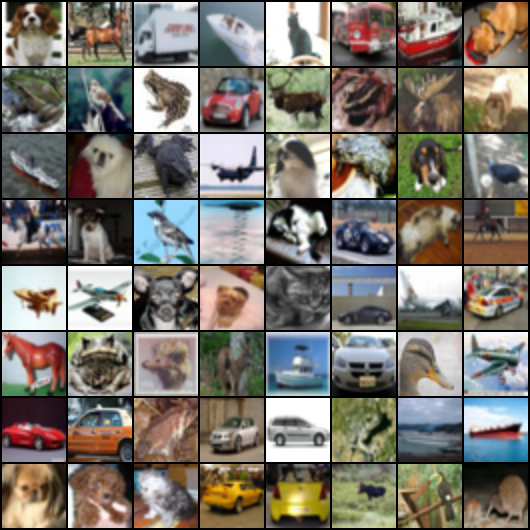

In [12]:
Image.open('output/real_samples.png')

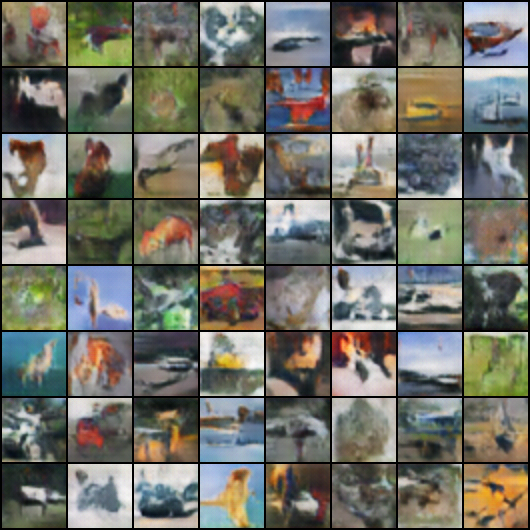

In [13]:
Image.open('output/fake_samples_epoch_024.png')